In [0]:
! wget https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/calogan_metrics.py
! wget https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/prd_score.py
! wget https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/score.py
! wget https://github.com/SchattenGenie/mlhep2019_2_phase/raw/master/analysis/embedder.tp
! wget https://github.com/SchattenGenie/mlhep2019_2_phase/raw/master/analysis/generator.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import seaborn as sns

from IPython.display import clear_output
sns.set()

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

--2020-03-30 10:05:17--  https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/calogan_metrics.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4115 (4.0K) [text/plain]
Saving to: ‘calogan_metrics.py.1’

calogan_metrics.py. 100%[===================>]   4.02K  --.-KB/s    in 0s      

2020-03-30 10:05:17 (144 MB/s) - ‘calogan_metrics.py.1’ saved [4115/4115]

--2020-03-30 10:05:19--  https://raw.githubusercontent.com/SchattenGenie/mlhep2019_2_phase/master/analysis/prd_score.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
train_data_path = '/gdrive/My Drive/mlhep2019_gan/data_train.npz'
val_data_path = '/gdrive/My Drive/mlhep2019_gan/data_val.npz'
test_data_path = '/gdrive/My Drive/mlhep2019_gan/data_test.npz'

In [0]:
from sklearn.model_selection import train_test_split 

N = 50250


data_train = np.load(train_data_path, allow_pickle=True)
data_test = np.load(test_data_path, allow_pickle=True)
print(list(data_test.keys()))
print(type(data_train['EnergyDeposit'][:N]))

# [data_size, 900]
EnergyDeposit, EnergyDepositTest, ParticleMomentum, ParticleMomentumTest, ParticlePoint, ParticlePointTest = train_test_split(data_train['EnergyDeposit'], 
                                                                                                                              data_train['ParticleMomentum'], data_train['ParticlePoint'][:, :2], test_size = 0.2, train_size = 0.8)
#EnergyDeposit = data_train['EnergyDeposit'][:N]
# reshaping it as [data_size, channels, img_size_x, img_size_y]
# channels are needed for pytorch conv2d-layers
EnergyDeposit = EnergyDeposit.reshape(-1, 1, 30, 30)
EnergyDepositTest = EnergyDepositTest.reshape(-1, 1, 30, 30)

# [data_size, 3]
#ParticleMomentum = data_train['ParticleMomentum'][:N]

# [data_size, 2]
#ParticlePoint = data_train['ParticlePoint'][:, :2][:N]

# [data_size, 1]
#ParticlePDG = data_train['ParticlePDG'][:N]

['ParticleMomentum', 'ParticlePoint', 'ParticlePDG']
<class 'numpy.ndarray'>


In [0]:
EnergyDeposit = torch.tensor(EnergyDeposit).float()
ParticleMomentum = torch.tensor(ParticleMomentum).float()
ParticlePoint = torch.tensor(ParticlePoint).float()
EnergyDepositTest = torch.tensor(EnergyDepositTest).float()
ParticleMomentumTest = torch.tensor(ParticleMomentumTest).float()
ParticlePointTest = torch.tensor(ParticlePointTest).float()

BATCH_SIZE = 1500
calo_dataset = utils.TensorDataset(EnergyDeposit, ParticleMomentum, ParticlePoint)
calo_dataloader = torch.utils.data.DataLoader(calo_dataset, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
calo_dataset_test = utils.TensorDataset(EnergyDepositTest, ParticleMomentumTest, ParticlePointTest)
calo_dataloader_test = torch.utils.data.DataLoader(calo_dataset_test, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)

In [0]:
from prd_score import compute_prd, compute_prd_from_embedding, _prd_to_f_beta
from sklearn.metrics import auc
from calogan_metrics import get_shower_width

def train(epoch):
    model.train()
    train_loss = 0
    kl_loss = 0
    rmse_loss = 0
    for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b in calo_dataloader:
      EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                                                            ParticleMomentum_b.to(device), \
                                                            ParticlePoint_b.to(device)
      ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1)
      data = EnergyDeposit_b #, ParticleMomentum_ParticlePoint_b], dim=1)
    #for batch_idx, (data, _) in enumerate(train_loader):
      recon_batch, mu, logvar = model(data, ParticleMomentum_ParticlePoint_b)
      loss, rmse, kl = loss_function(recon_batch, EnergyDeposit_b, mu, logvar)
      if epoch == 19:
        plt.figure(figsize=(12, 12))
        plt.title('Train')
        ax = plt.subplot(211)
        ax.set_title("Real TRAIN")
        plt.imshow(EnergyDeposit_b[0].detach().cpu().numpy().reshape(30, 30))
        ax = plt.subplot(212)
        ax.set_title("Generated TRAIN")
        plt.imshow(recon_batch[0].detach().cpu().numpy().reshape(30, 30))
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        cax = plt.axes([0.85, 0.1, 0.075, 0.8])
        plt.colorbar(cax=cax)
        plt.show()
      optimizer.zero_grad()

      loss.backward()
      kl_loss += kl
      rmse_loss += rmse
      train_loss += loss.item()
      optimizer.step() 
        
    print('TRAIN ====> Epoch: {}  Average loss: {:.4f}'.format(
            epoch, train_loss / len(calo_dataloader.dataset)), 'RMSE:', rmse_loss / len(calo_dataloader.dataset), 'KL:', kl_loss / len(calo_dataloader.dataset))

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_energy_and_shower(energ_distr_real, energ_distr_generated):
    f, ax = plt.subplots(2,2, figsize=(8, 8))
    #f.suptitle("Energy distribution", fontsize=16, y=.9)

    vmin = torch.max(energ_distr_real) 
    vmin = min(vmin, torch.min(energ_distr_generated))
    vmax = torch.max(energ_distr_real) 
    vmax = max(vmax, torch.max(energ_distr_generated))

    for i, distr_type, en_dep in zip([0,1], ["Real", "Generated"],
                                [energ_distr_real[0], energ_distr_generated[0]]):
        for j, distr_name in zip([0,1], ["energy distribution", "shower"]):
            ax[j][i].set_title (distr_type + " " + distr_name,  fontsize=14)
            ax[j][i].set_xticks(np.arange(-0.5, 30., 1.), minor=True)
            ax[j][i].set_xticks(np.arange(-0.5, 30., 5.), minor=False)                    
            ax[j][i].set_xticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

        ax[0][i].set_xlabel(r'$x$', fontsize=12)
        ax[0][i].set_ylabel(r'$y$', fontsize=12)
        ax[1][i].set_xlabel(r'Cluster traverse width ($x$)', fontsize=12)
        ax[1][i].set_ylabel(r'Arbitrary units (sum along $y$)', fontsize=12)

        ax[0][i].set_yticks(np.arange(-0.5, 30., 1.), minor=True)
        ax[0][i].set_yticks(np.arange(-0.5, 30., 5.), minor=False)                    
        ax[0][i].set_yticklabels(np.arange(-15, 16, 5), minor=False, fontsize=8)

        # plot shower
        ax[1][i].bar(np.arange(0,30), torch.sum(en_dep, axis=0), 
                  width=1.0, align='edge', edgecolor='black')

        # plot energy distribution
        ax[0][i].grid(which='both', color='dimgray', linestyle='-', linewidth=0.5)
        im = ax[0][i].imshow(en_dep, origin = 'lower', cmap="inferno", 
                          vmin=vmin, vmax=vmax)

        # add colorabar for the energy distributions
        divider = make_axes_locatable(ax[0][i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()
    return

In [0]:
def test(epoch):
  model.eval()
  test_loss = 0
  kl_loss = 0
  rmse_loss = 0
  for EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b in calo_dataloader_test:
    EnergyDeposit_b, ParticleMomentum_b, ParticlePoint_b = EnergyDeposit_b.to(device), \
                                                          ParticleMomentum_b.to(device), \
                                                          ParticlePoint_b.to(device)
    ParticleMomentum_ParticlePoint_b = torch.cat([ParticleMomentum_b, ParticlePoint_b], dim=1)
    data = EnergyDeposit_b
  #for batch_idx, (data, _) in enumerate(train_loader):
    recon_batch, mu, logvar = model(data, ParticleMomentum_ParticlePoint_b)
    loss, rmse, kl = loss_function(recon_batch, EnergyDeposit_b, mu, logvar)
    if epoch == 0:
        plt.figure(figsize=(12, 12))
        plt.title('Test')
        ax = plt.subplot(211)
        ax.set_title("Real TEST")
        plt.imshow(EnergyDeposit_b[0].detach().cpu().numpy().reshape(30, 30))
        ax = plt.subplot(212)
        ax.set_title("Generated TEST")
        plt.imshow(recon_batch[0].detach().cpu().numpy().reshape(30, 30))
        plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
        cax = plt.axes([0.85, 0.1, 0.075, 0.8])
        plt.colorbar(cax=cax)
        plt.show()
        plot_energy_and_shower(EnergyDeposit_b[0].detach().cpu(), recon_batch[0].detach().cpu())
    test_loss += loss.item()
    kl_loss += kl
    rmse_loss += rmse
  print('TEST ====> Epoch: {} Average loss: {:.4f}'.format(
            epoch, test_loss / len(calo_dataloader_test.dataset)), 'RMSE:', rmse_loss / len(calo_dataloader_test.dataset), 'KL:', kl_loss / len(calo_dataloader_test.dataset))

In [0]:
class VAE(nn.Module):
	def __init__(self, h_dim=128, z_dim=30):
		super(VAE, self).__init__()
	
		self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		self.conv3 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		self.pool1 = nn.MaxPool2d(2) #15x15
		self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2)) #7x7
		self.conv5 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
		self.conv6 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  
		self.bn1 = nn.BatchNorm2d(16)
		self.bn2 = nn.BatchNorm2d(32)
		self.bn3 = nn.BatchNorm2d(32)
		self.bn4 = nn.BatchNorm2d(64)
		self.bn5 = nn.BatchNorm2d(64)
		self.bn6 = nn.BatchNorm2d(128)
	
		self.fc1 = nn.Linear(h_dim + 5, z_dim)
		self.fc2 = nn.Linear(h_dim + 5, z_dim)
		self.fc3 = nn.Linear(z_dim + 5, h_dim)
		self.fc4 = nn.Linear(h_dim, 512)
		self.fc5 = nn.Linear(512, 3200)

		self.conv1t = nn.ConvTranspose2d(128, 128, kernel_size=(3, 3))
		self.conv2t = nn.ConvTranspose2d(128, 128, kernel_size=(3, 3))
		self.conv3t = nn.ConvTranspose2d(128, 64, kernel_size=(3, 3))
		self.conv4t = nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
		self.conv5t = nn.ConvTranspose2d(64, 32, kernel_size=(3, 3))
		self.conv6t = nn.ConvTranspose2d(32, 16, kernel_size=(3, 3))
		self.conv7t = nn.ConvTranspose2d(16, 1, kernel_size=(3, 3))
	
		self.bn1t = nn.BatchNorm2d(128)
		self.bn2t = nn.BatchNorm2d(128)
		self.bn3t = nn.BatchNorm2d(64)
		self.bn4t = nn.BatchNorm2d(64)
		self.bn5t = nn.BatchNorm2d(32)
		self.bn6t = nn.BatchNorm2d(16)

	def encode(self, x, params):
		#print(x.shape)
		x = F.leaky_relu(self.bn1(self.conv1(x)))
		#print(1) 	# 30x30
		x = F.leaky_relu(self.bn2(self.conv2(x)))
		#print(1)
		x = self.bn3(self.conv3(x))
		#print(1)
		x = F.leaky_relu(self.pool1(x)) 			# 15x15
		x = F.leaky_relu(self.bn4(self.conv4(x)))  
		x = F.leaky_relu(self.bn5(self.conv5(x)))  
		x = self.bn6(self.conv6(x)) 				# 7x7
	
		x = F.leaky_relu(nn.MaxPool2d(kernel_size=x.size()[2:])(x))
		x = x.view(x.size(0), -1)
		x = F.leaky_relu(x)
		x = torch.cat([x, params], dim=1)
		return F.leaky_relu(self.fc1(x)), F.leaky_relu(self.fc2(x))


	def reparameterize(self, mu, logvar):
		std = torch.exp(0.5 * logvar)
		eps = torch.randn_like(std)
		return mu + eps * std


	def decode(self, z, params):
		z = F.leaky_relu(self.fc3(torch.cat([z, params], dim=1)))
		z = F.leaky_relu(self.fc4(z))
		z = F.leaky_relu(self.fc5(z))
		z = z.view(-1, 128, 5, 5)			# 5x5x128
		z = F.leaky_relu(self.bn1t(self.conv1t(z)))  	# 7x7x128
		z = F.leaky_relu(self.bn2t(self.conv2t(z)))	# 9x9x128
		z = F.leaky_relu(self.bn3t(self.conv3t(z)))	# 11x11x64
		z = F.leaky_relu(self.bn4t(self.conv4t(z)))	# 24x24x64
		z = F.leaky_relu(self.bn5t(self.conv5t(z)))	# 26x26x32
		z = F.leaky_relu(self.bn6t(self.conv6t(z)))	# 28x28x16
		z = F.leaky_relu(self.conv7t(z))					# 30x30x1
		
		return z


	def forward(self, x, params):
		mu, logvar = self.encode(x, params)
		z = self.reparameterize(mu, logvar)
		return self.decode(z, params), mu, logvar

In [0]:
def loss_function(recon_x, x, mu, logvar):
    RMSE = torch.sqrt(F.mse_loss(recon_x, x, reduction='sum'))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return RMSE + KLD, RMSE.item(), KLD.item()

In [0]:
model = VAE().to(device)
model.load_state_dict(torch.load('/gdrive/My Drive/vae8.pt'))
#optimizer = optim.Adam(model.parameters(), lr=1e-3)

<All keys matched successfully>

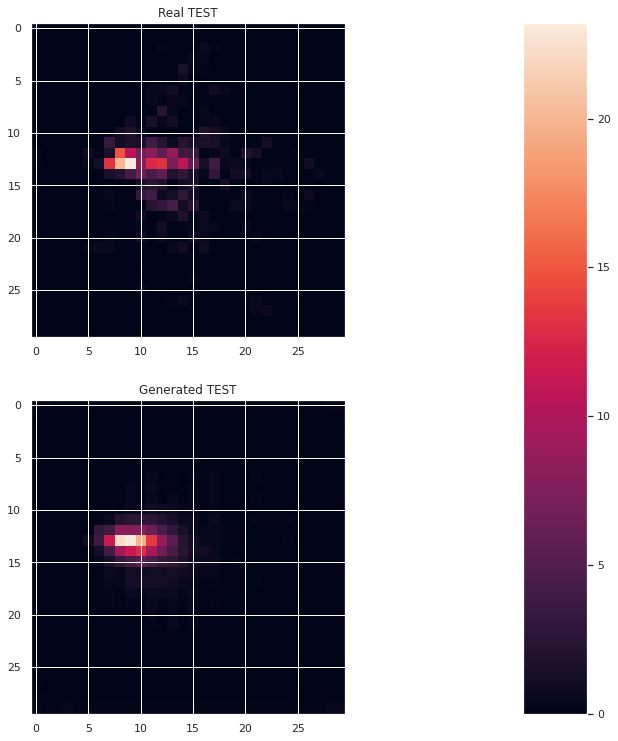

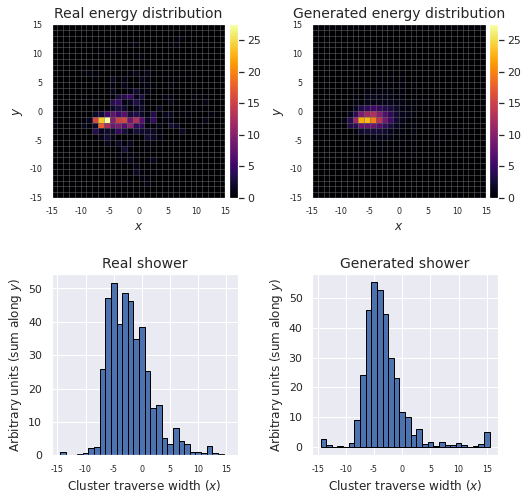

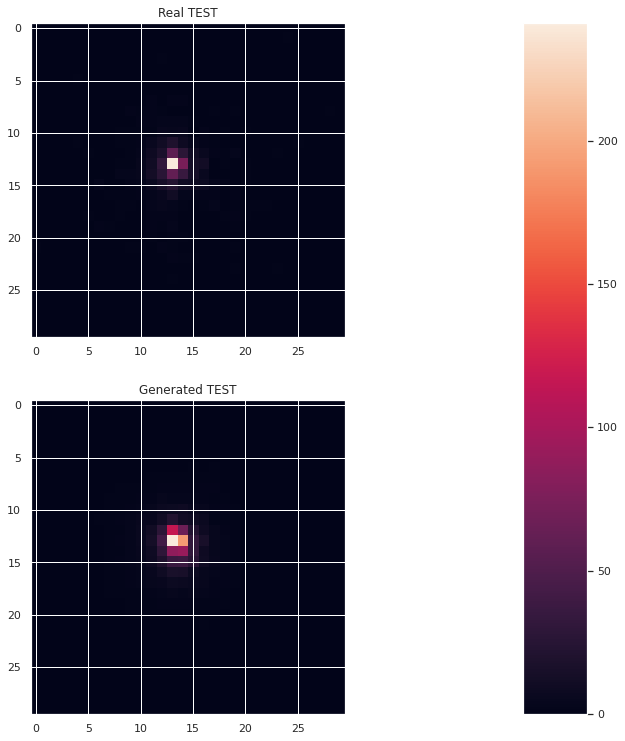

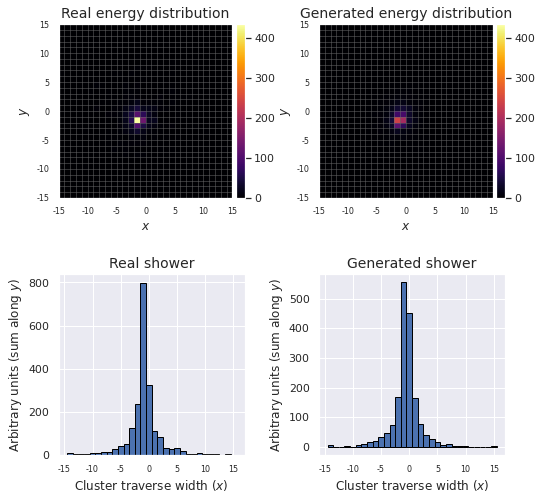

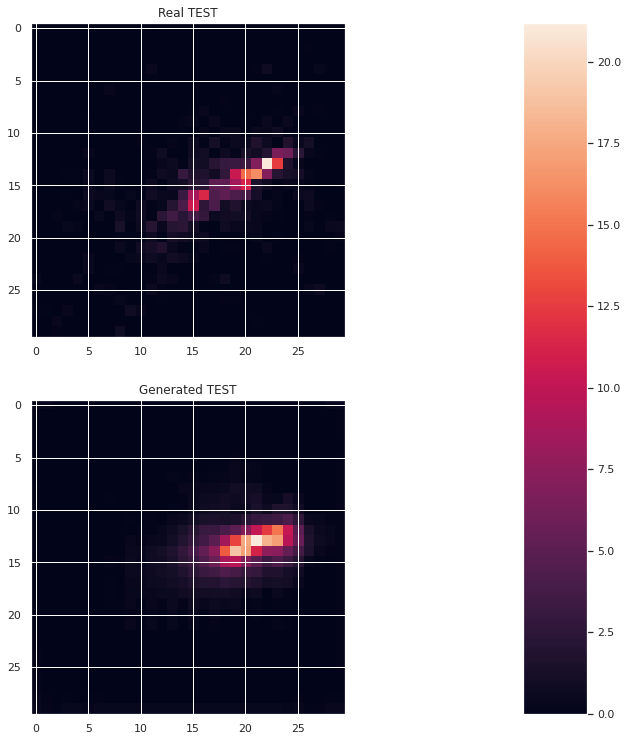

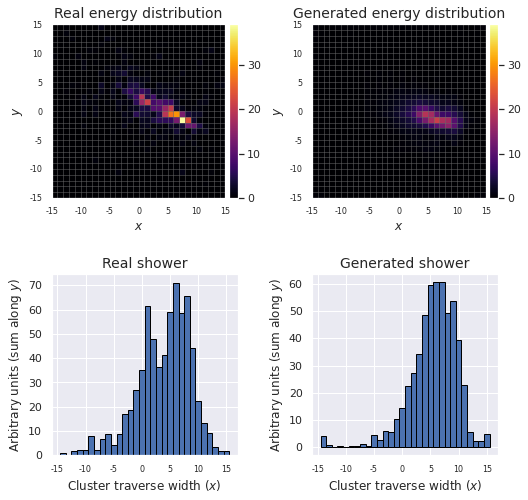

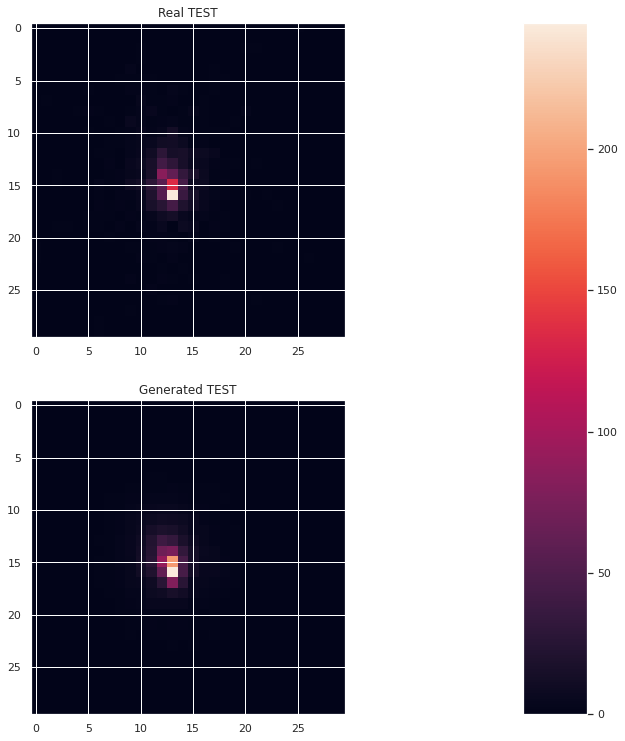

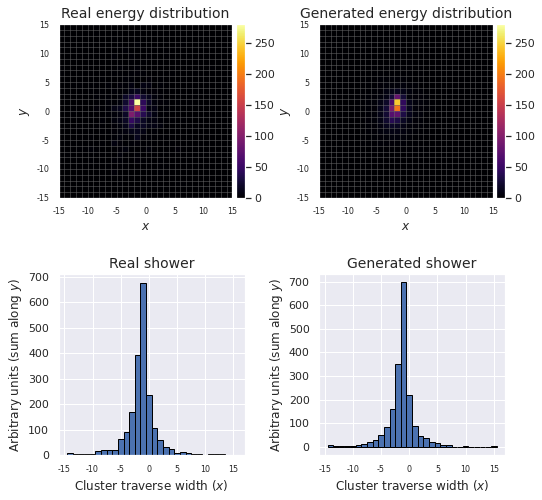

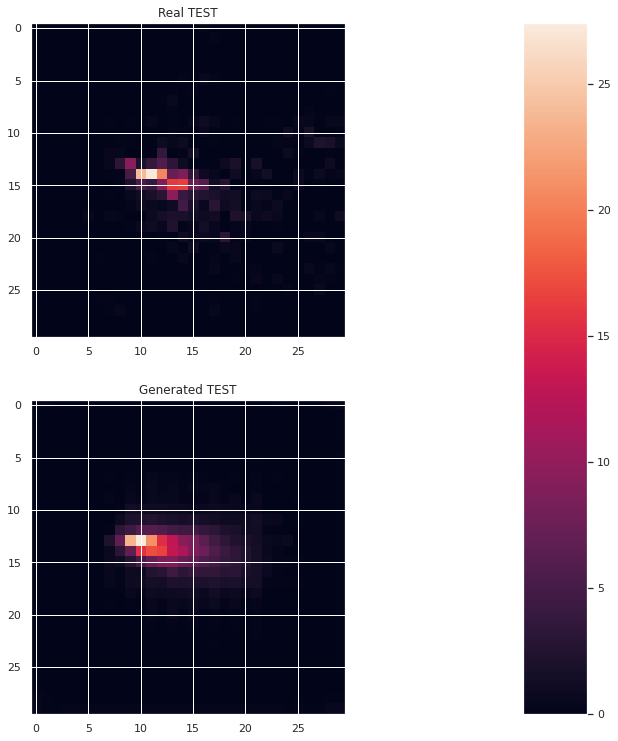

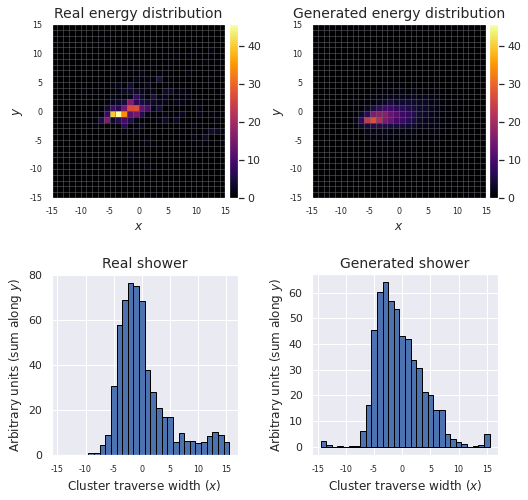

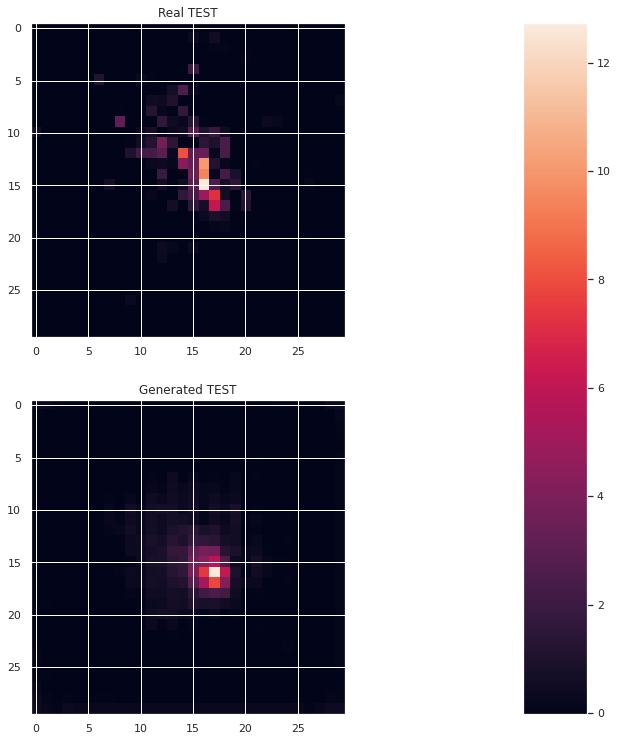

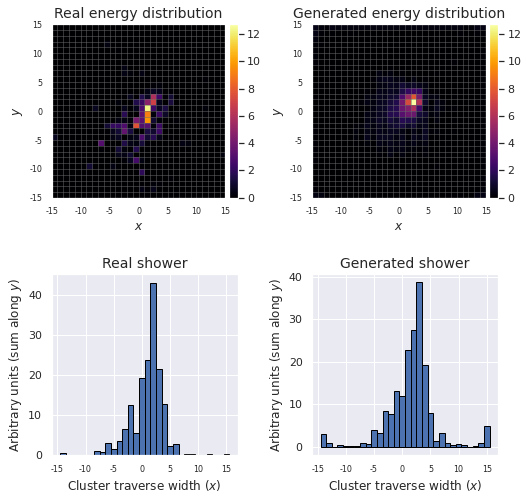

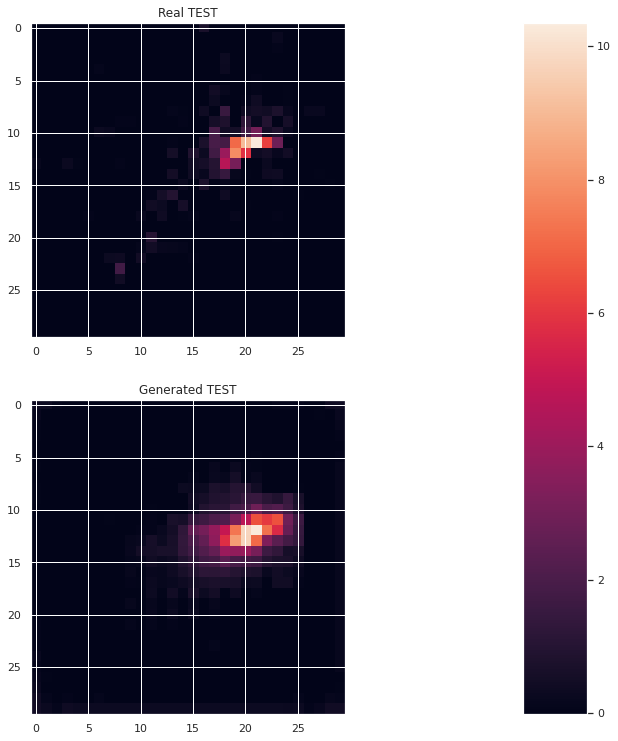

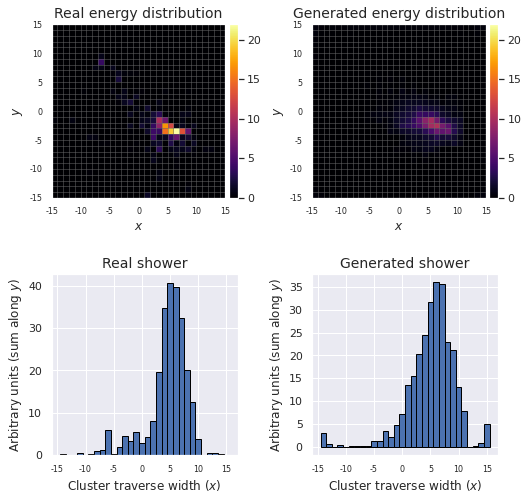

TEST ====> Epoch: 0 Average loss: 6.4716 RMSE: 6.356112989738806 KL: 0.11549330602237834


In [0]:
test(0)

TRAIN ====> Epoch: 0  Average loss: 605.6708 RMSE: 18.734943446828357 KL: 586.9358904847103
TEST ====> Epoch: 0 Average loss: 21.2458 RMSE: 19.212576375932837 KL: 2.033235458449938
TRAIN ====> Epoch: 1  Average loss: 18.7737 RMSE: 17.877614126632462 KL: 0.8960730329674867
TEST ====> Epoch: 1 Average loss: 18.3942 RMSE: 17.634185906405474 KL: 0.7600363235094061
TRAIN ====> Epoch: 2  Average loss: 17.7475 RMSE: 17.068754469838307 KL: 0.6787503264318058
TEST ====> Epoch: 2 Average loss: 18.2046 RMSE: 17.561114933146765 KL: 0.6435131957400497
TRAIN ====> Epoch: 3  Average loss: 16.7863 RMSE: 16.199865078902363 KL: 0.5863931031488068
TEST ====> Epoch: 3 Average loss: 17.5784 RMSE: 17.020015352922886 KL: 0.5583818638739895
TRAIN ====> Epoch: 4  Average loss: 15.4351 RMSE: 14.923303113339552 KL: 0.5117675568689755
TEST ====> Epoch: 4 Average loss: 16.5659 RMSE: 16.064458372201493 KL: 0.5014501679833255
TRAIN ====> Epoch: 5  Average loss: 13.9648 RMSE: 13.500498289800994 KL: 0.4643342818075152

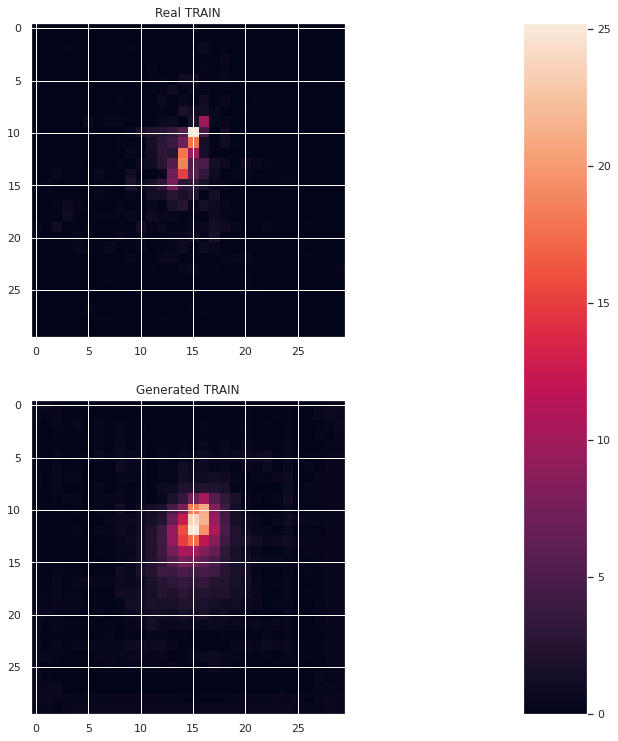

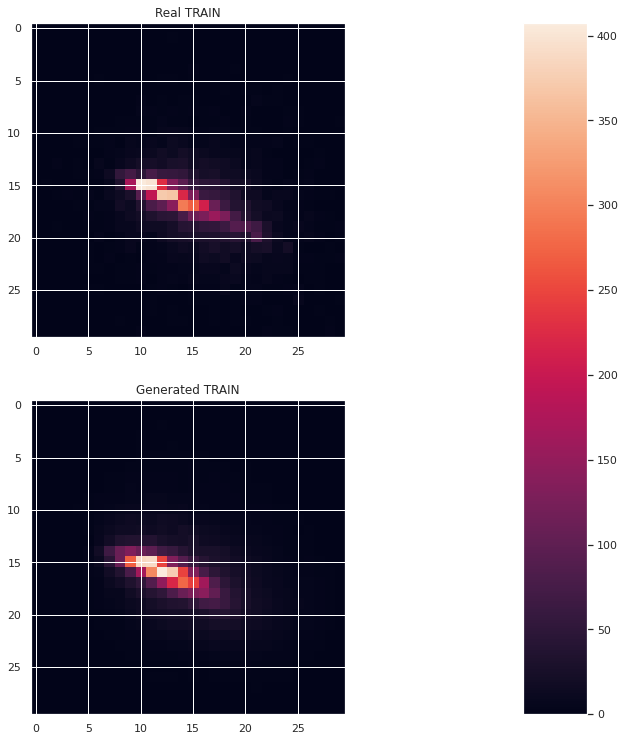

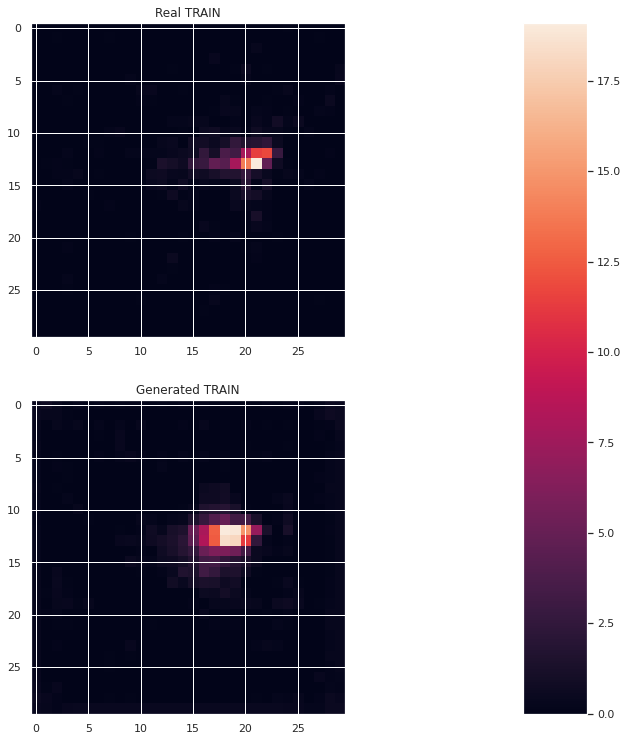

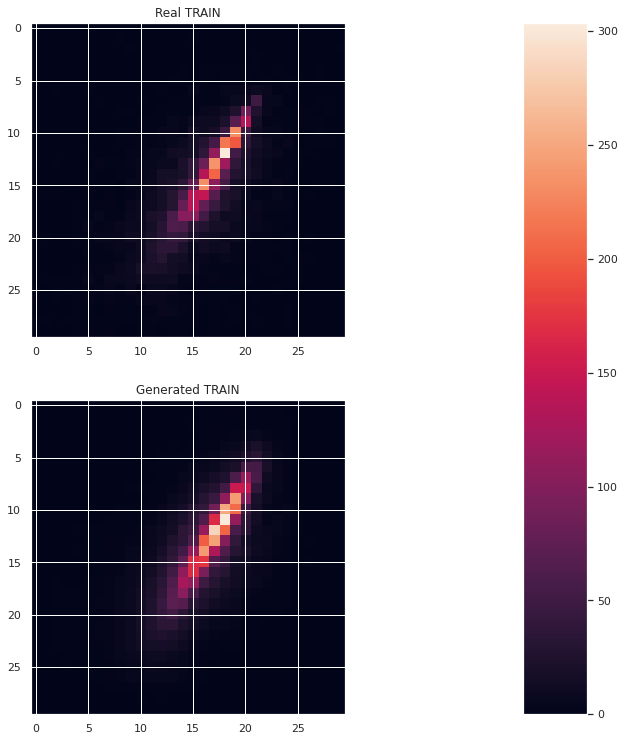

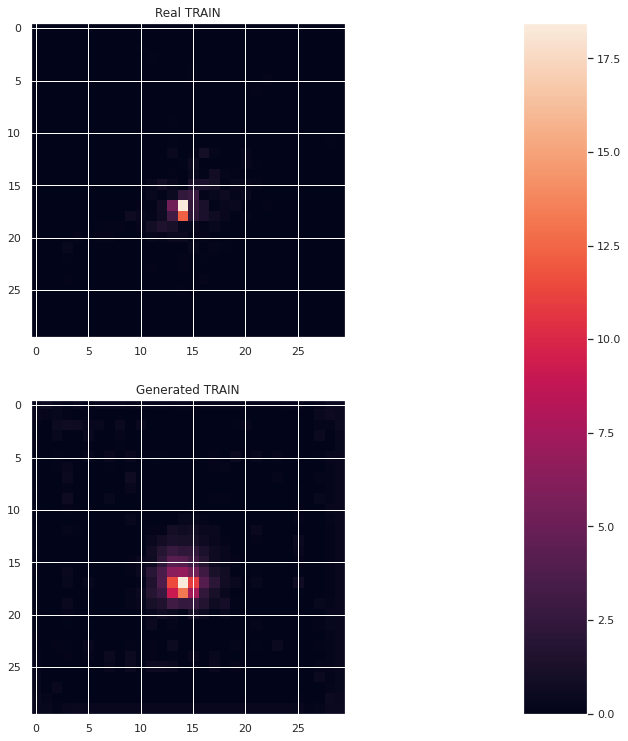

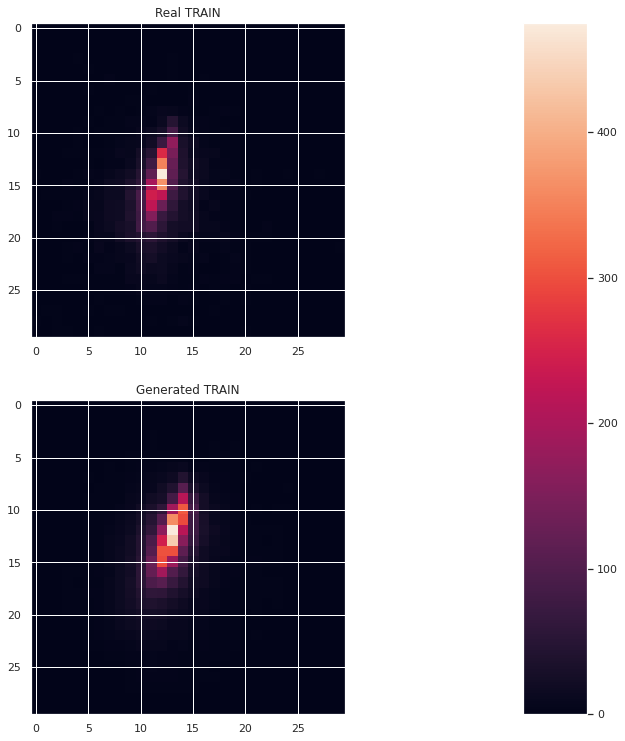

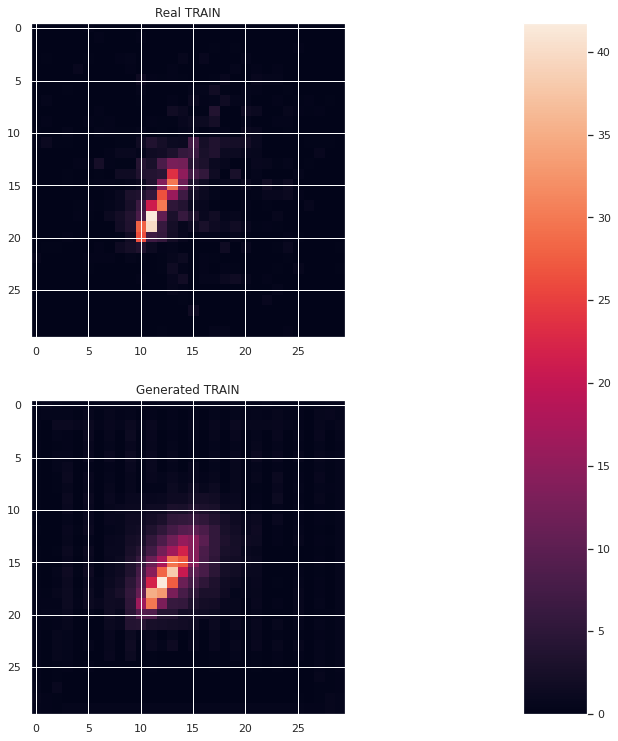

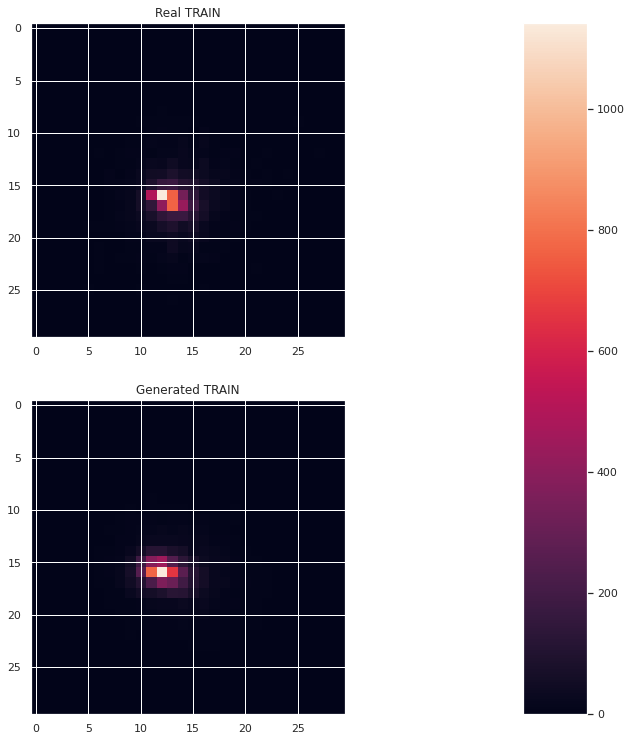

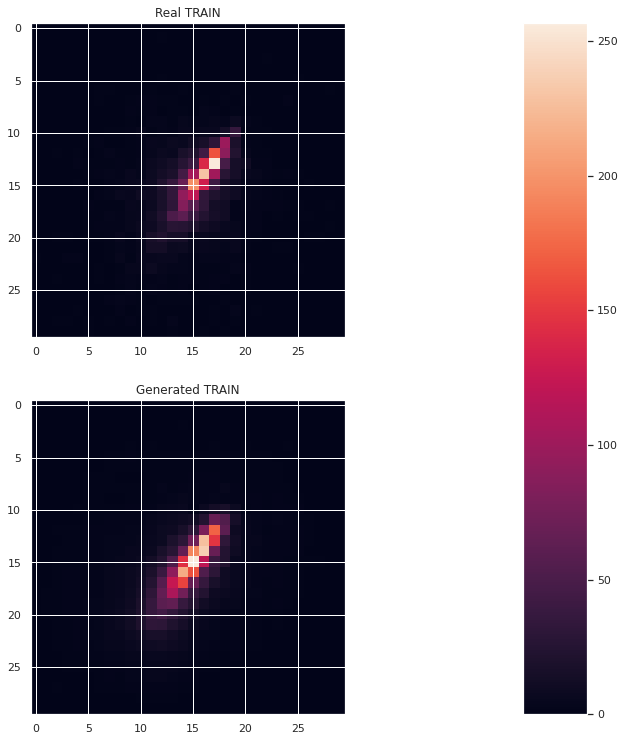

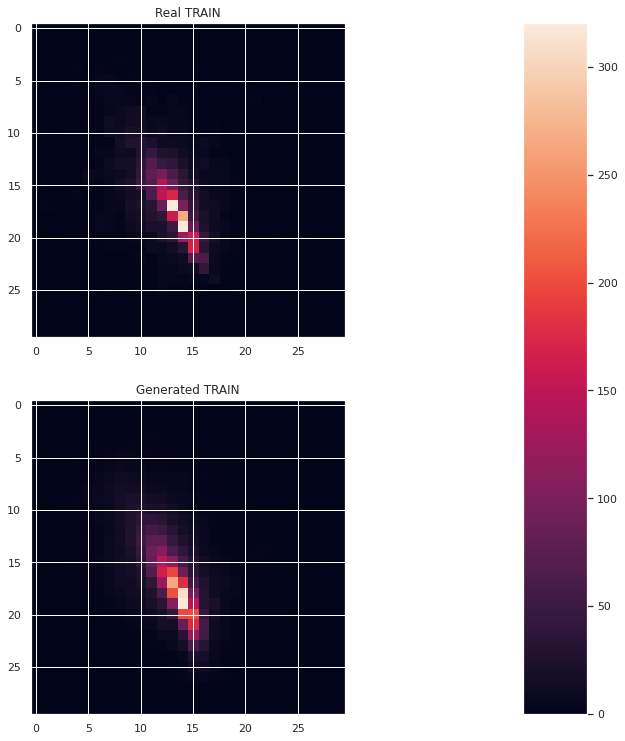

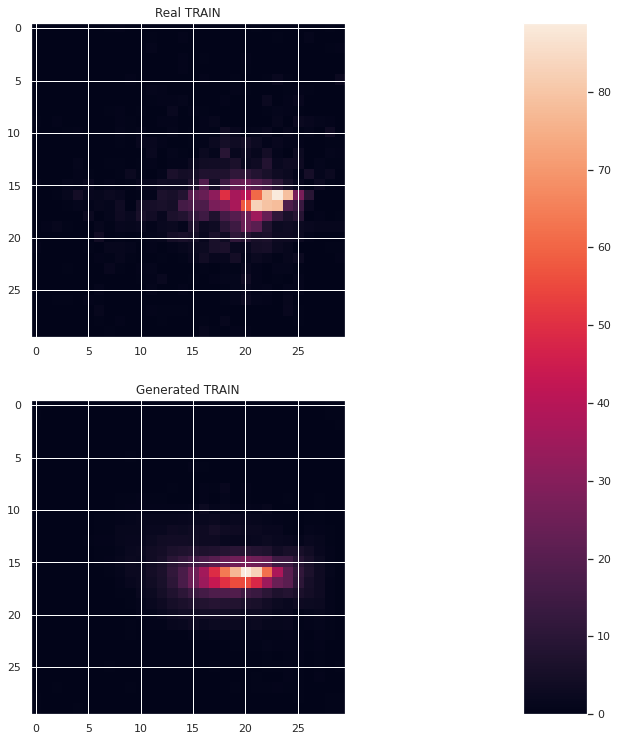

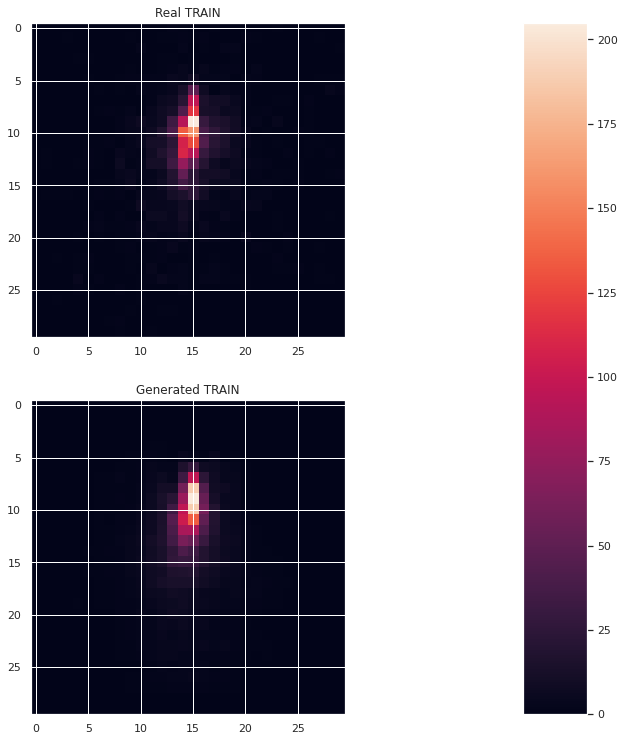

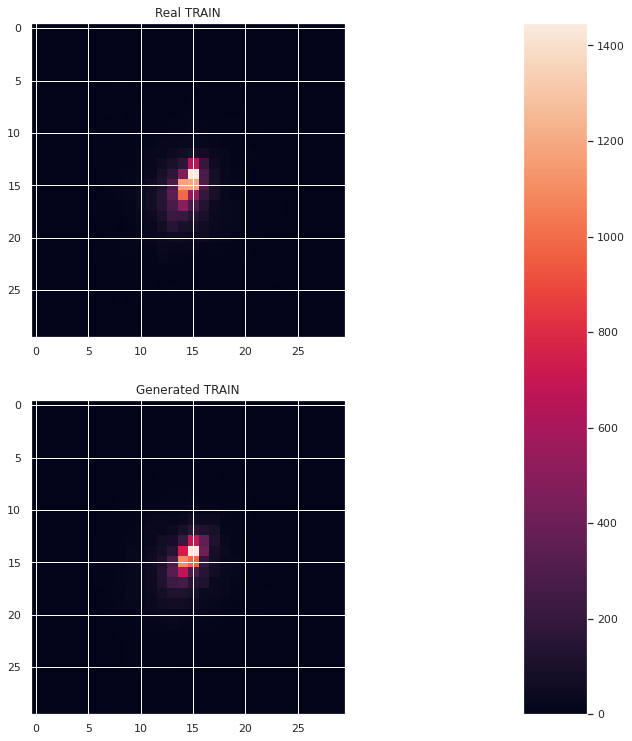

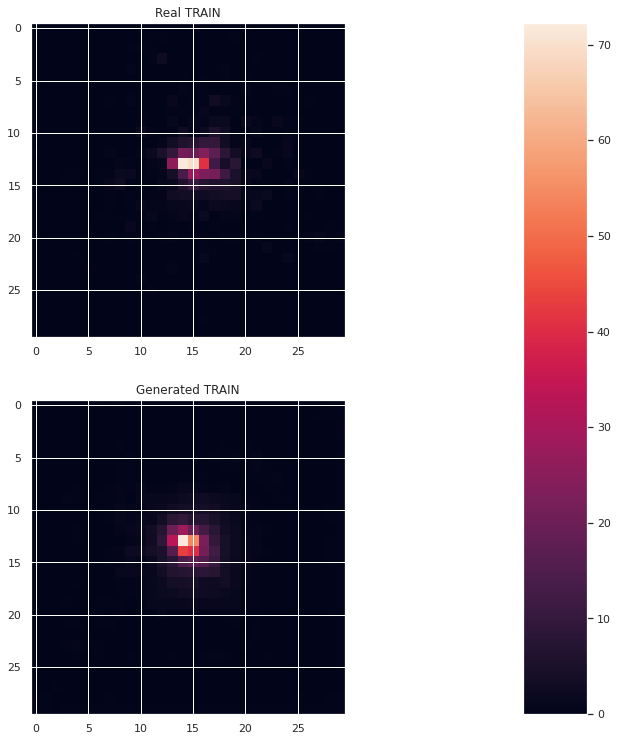

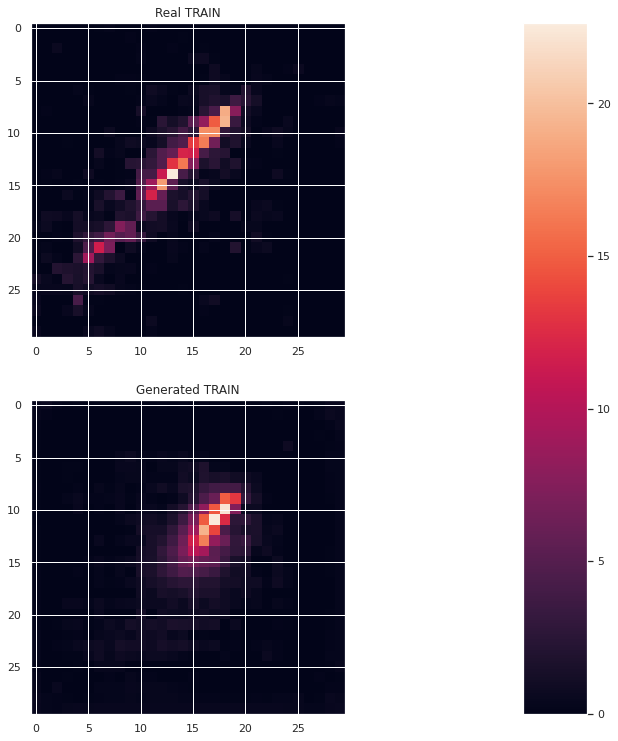

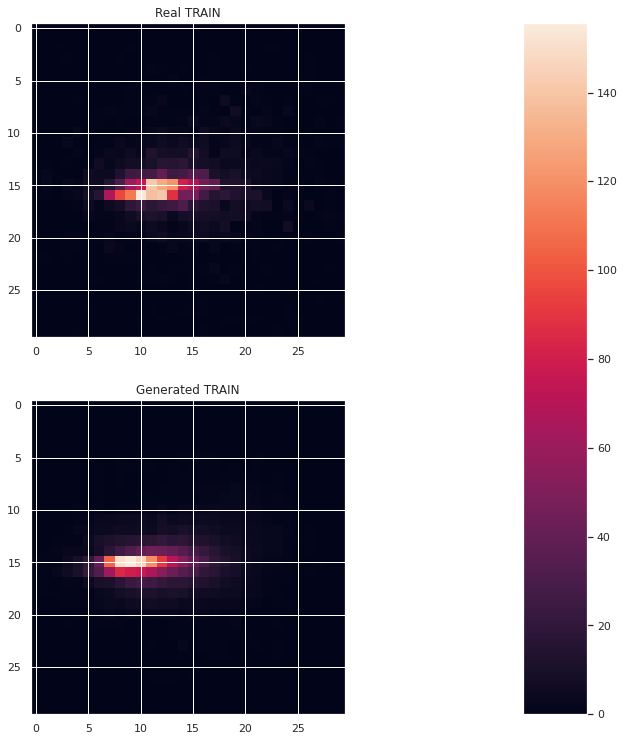

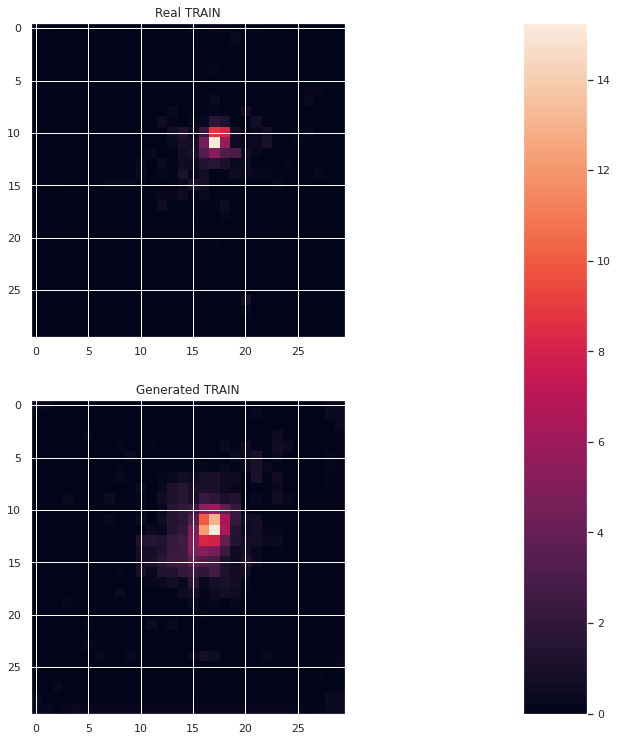

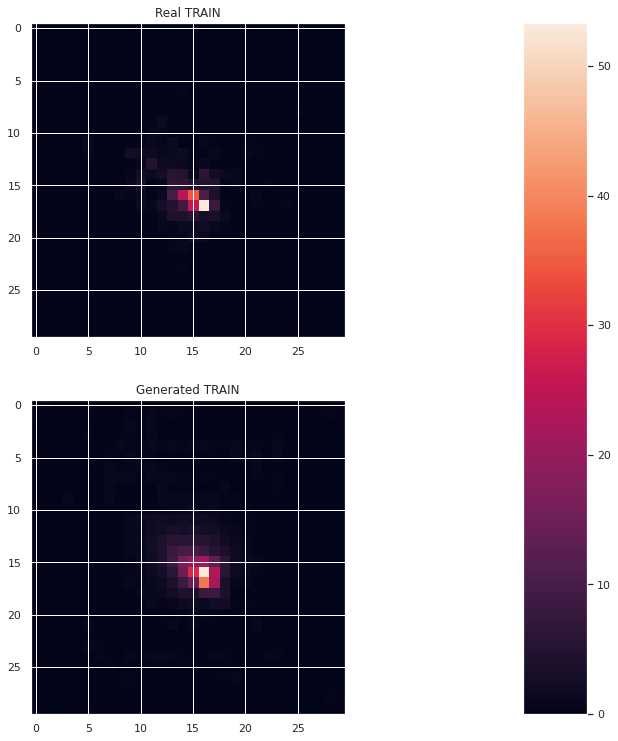

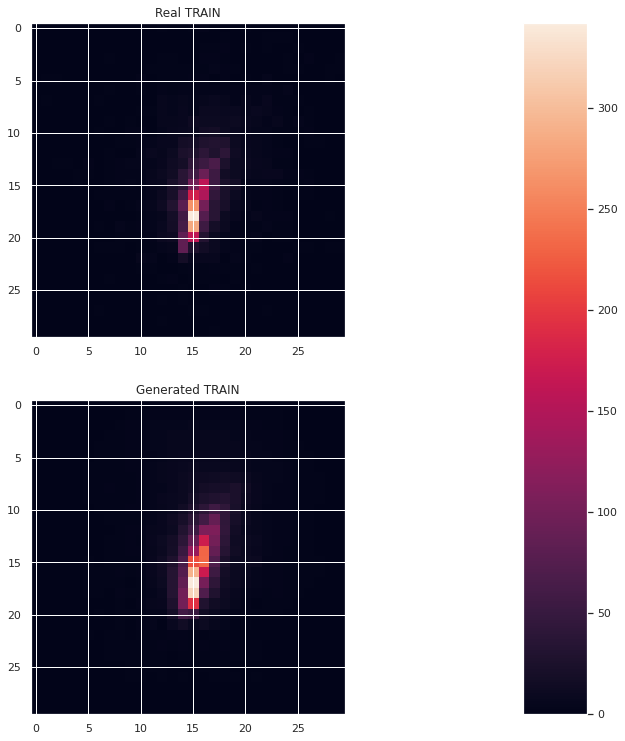

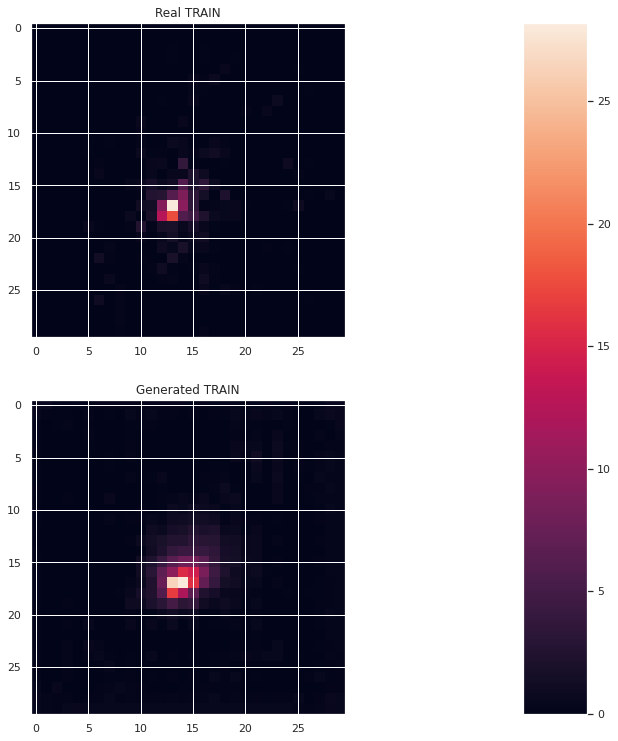

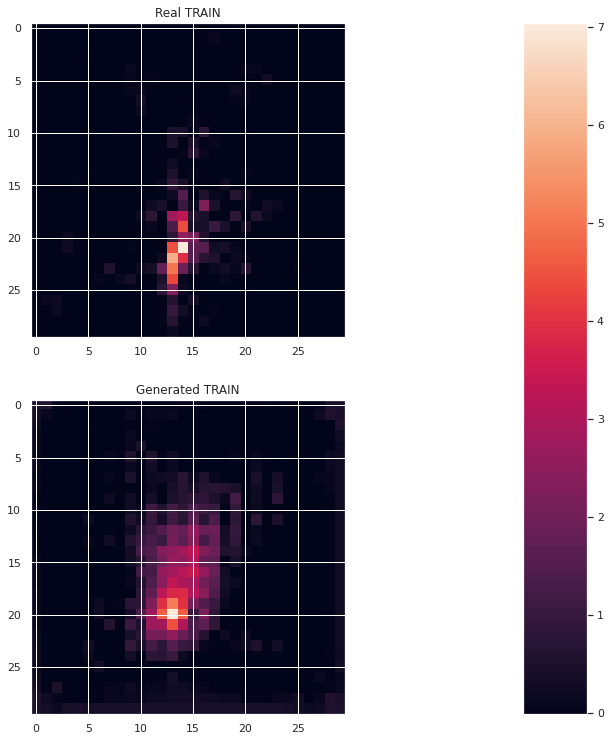

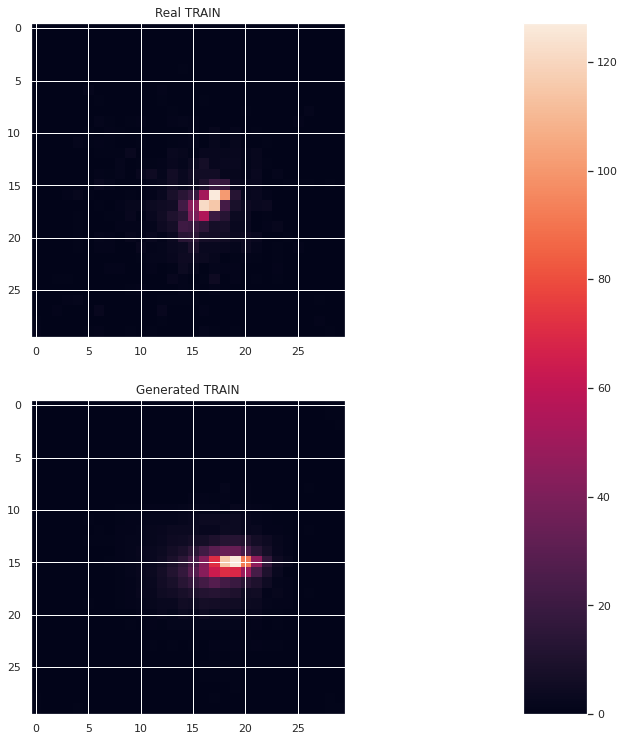

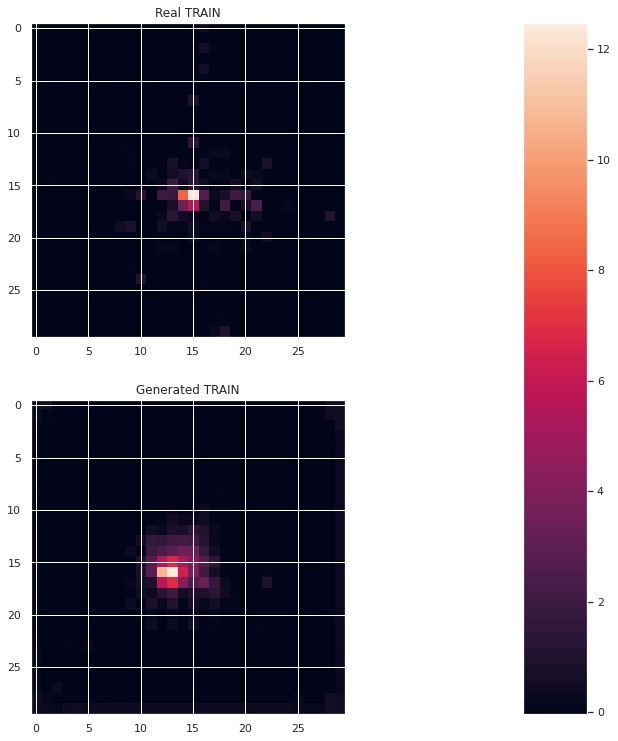

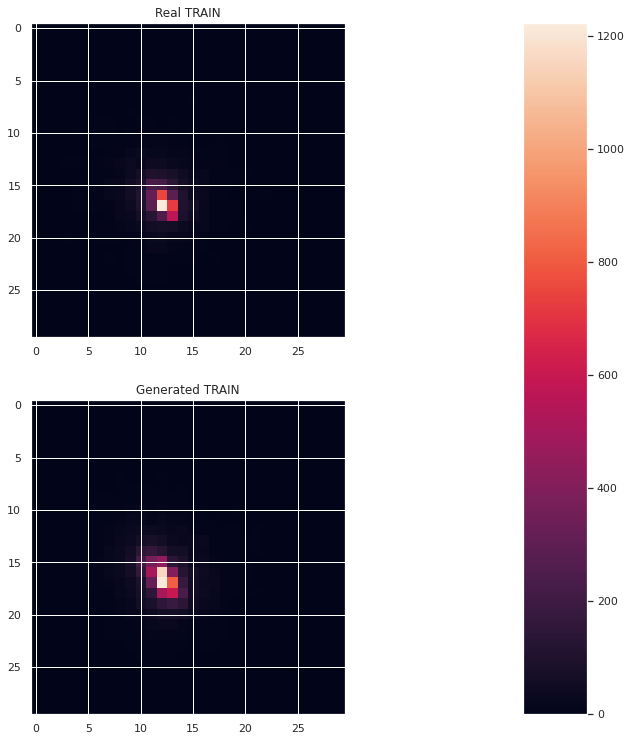

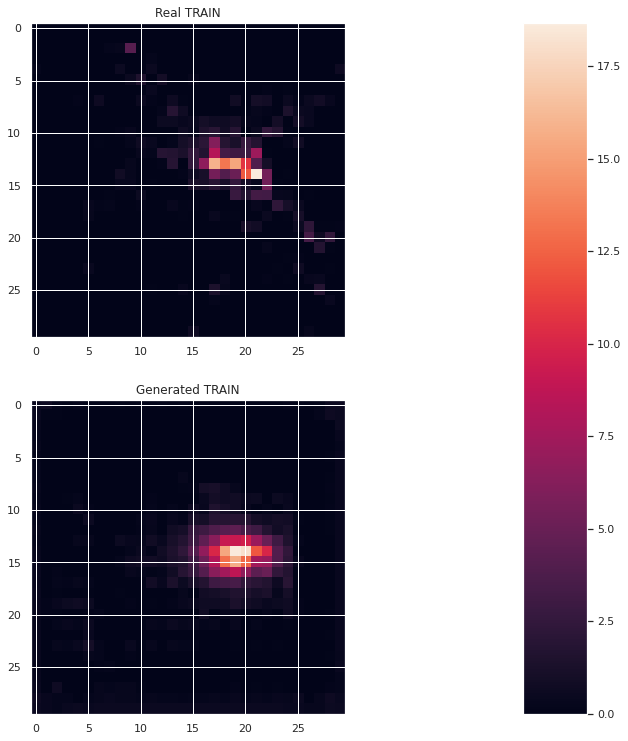

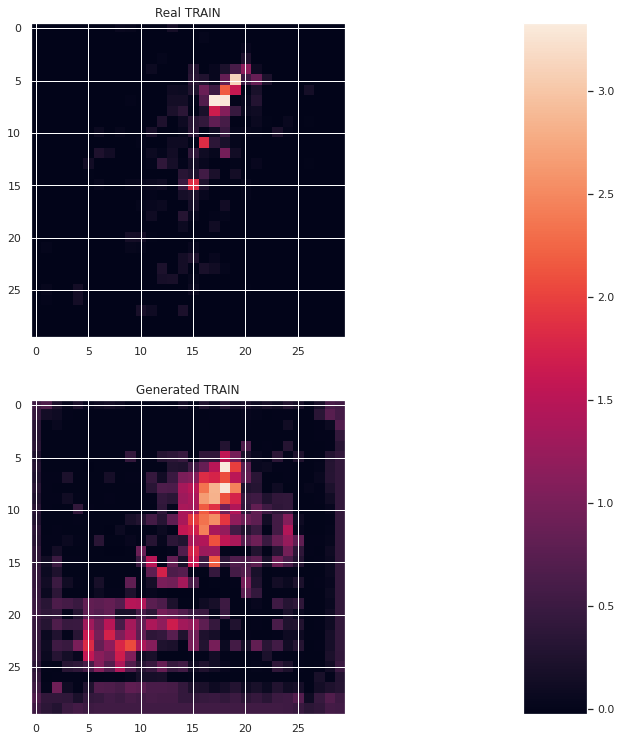

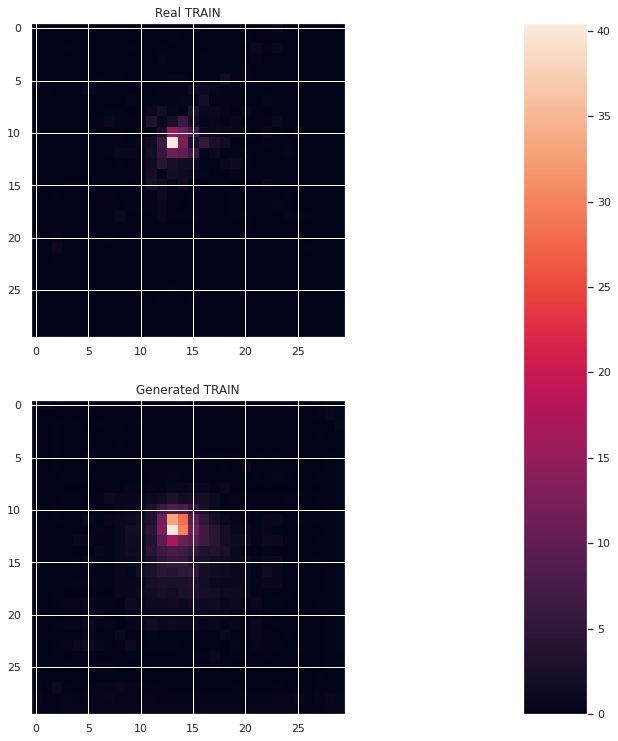

TRAIN ====> Epoch: 19  Average loss: 7.8229 RMSE: 7.596251651896766 KL: 0.22669787734302121


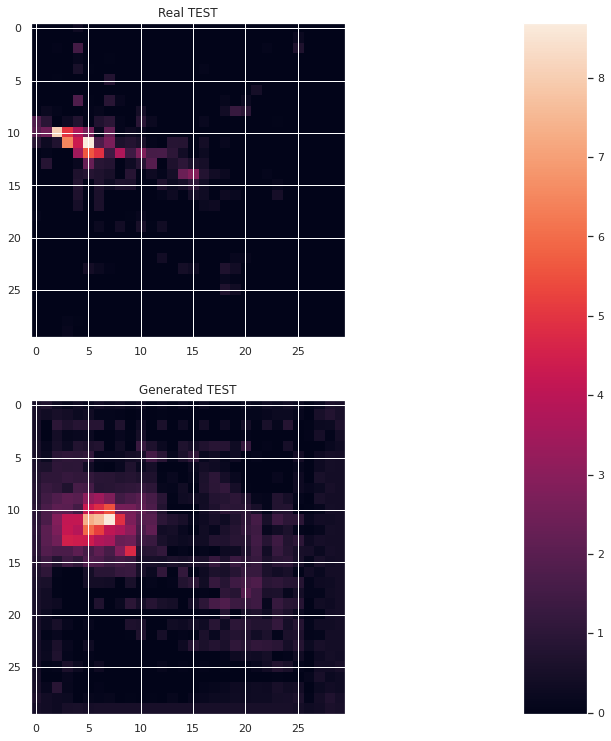

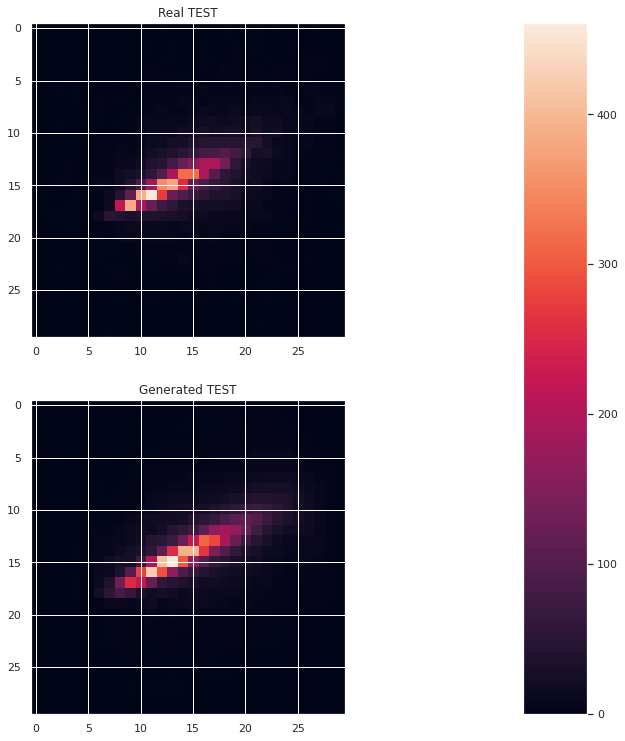

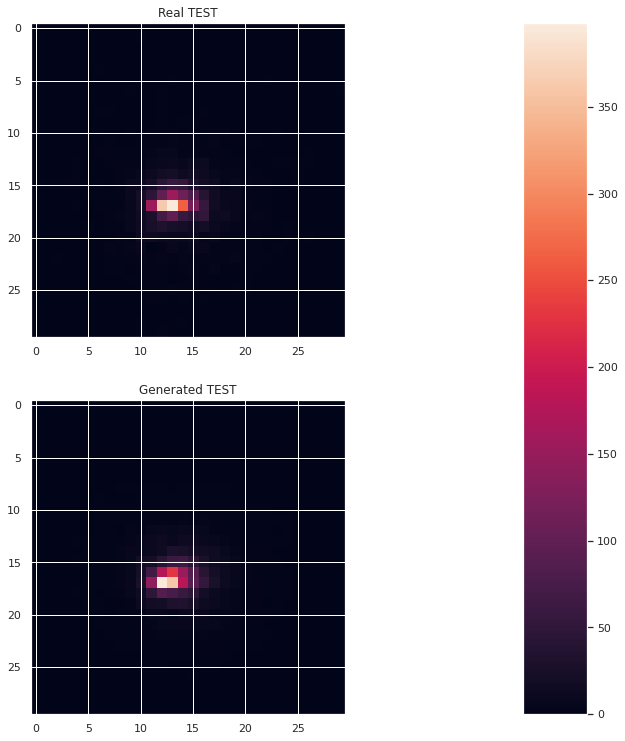

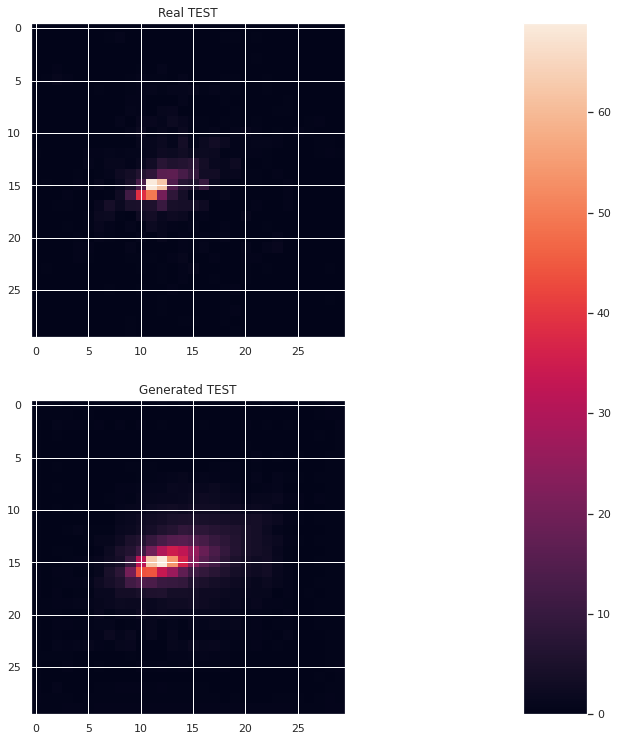

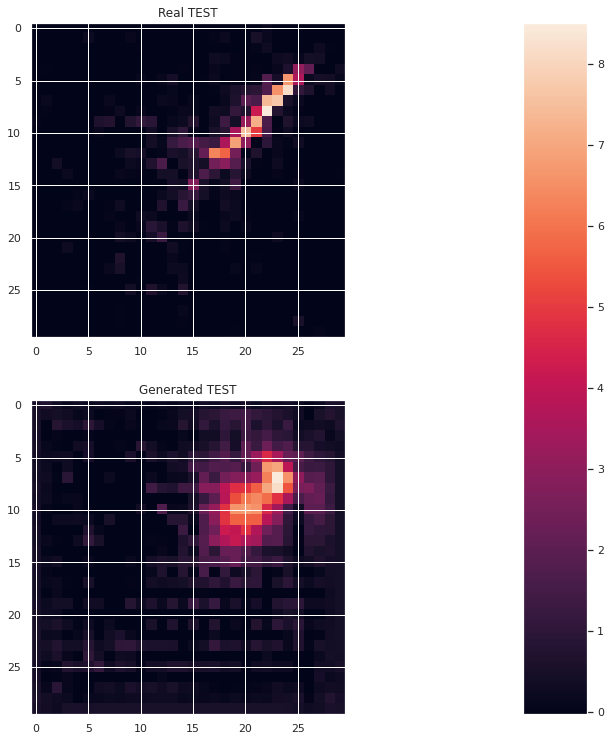

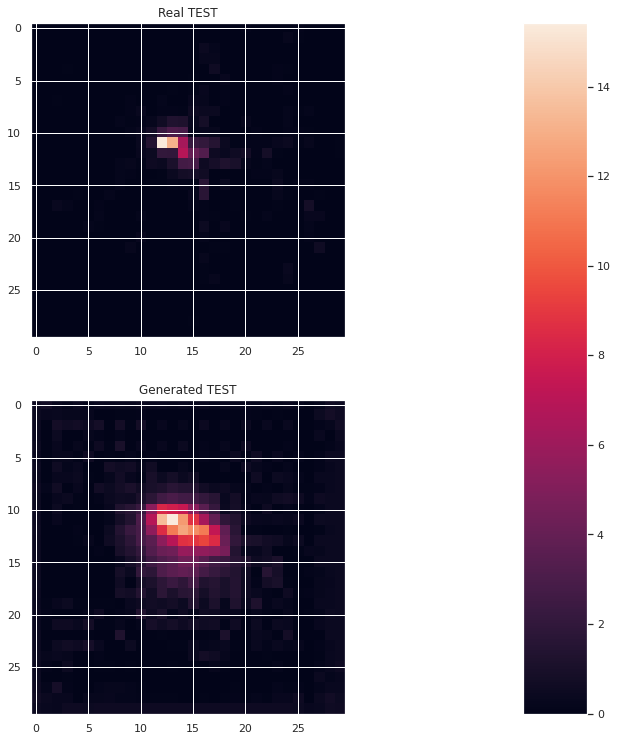

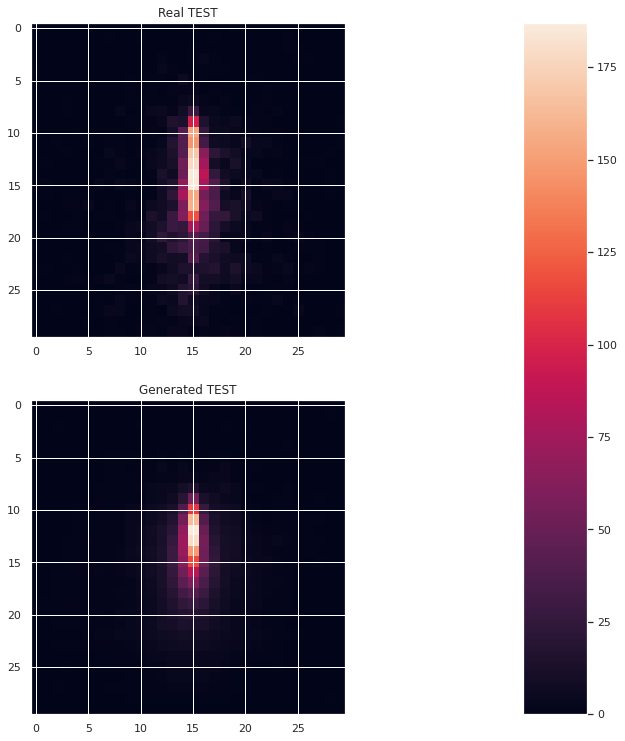

TEST ====> Epoch: 19 Average loss: 7.7423 RMSE: 7.513709382773632 KL: 0.22855221420971314


In [0]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6, amsgrad=True)
for epoch in range(20): #4
  train(epoch)
  test(epoch)

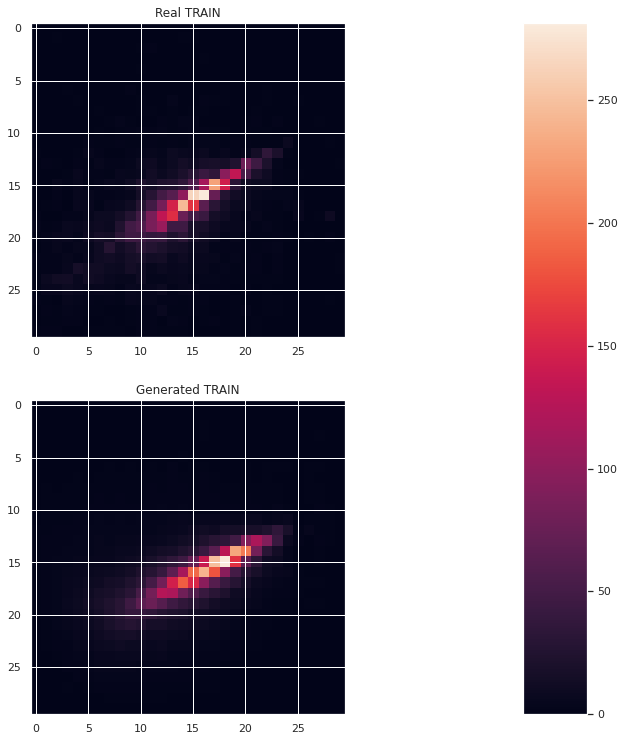

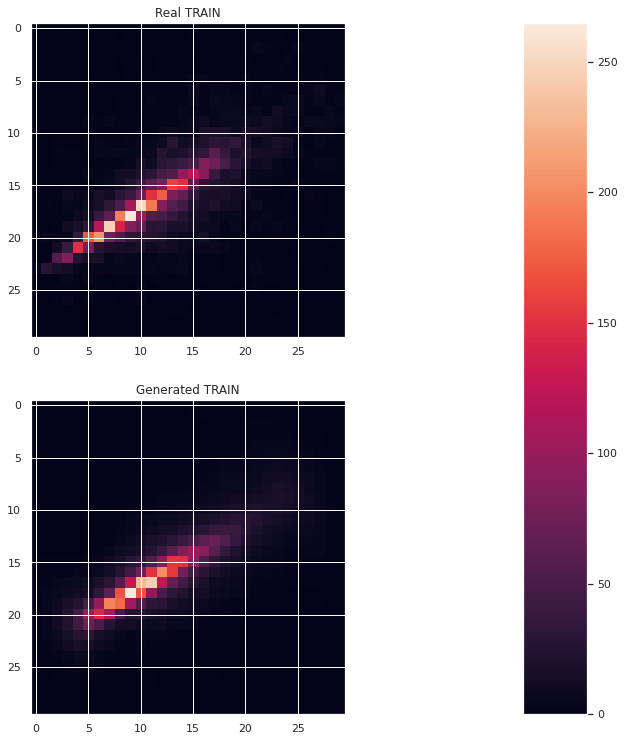

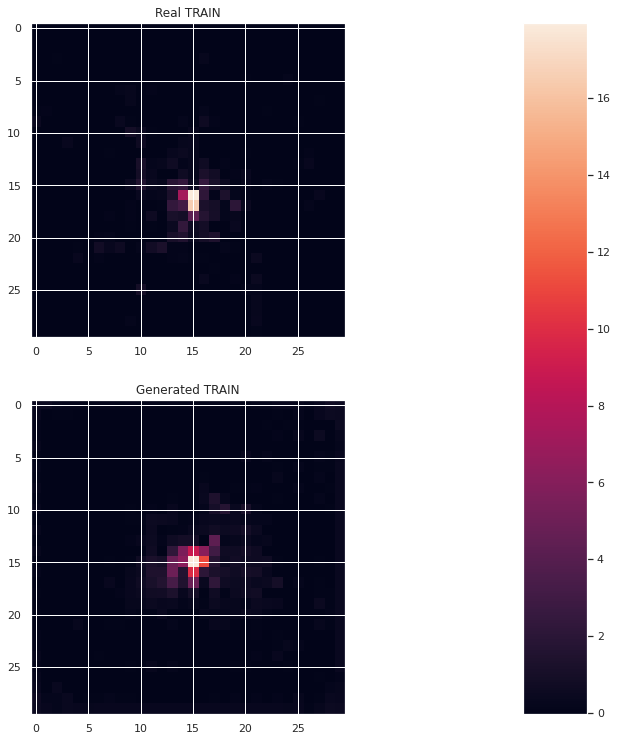

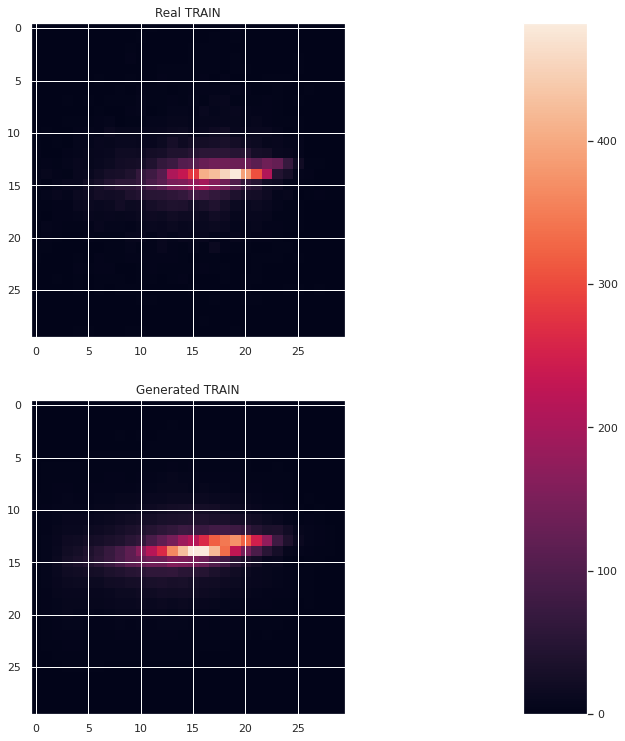

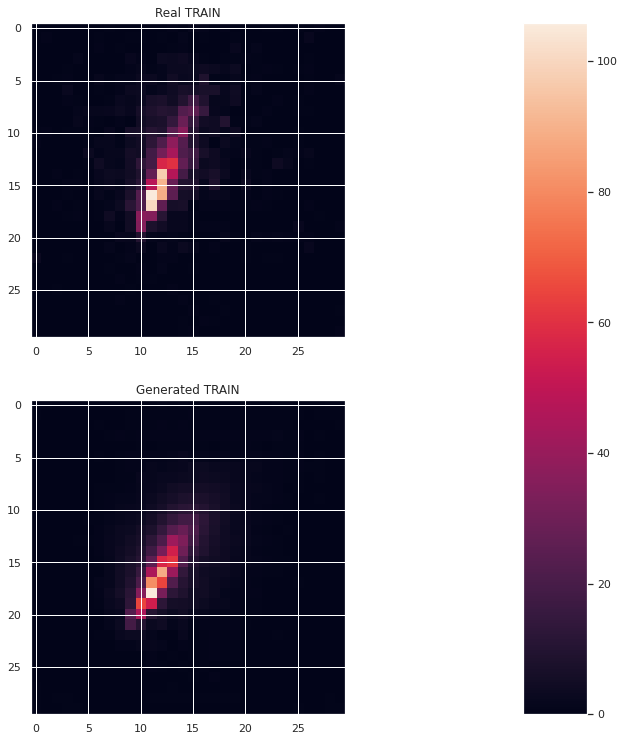

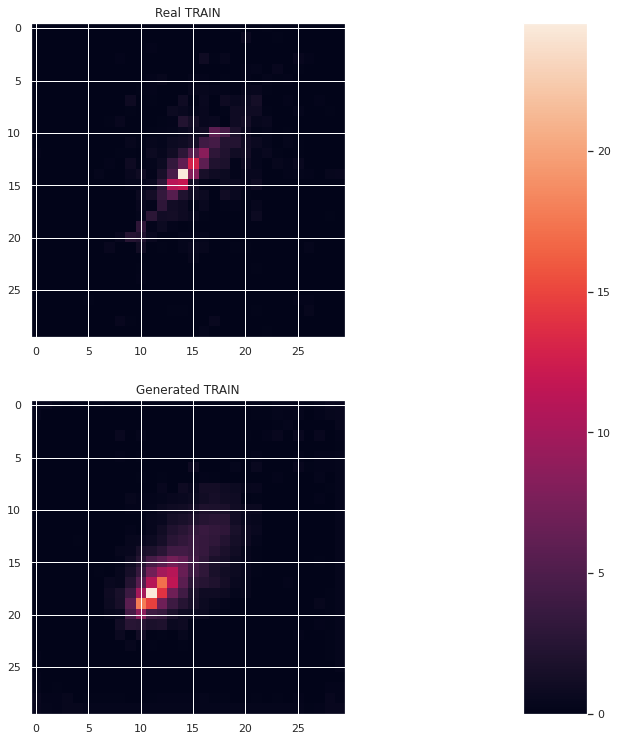

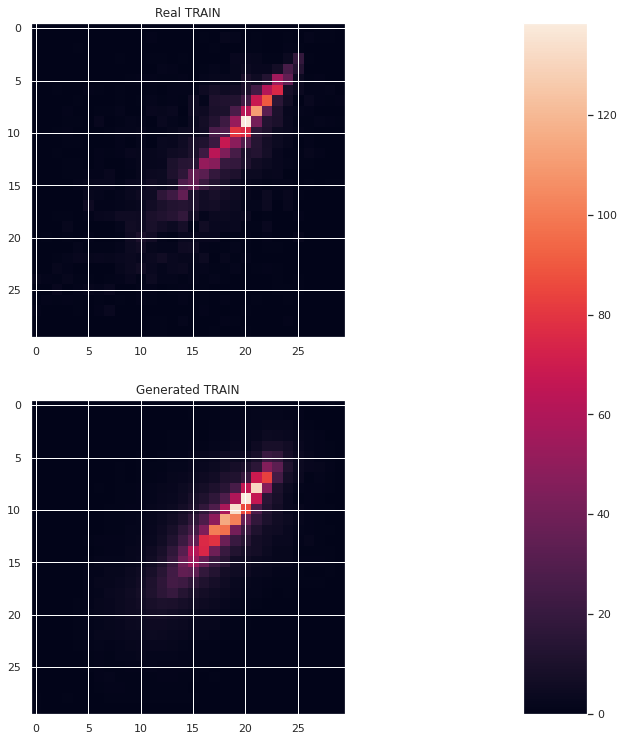

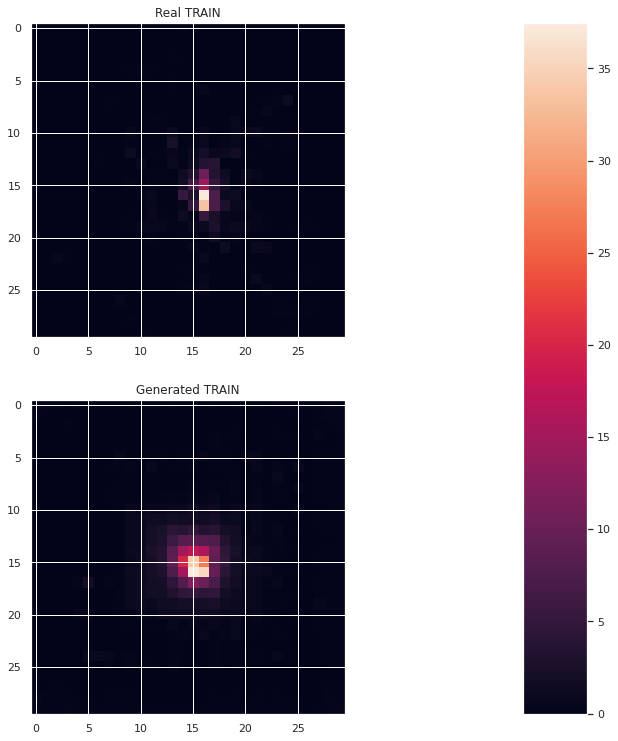

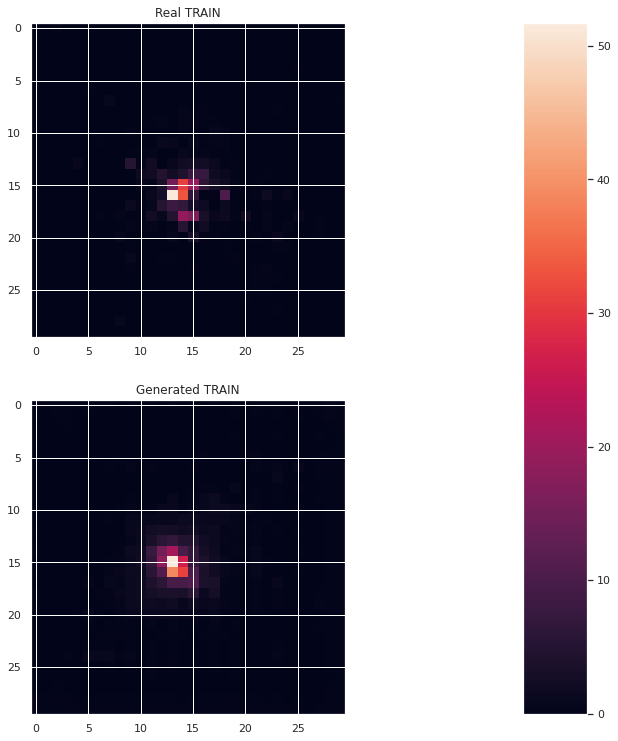

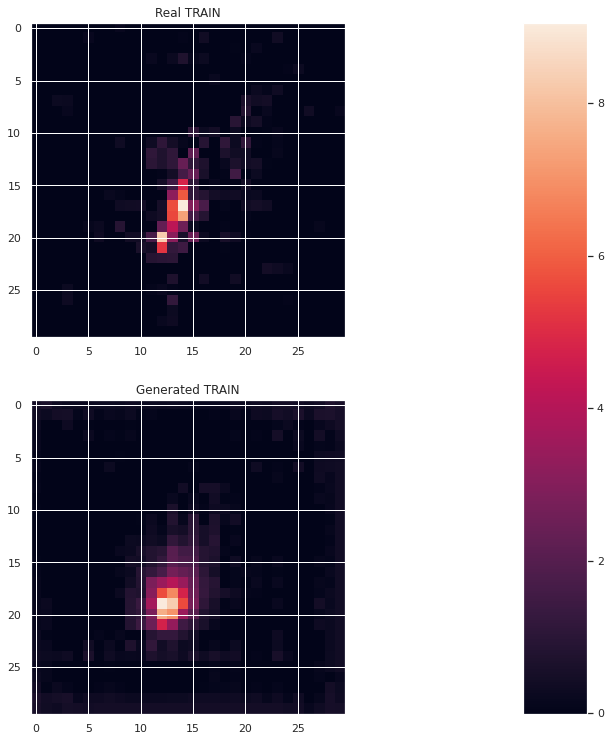

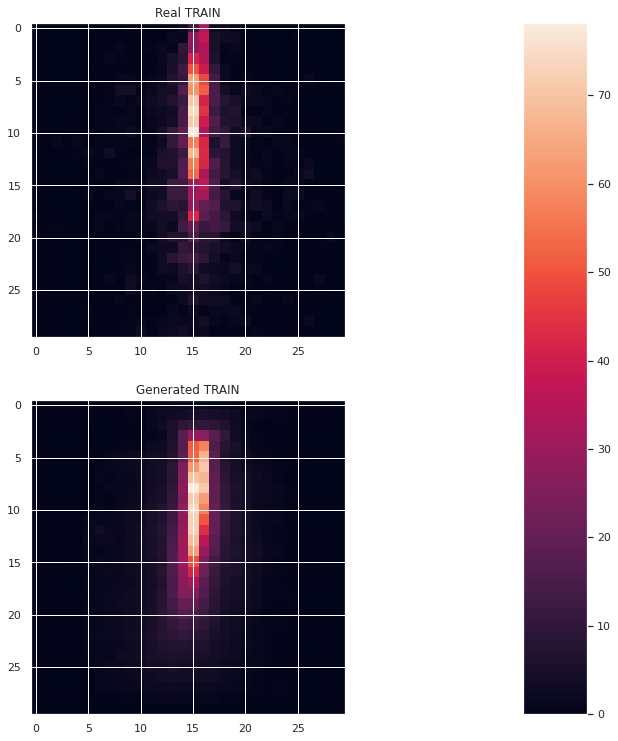

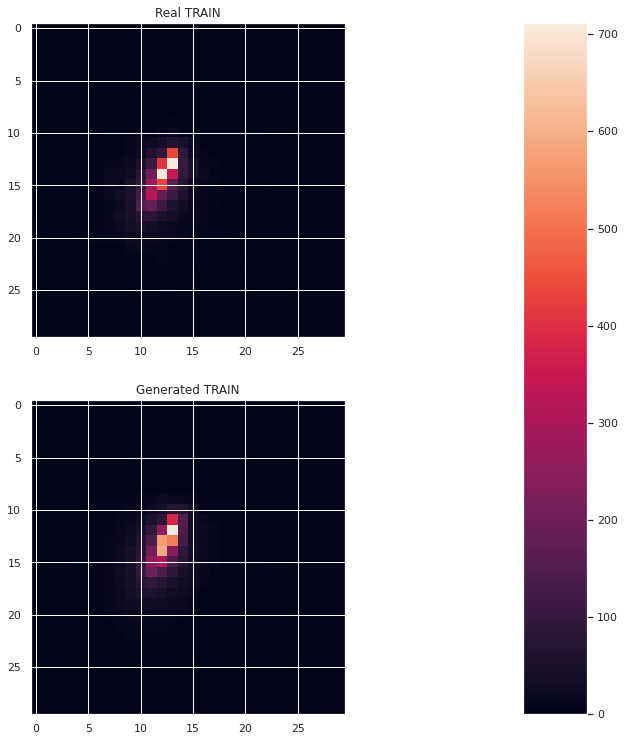

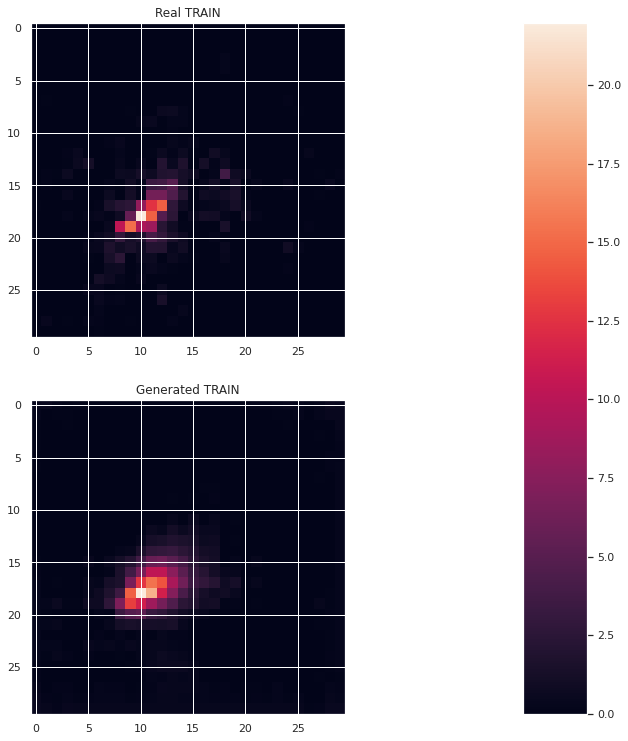

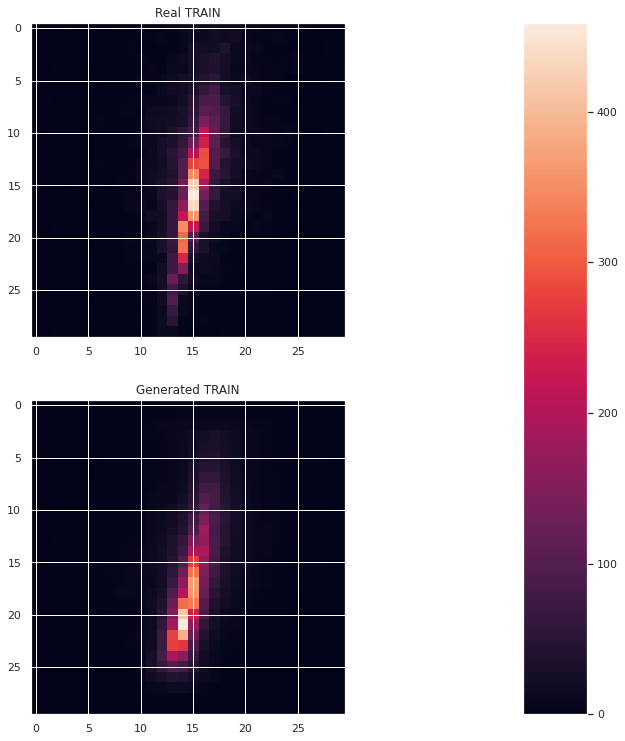

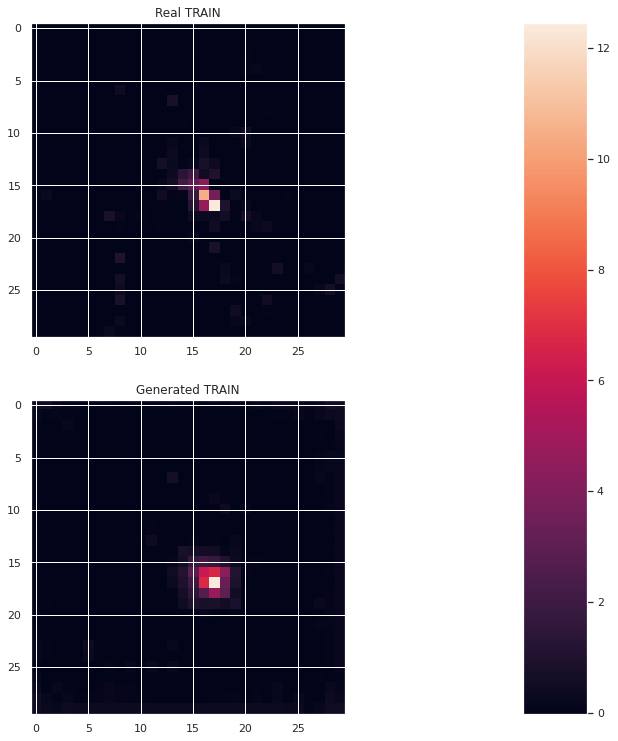

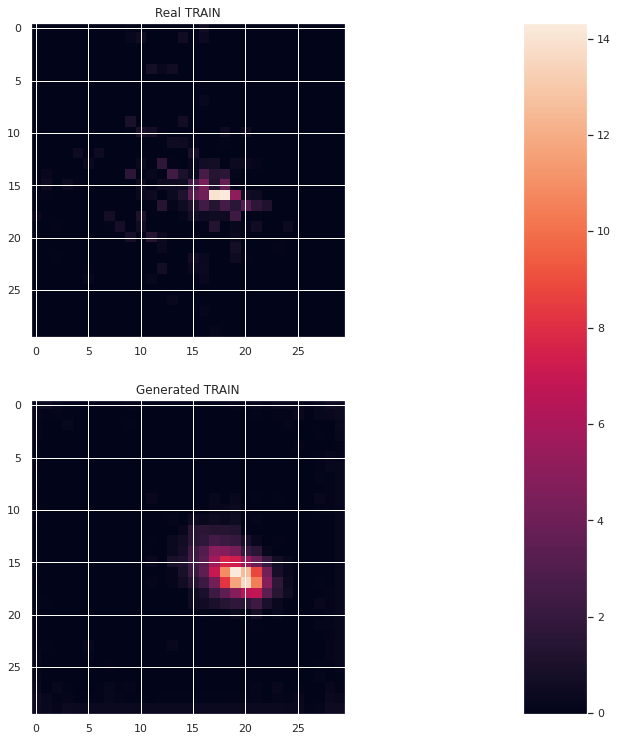

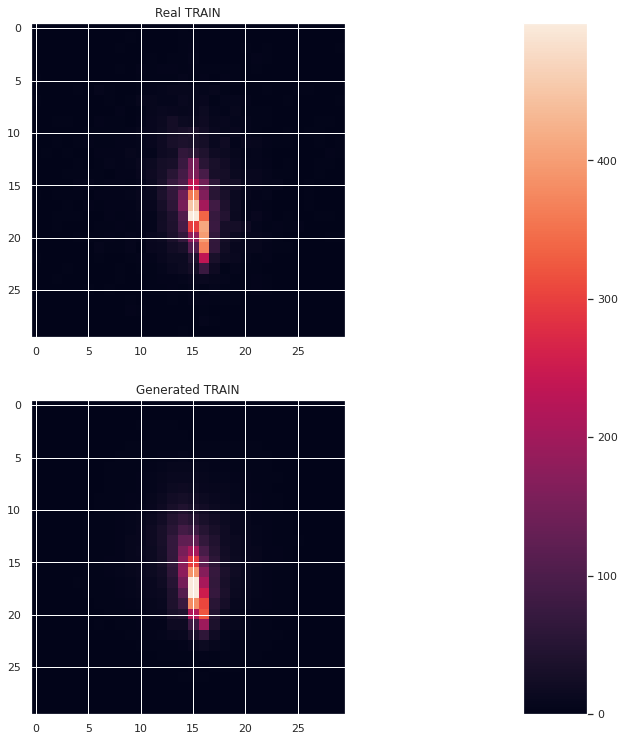

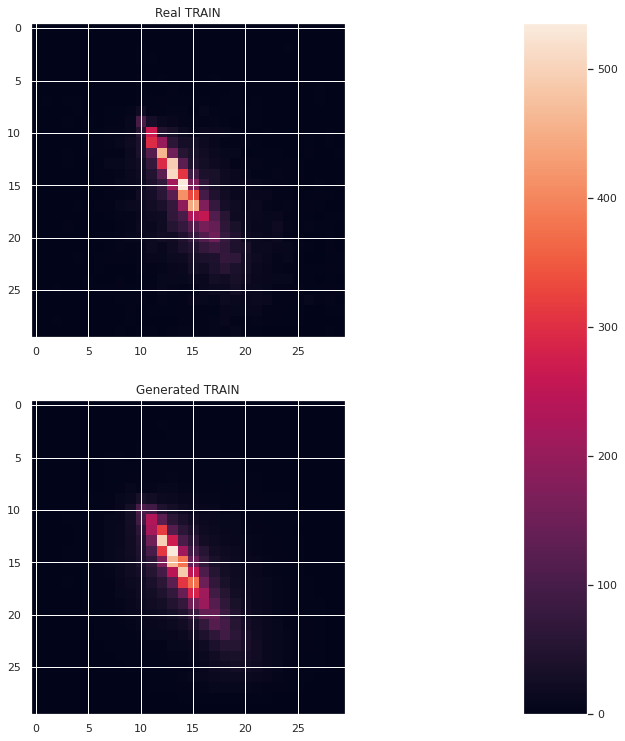

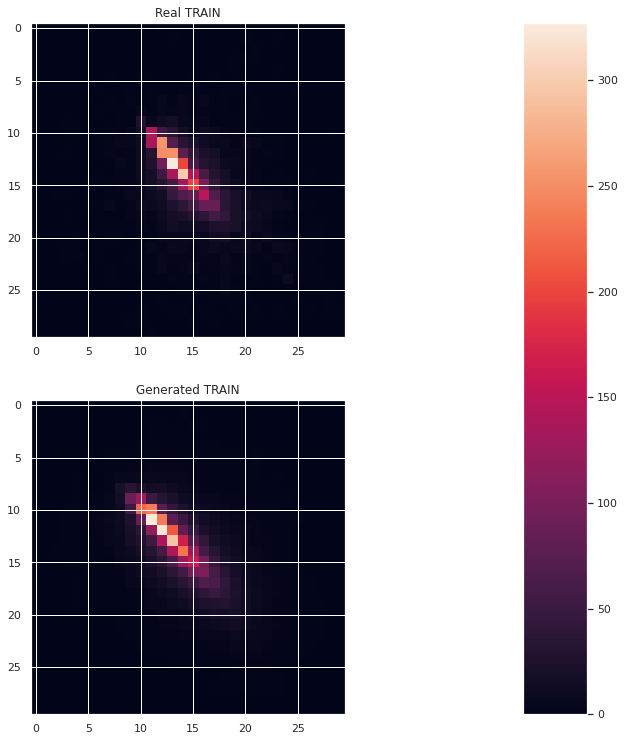

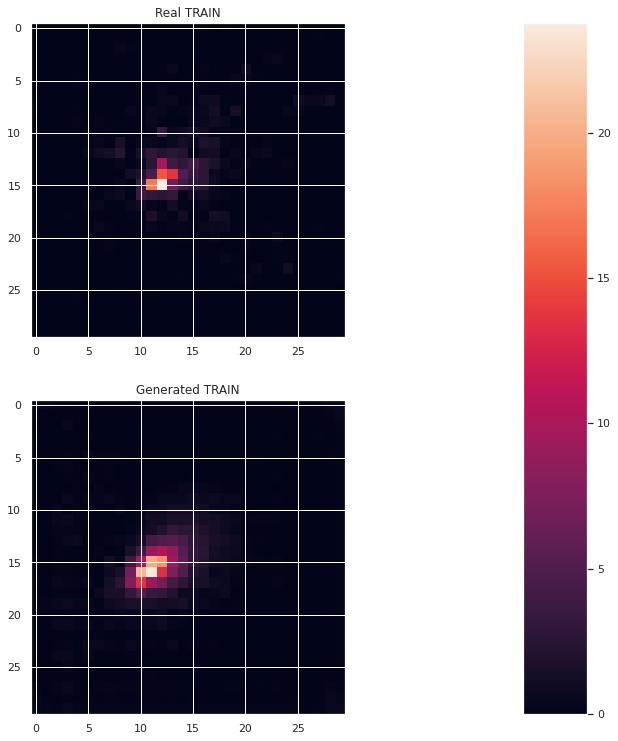

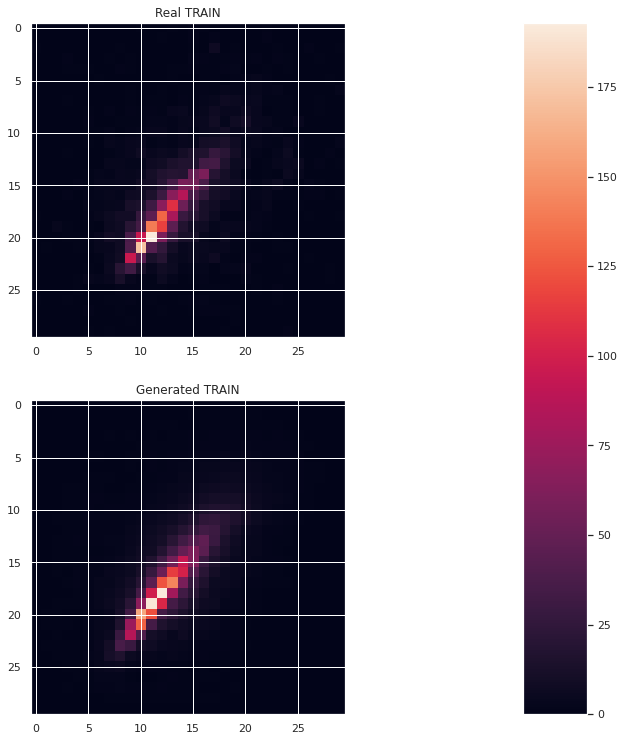

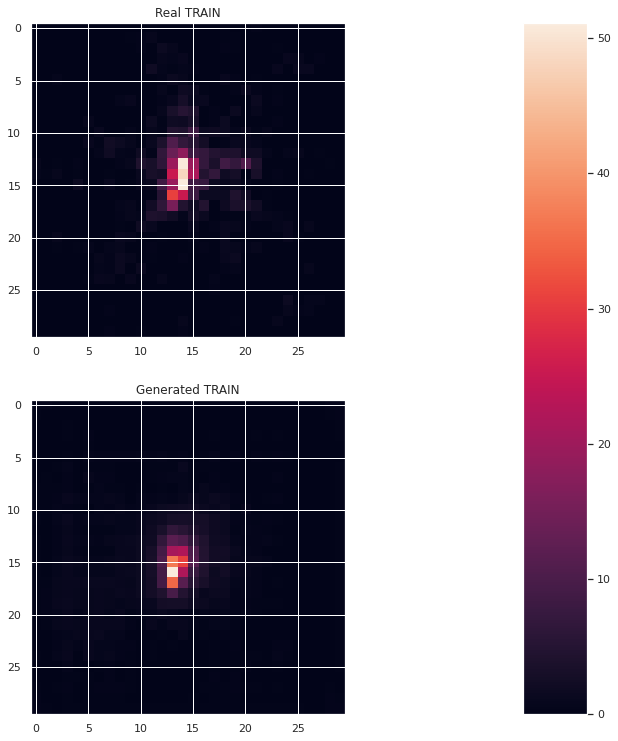

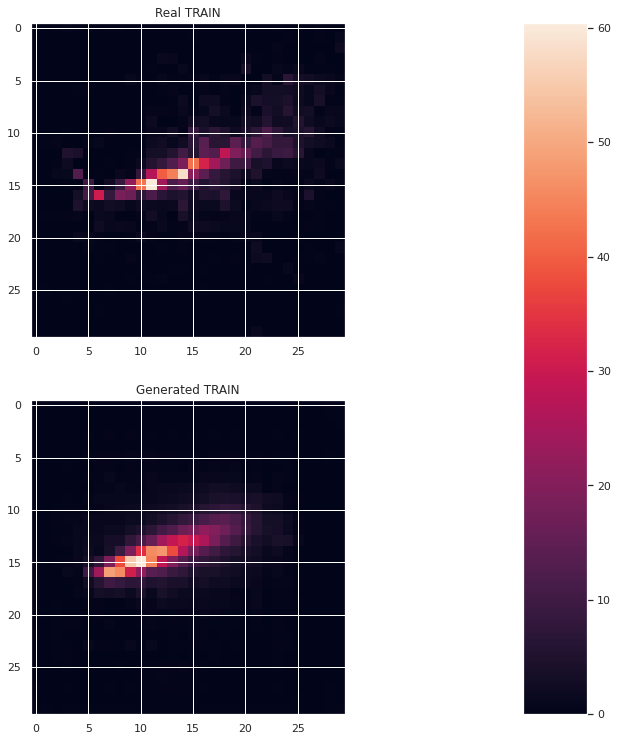

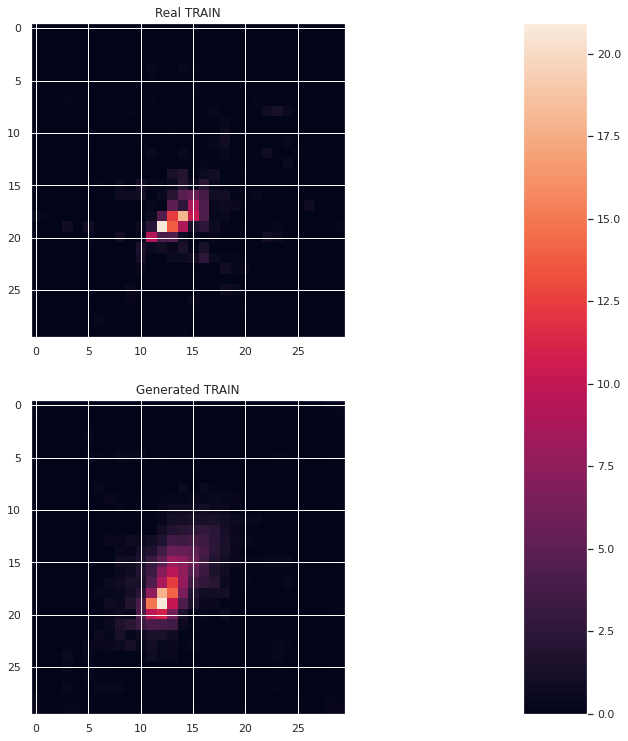

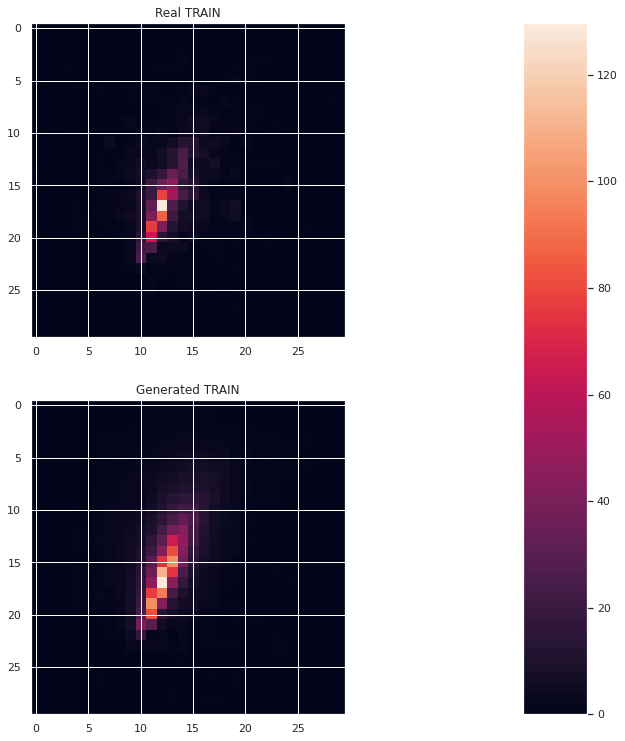

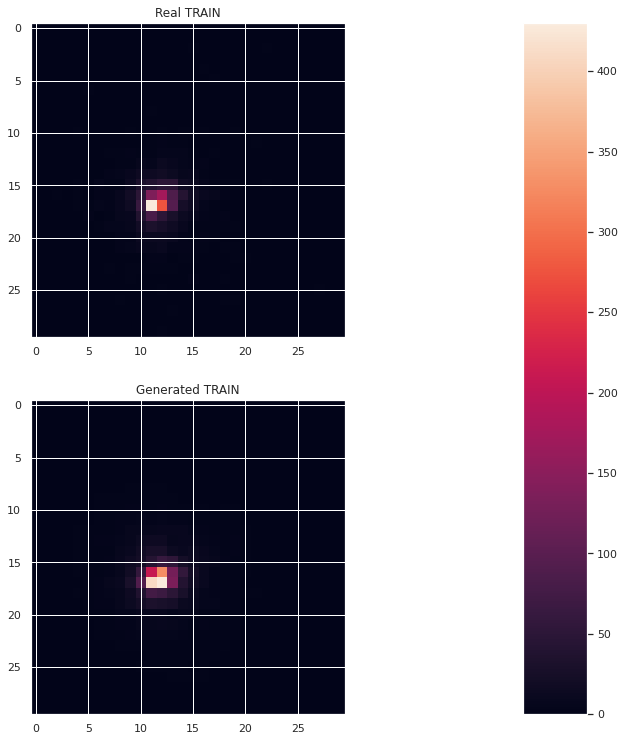

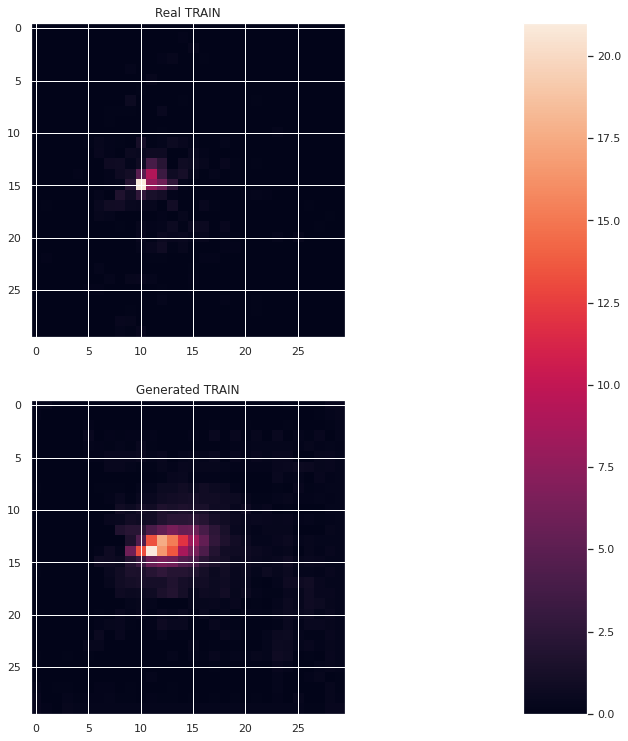

TRAIN ====> Epoch: 0  Average loss: 6.9922 RMSE: 6.8347705078125 KL: 0.15741233332240168


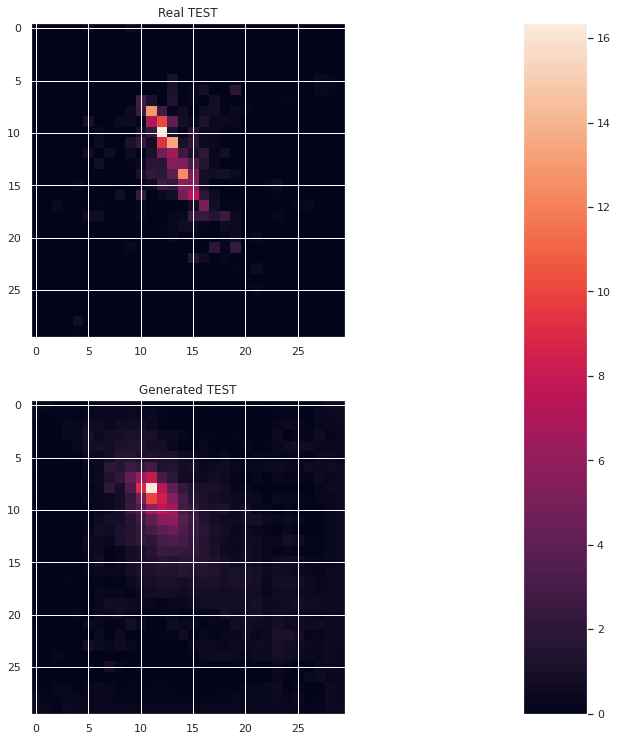

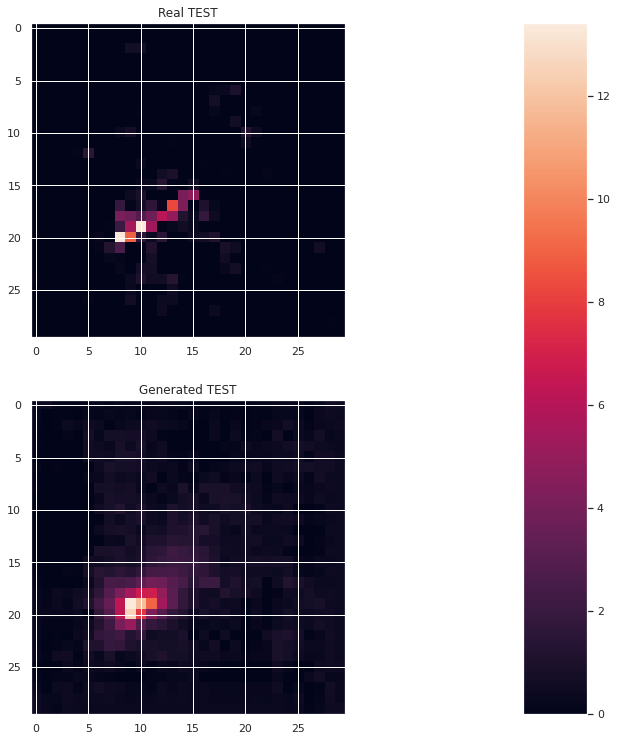

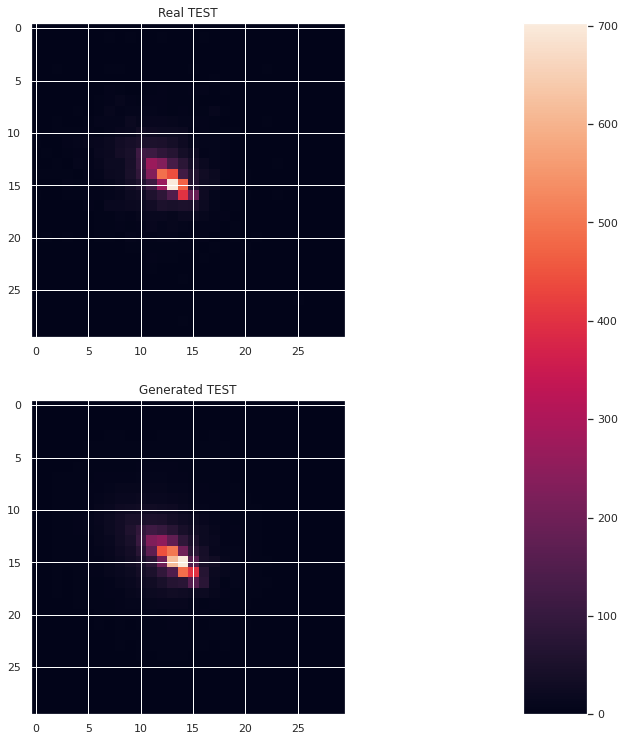

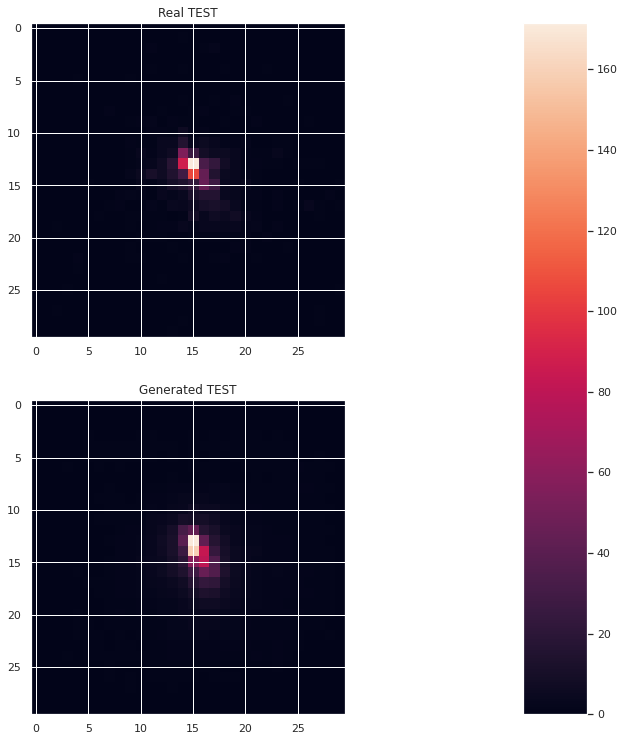

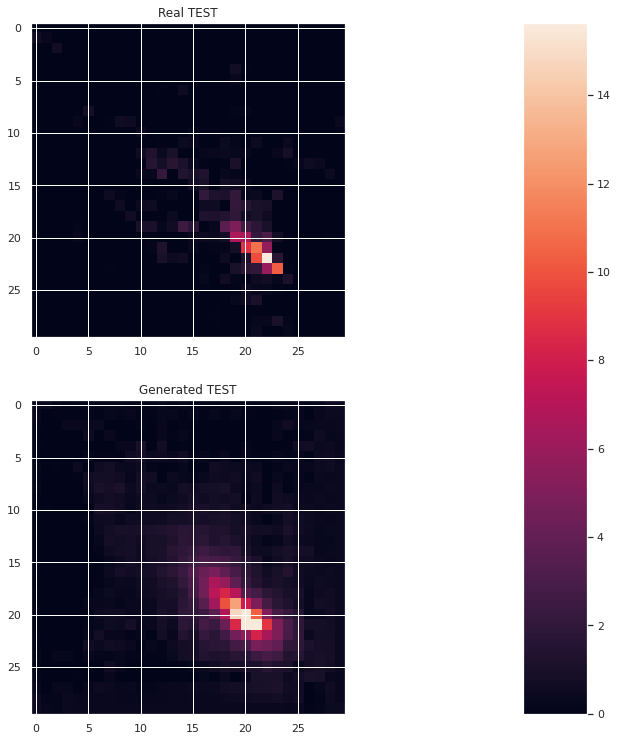

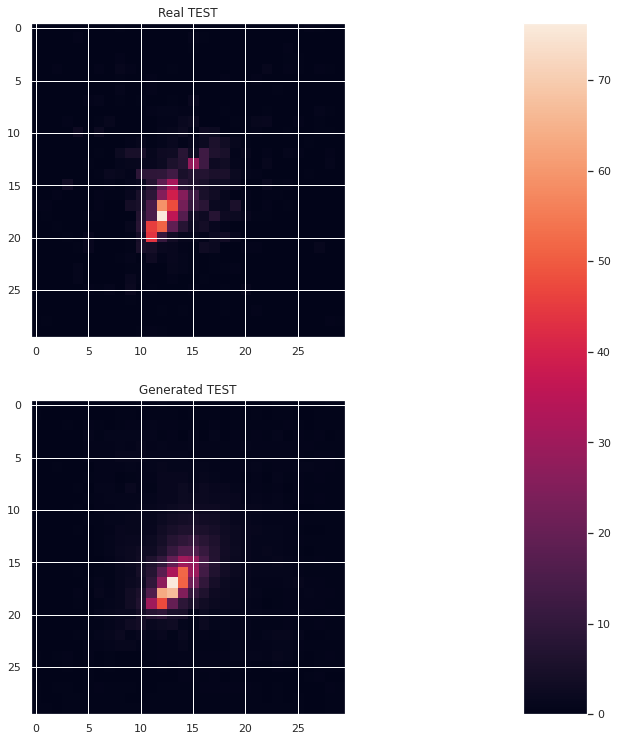

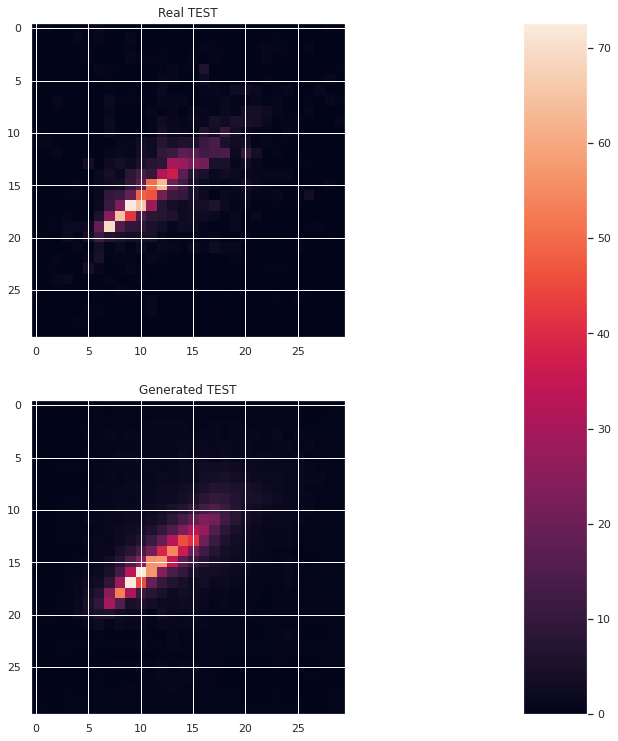

TEST ====> Epoch: 0 Average loss: 7.0676 RMSE: 6.908216728855721 KL: 0.15937511842642257


In [0]:
for epoch in range(1): #5
  train(epoch)
  test(epoch)

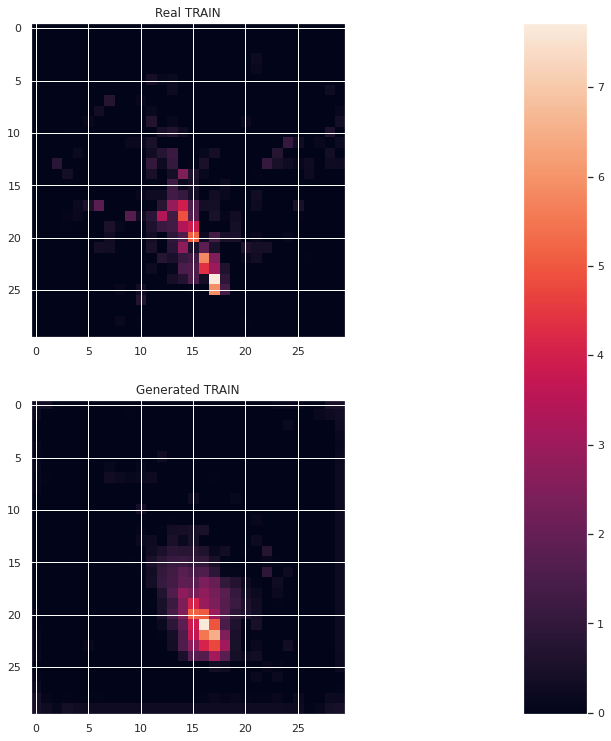

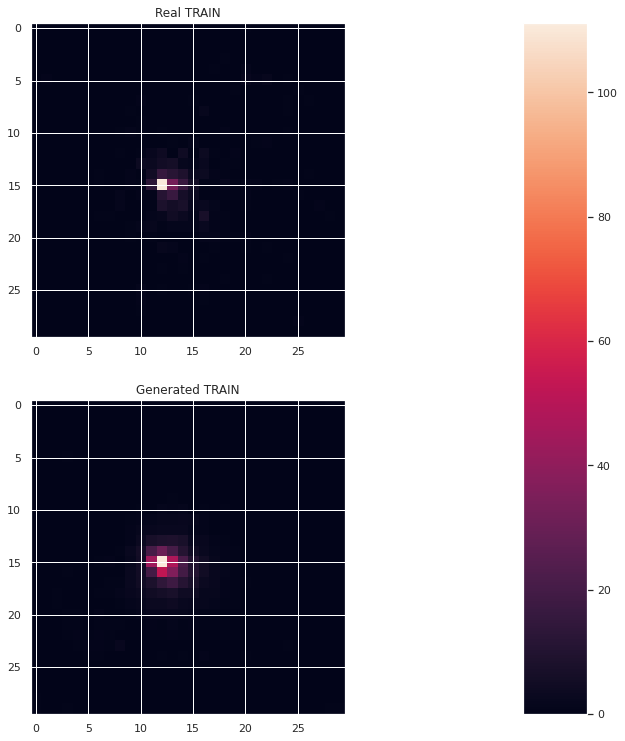

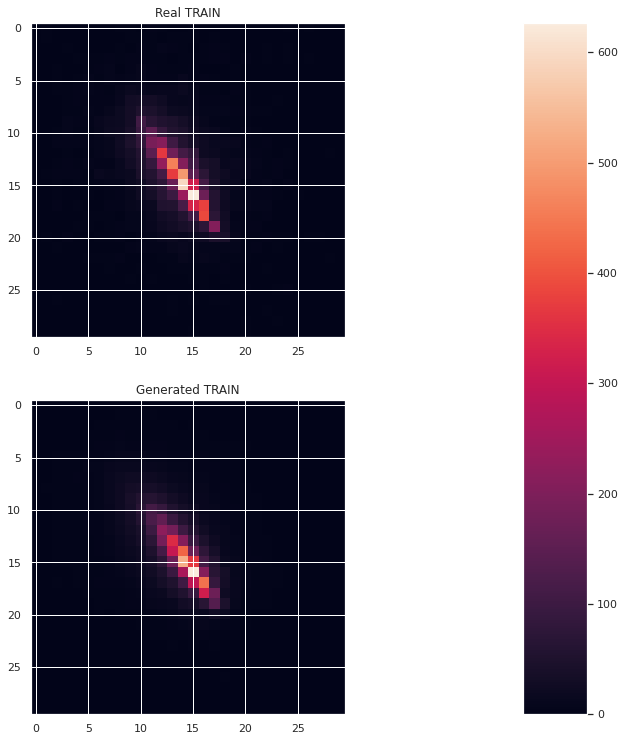

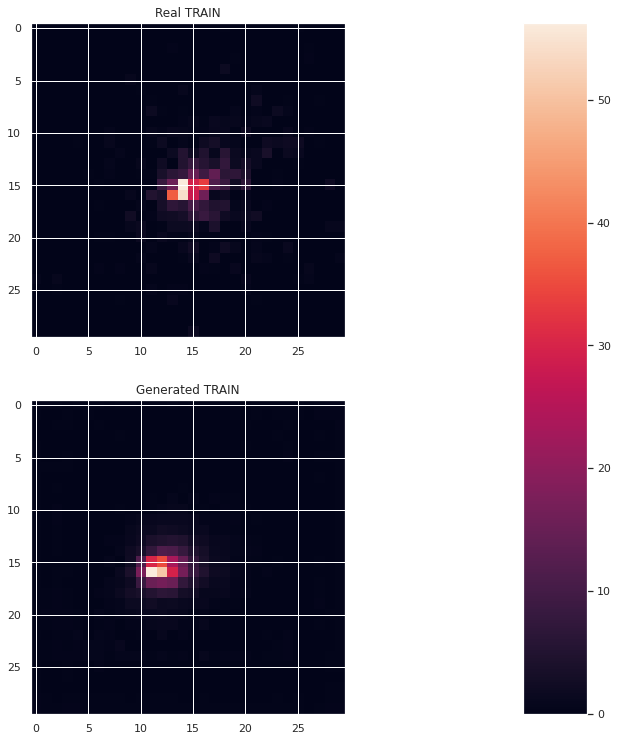

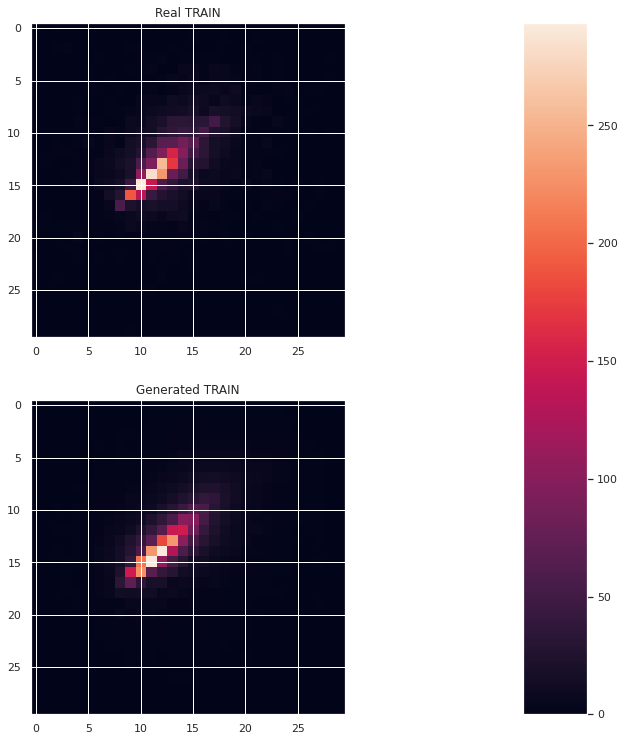

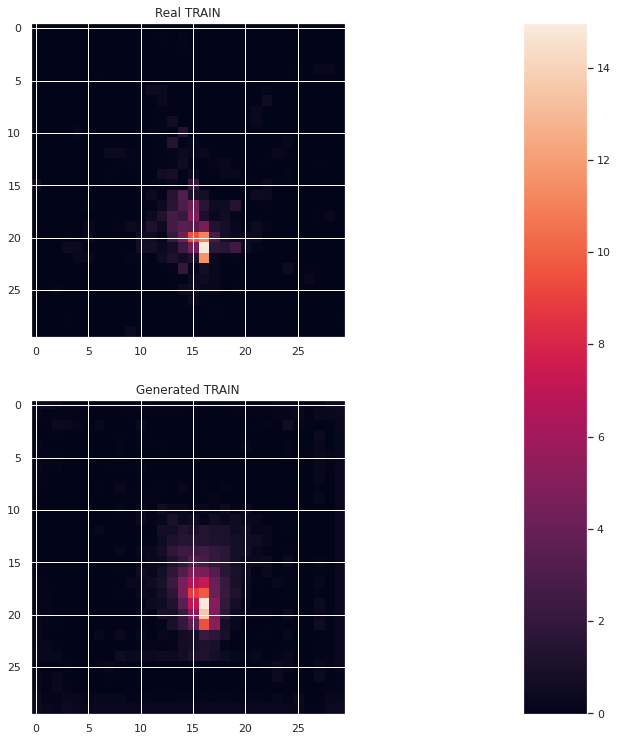

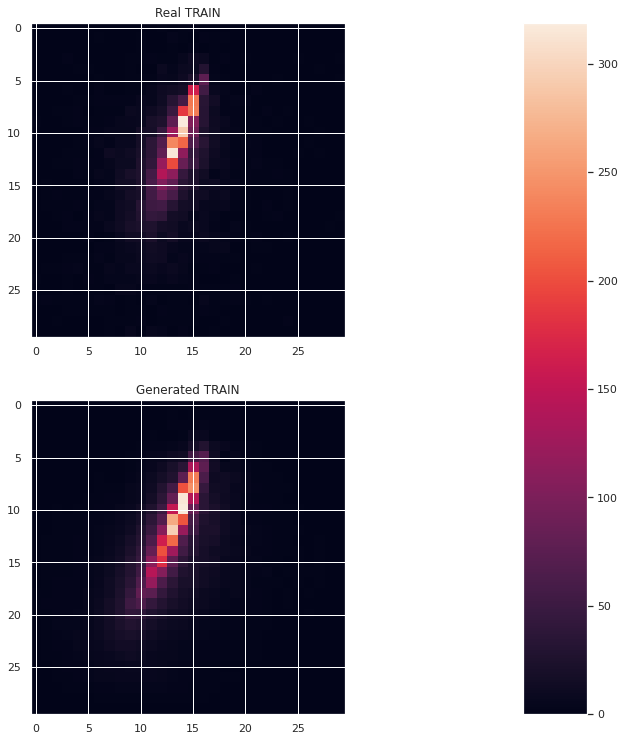

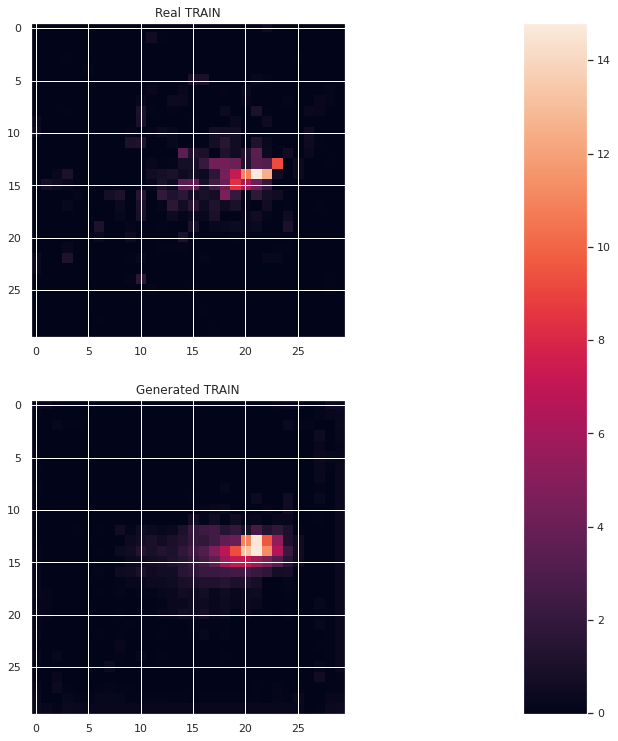

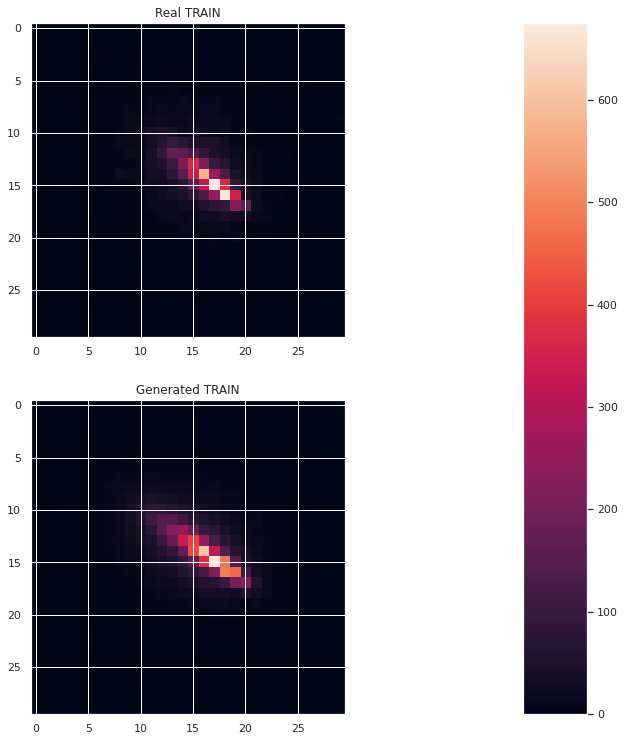

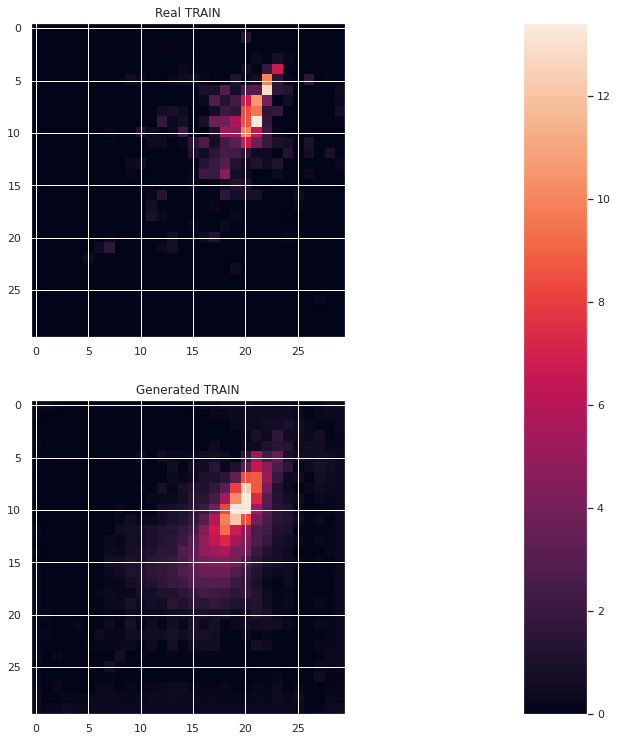

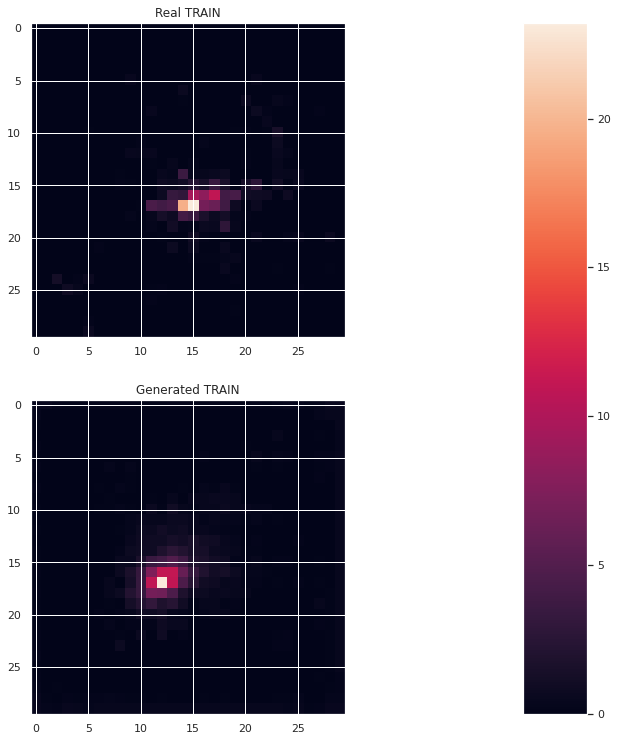

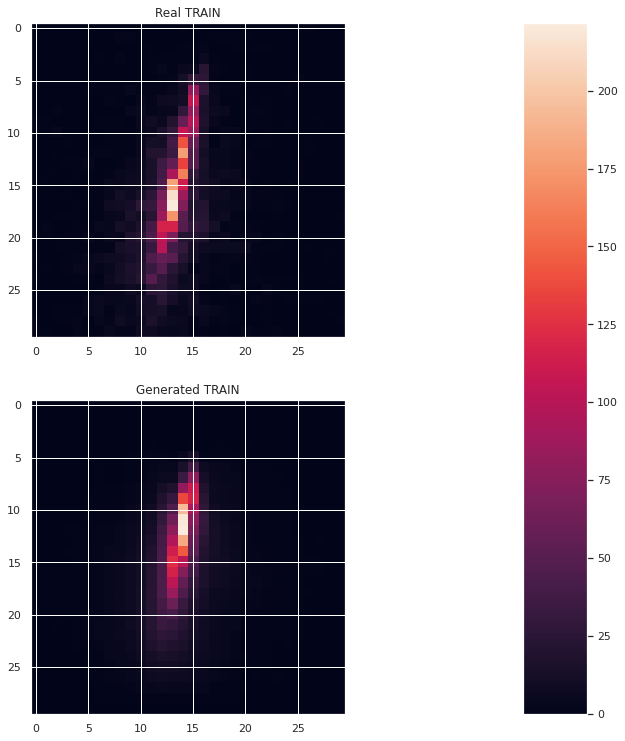

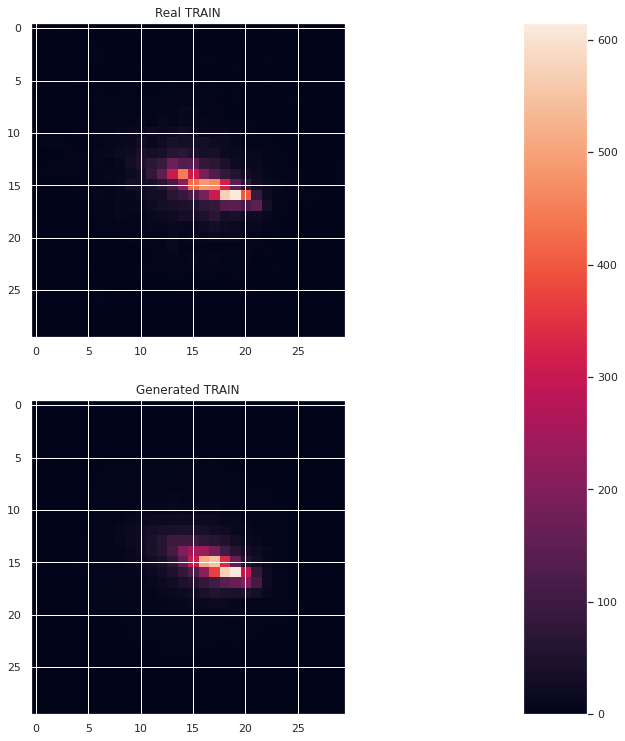

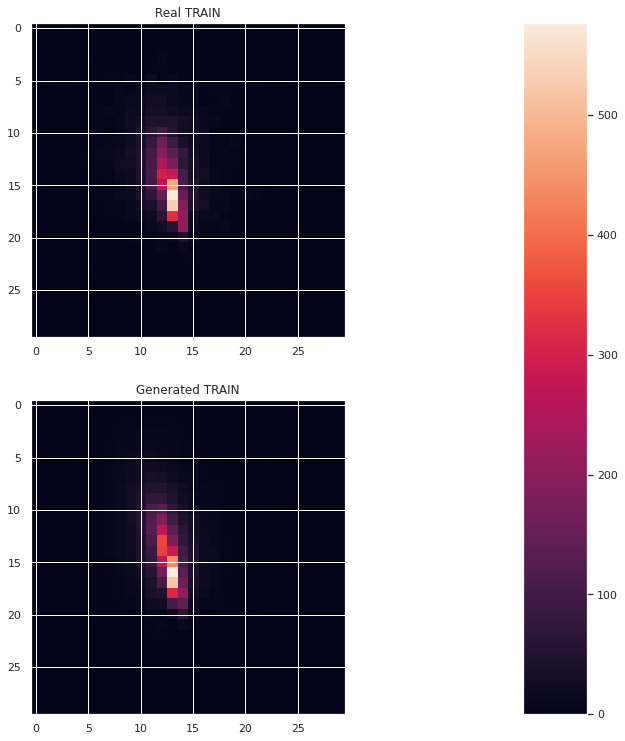

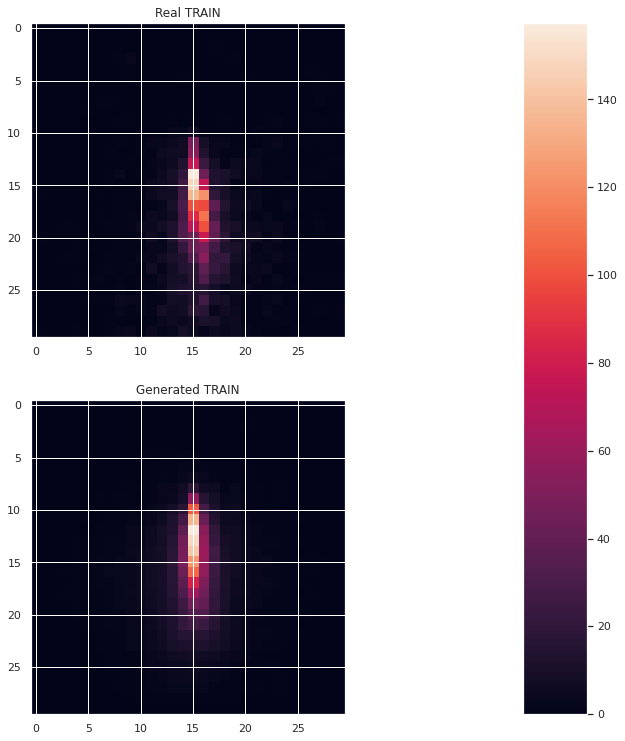

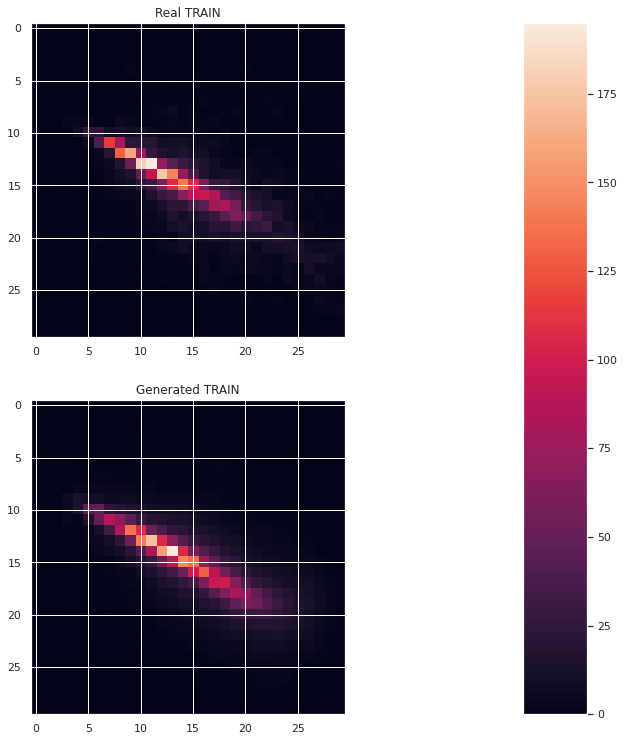

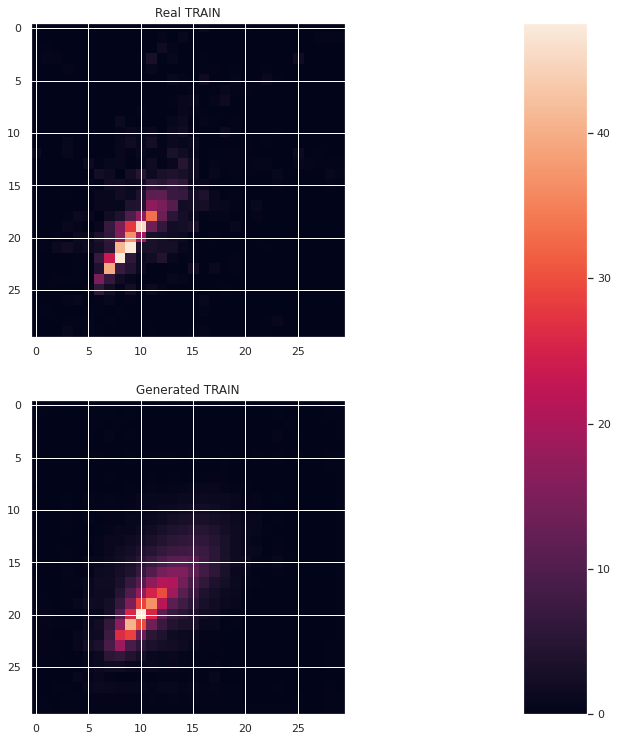

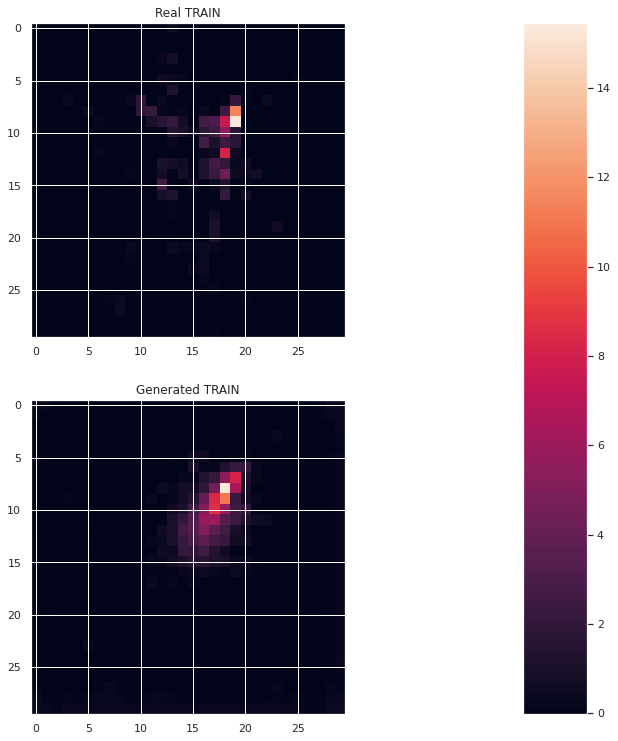

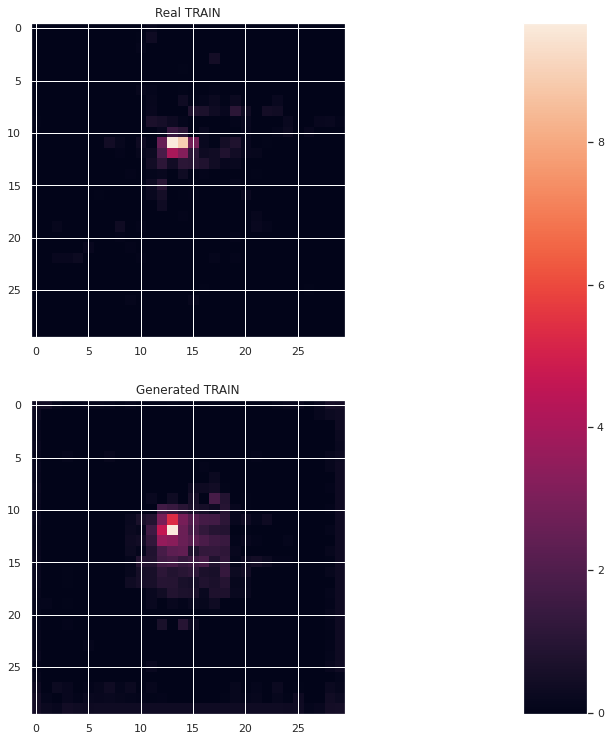

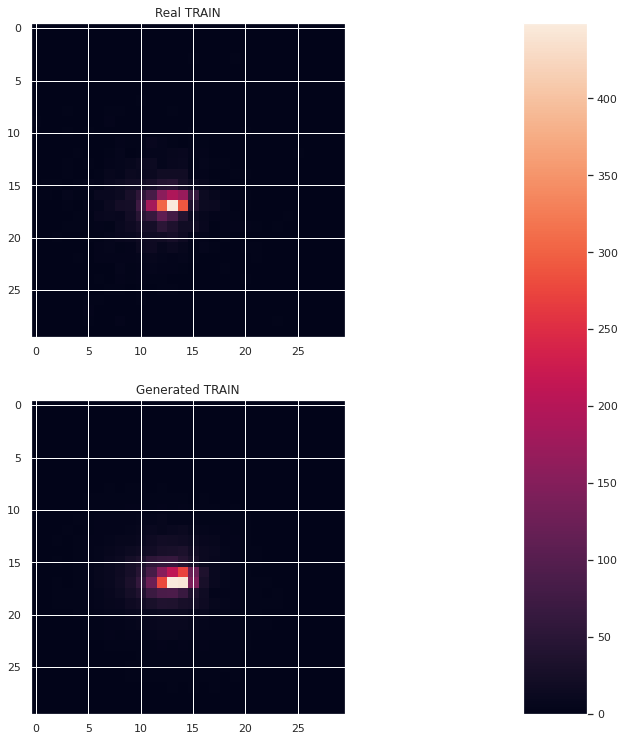

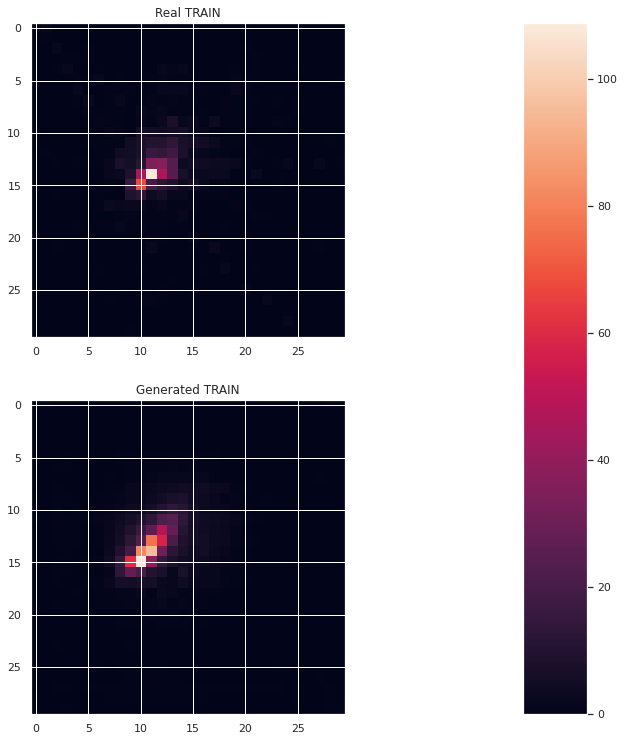

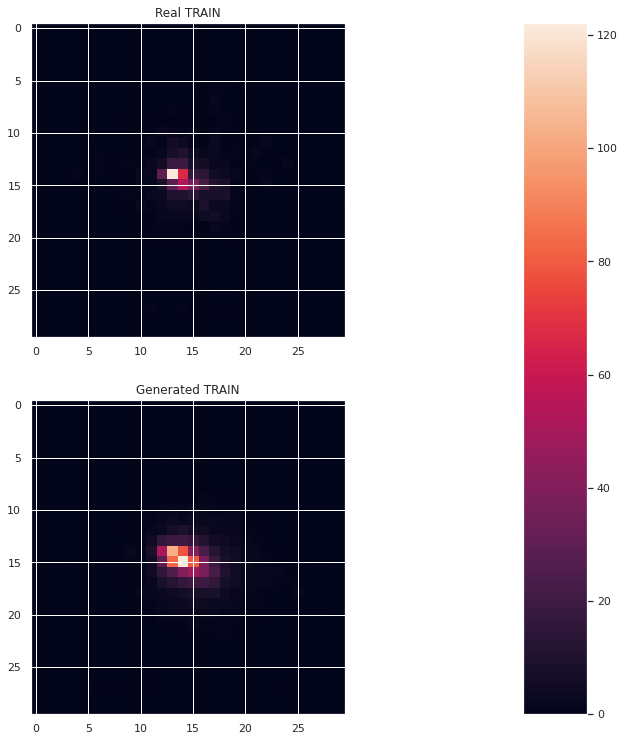

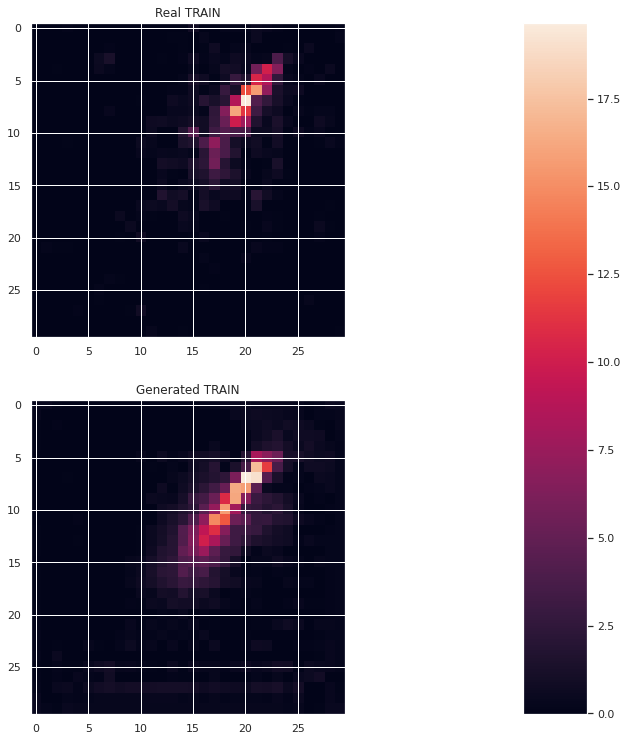

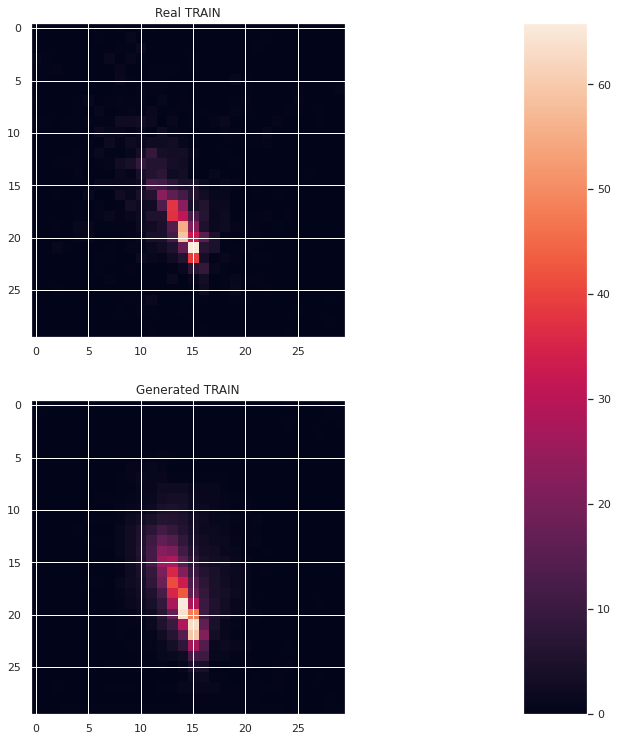

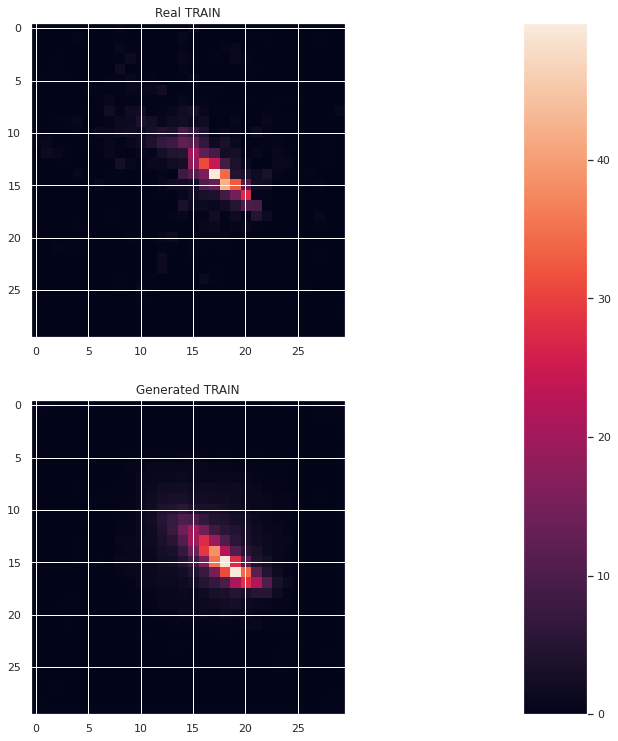

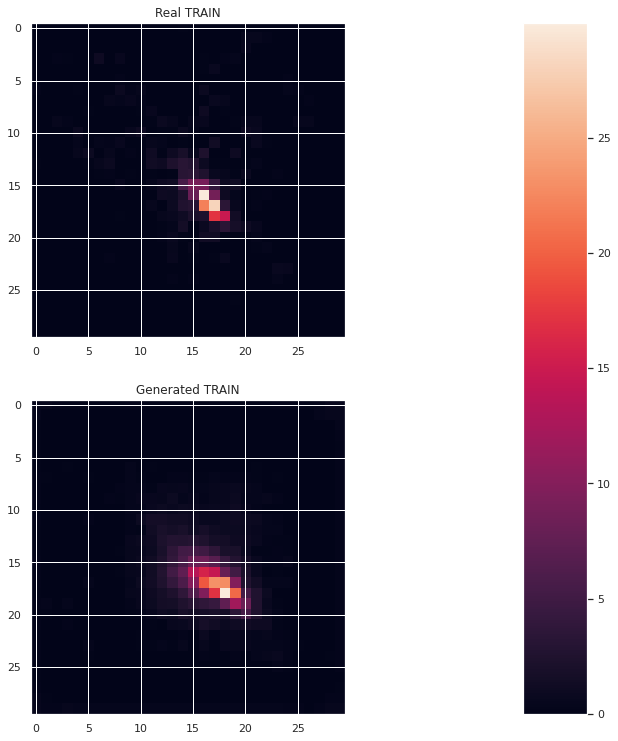

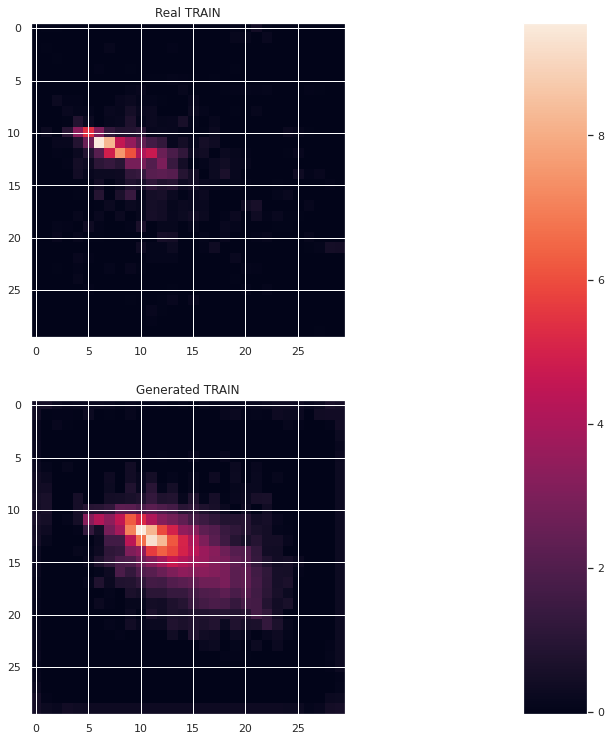

TRAIN ====> Epoch: 0  Average loss: 6.8566 RMSE: 6.705685731498757 KL: 0.15093000725134095


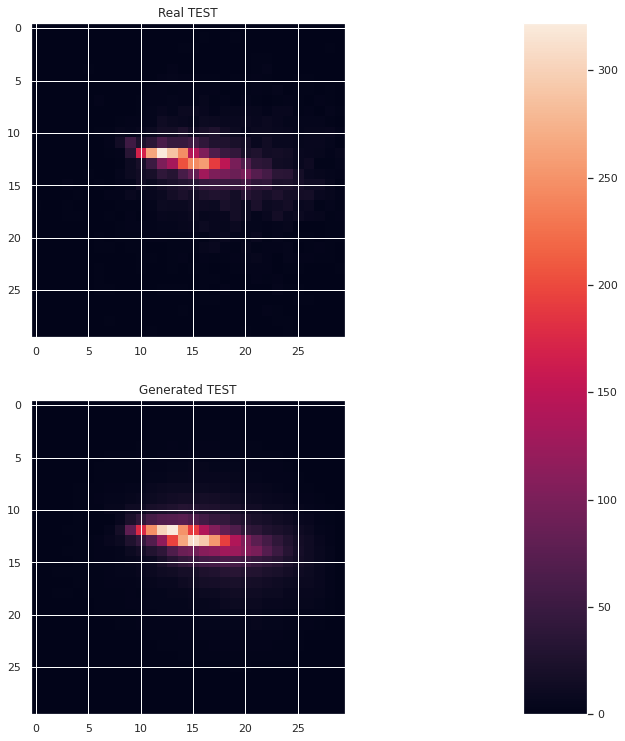

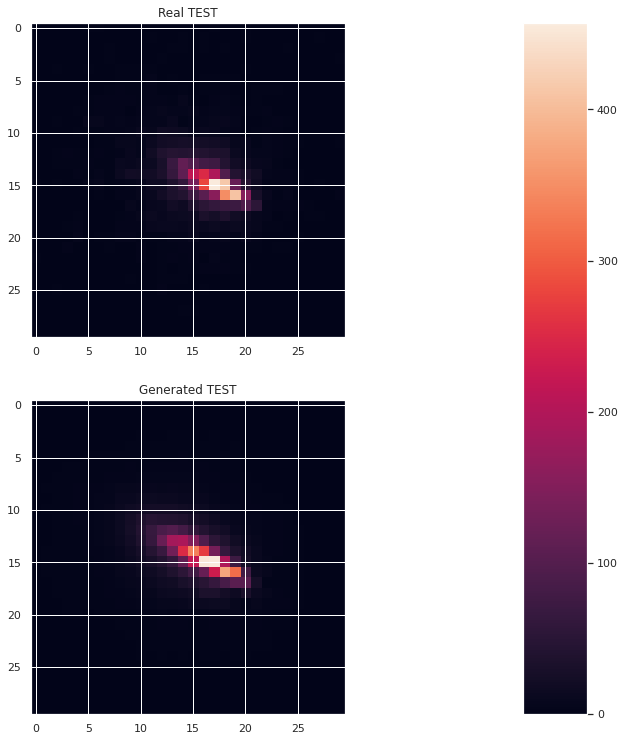

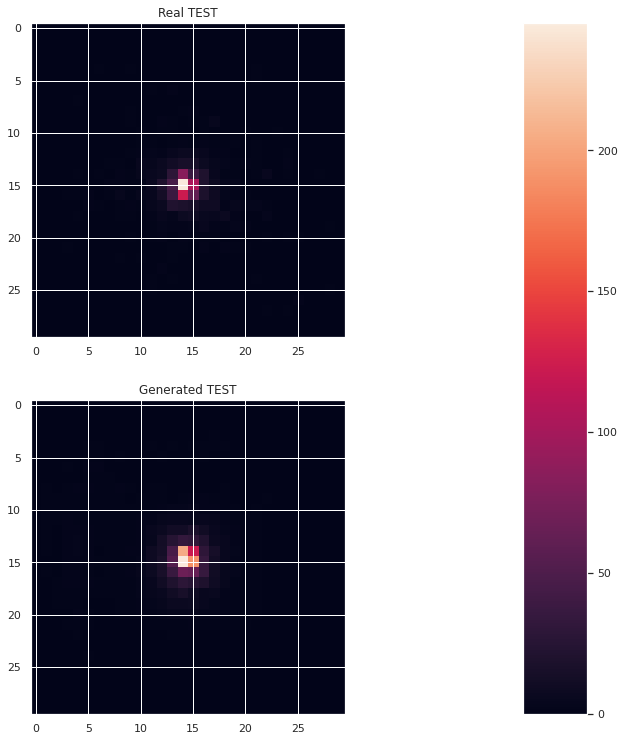

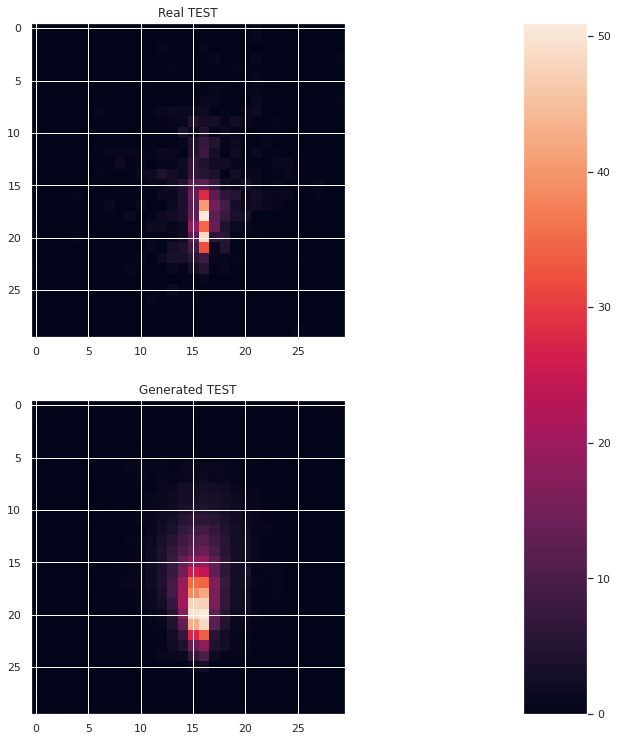

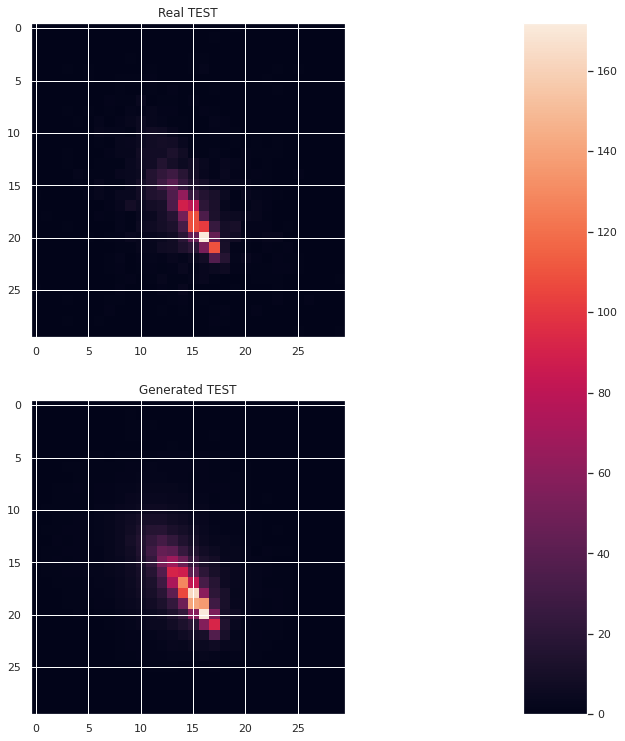

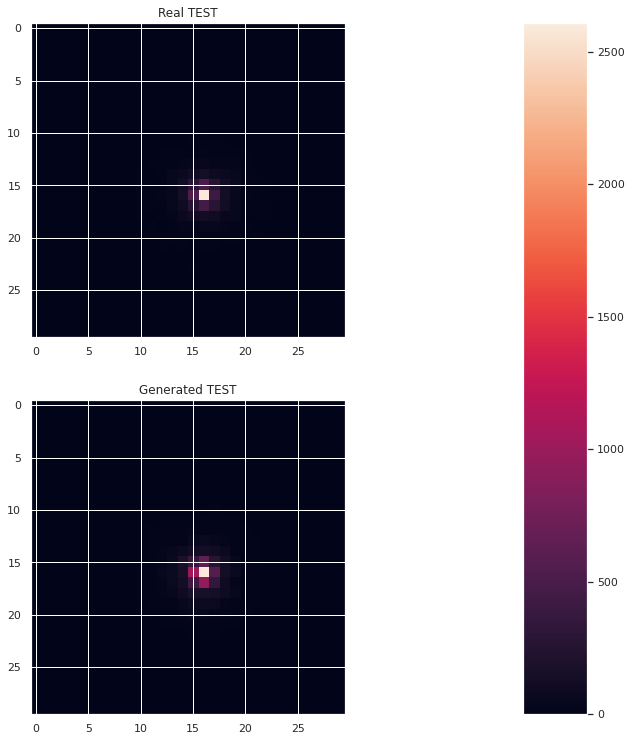

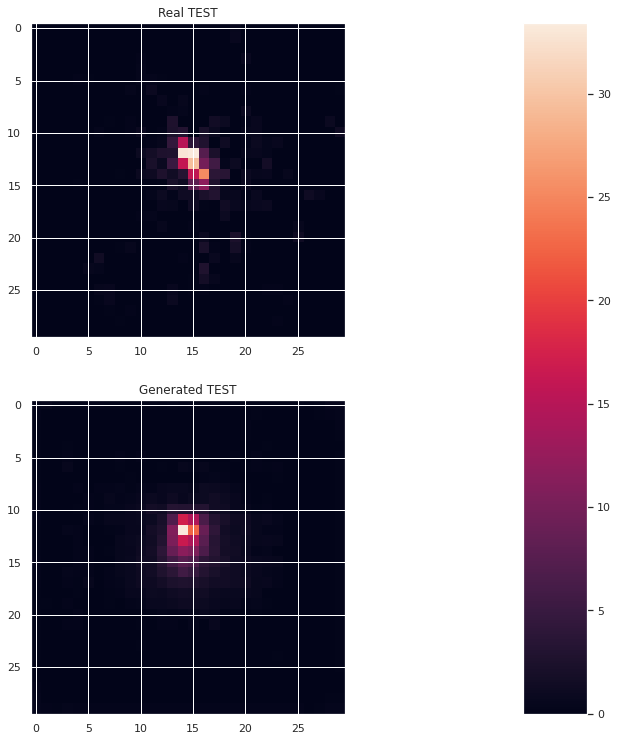

TEST ====> Epoch: 0 Average loss: 7.0336 RMSE: 6.878681883550995 KL: 0.15493403496433847


In [0]:
for epoch in range(1): #6
  train(epoch)
  test(epoch)

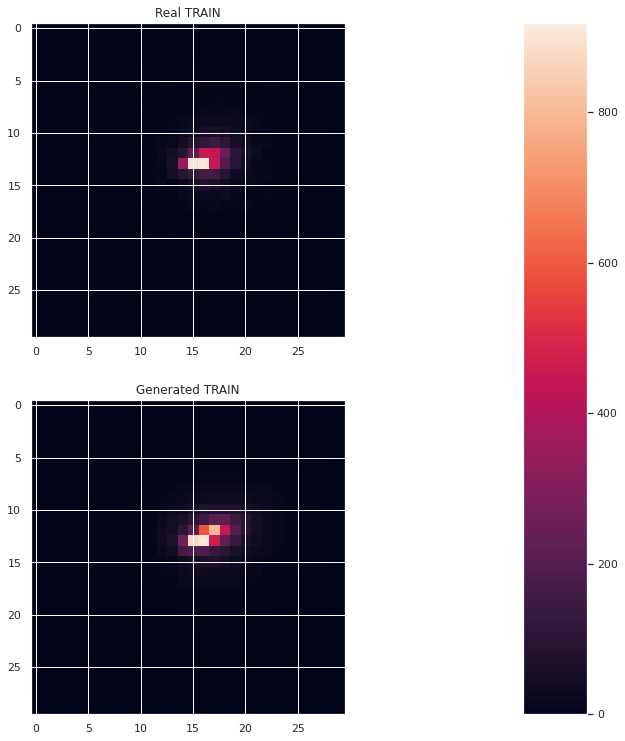

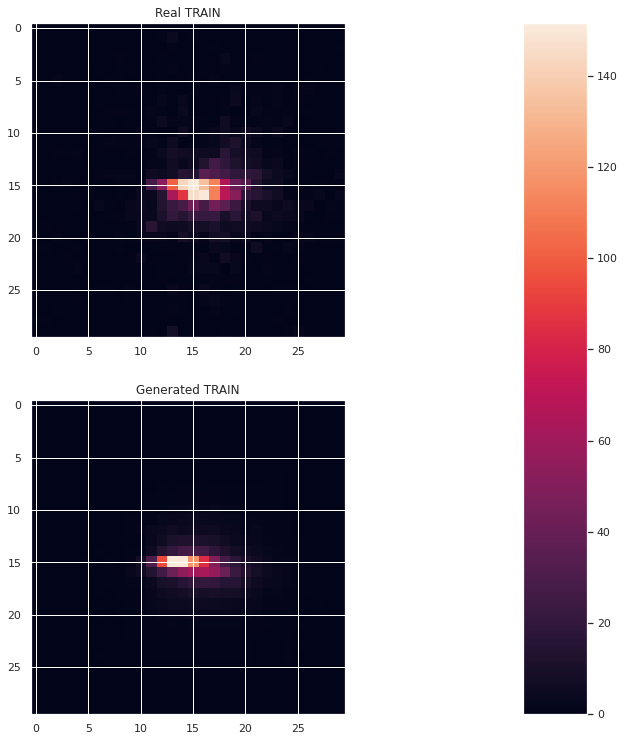

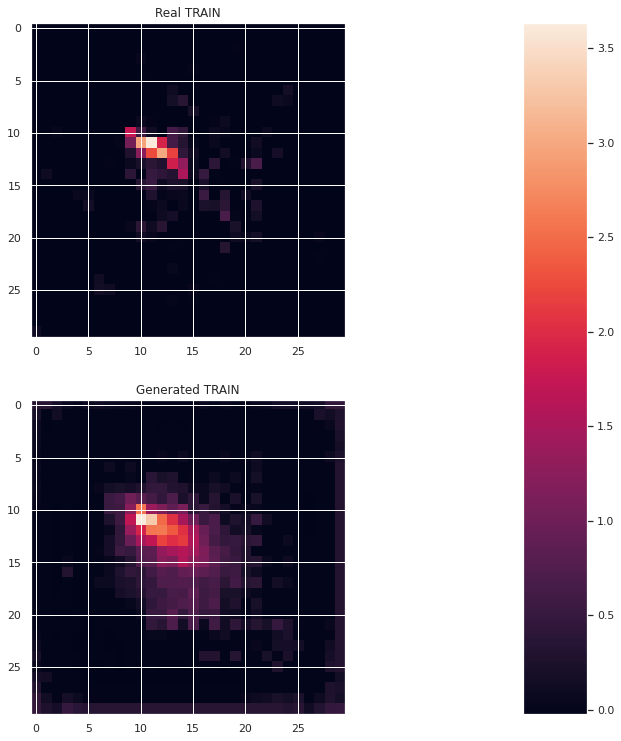

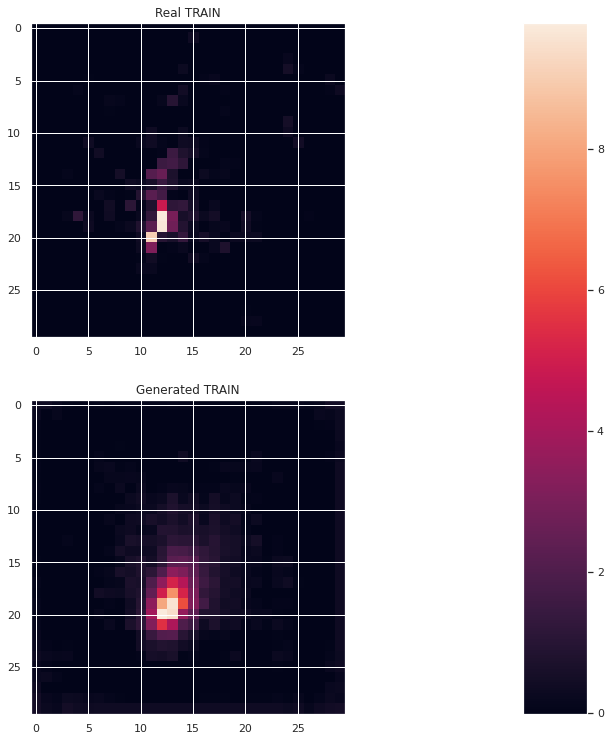

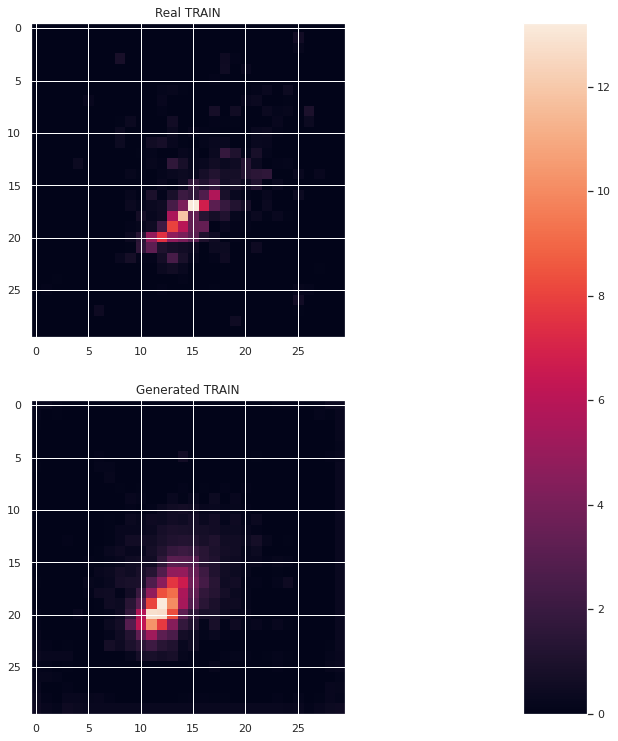

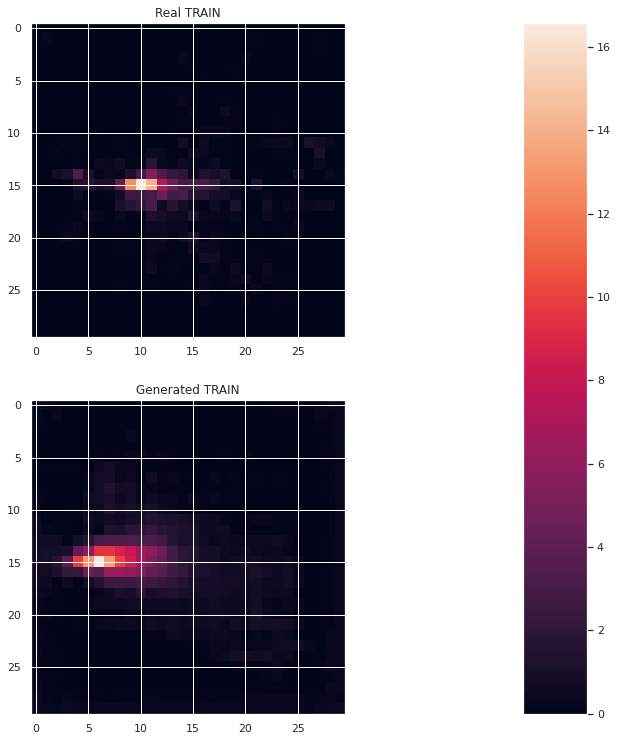

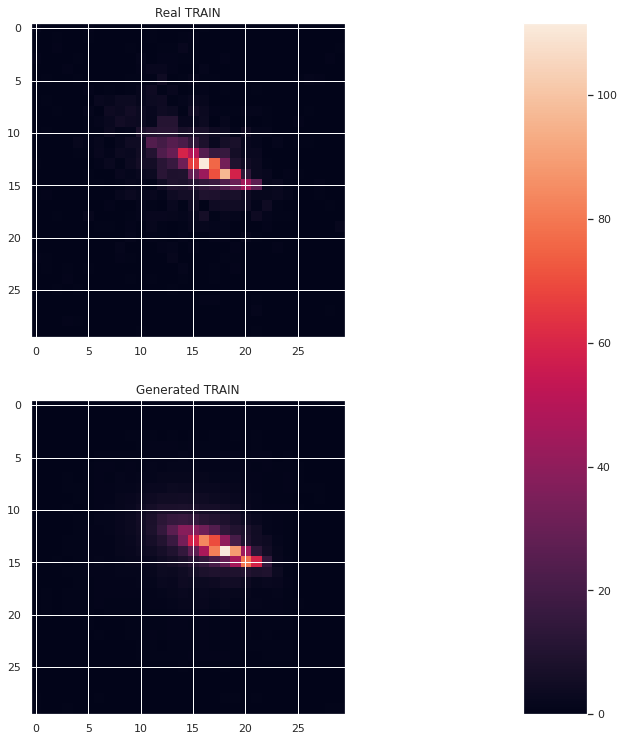

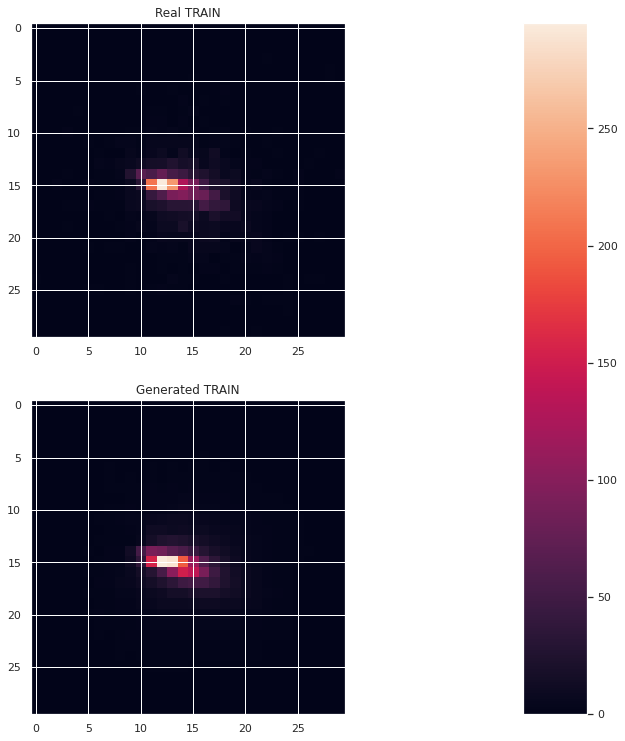

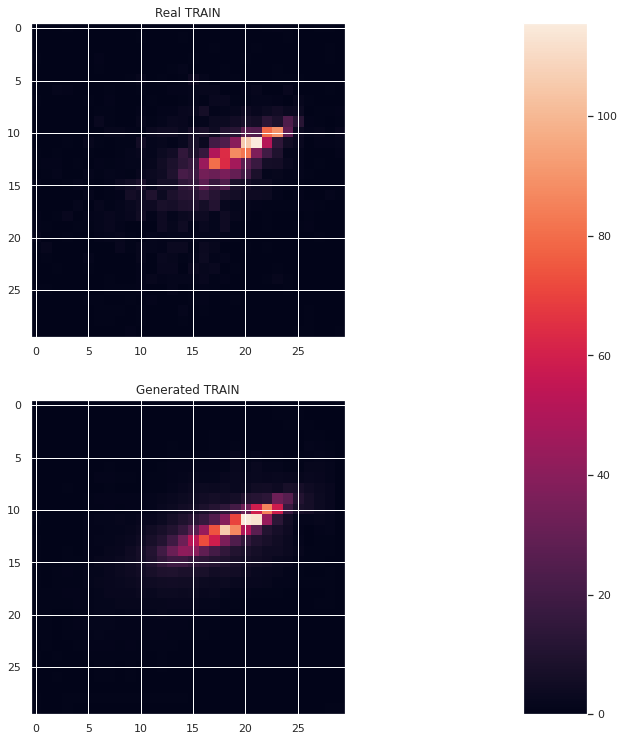

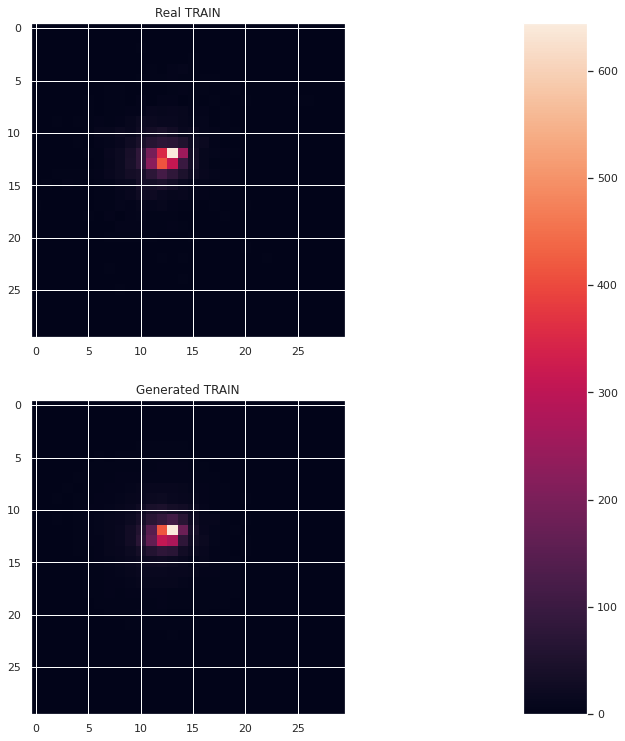

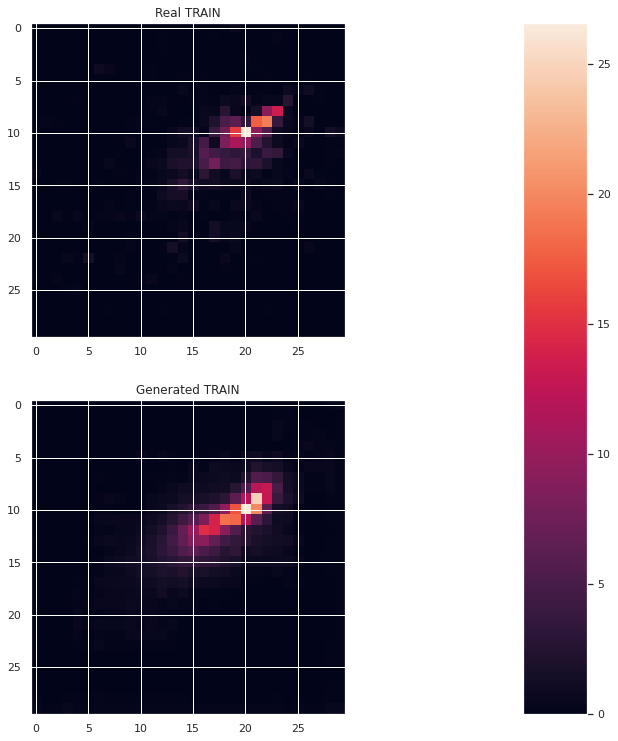

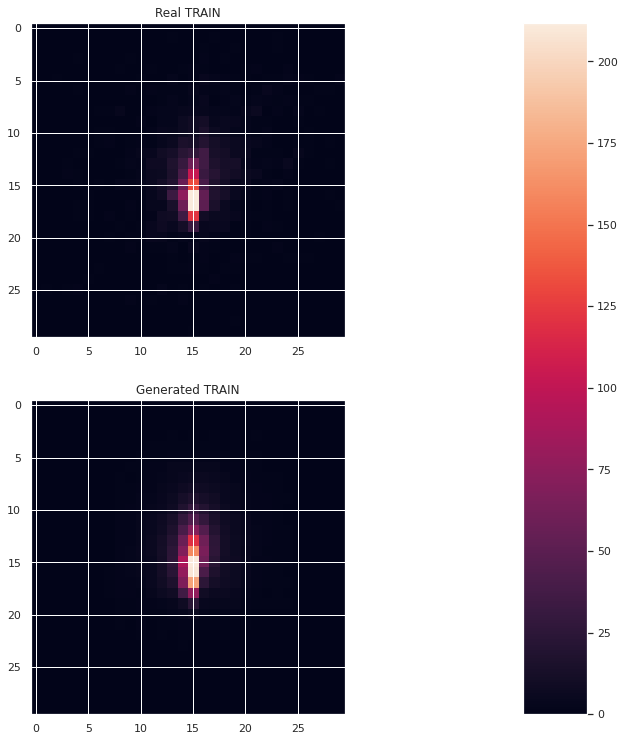

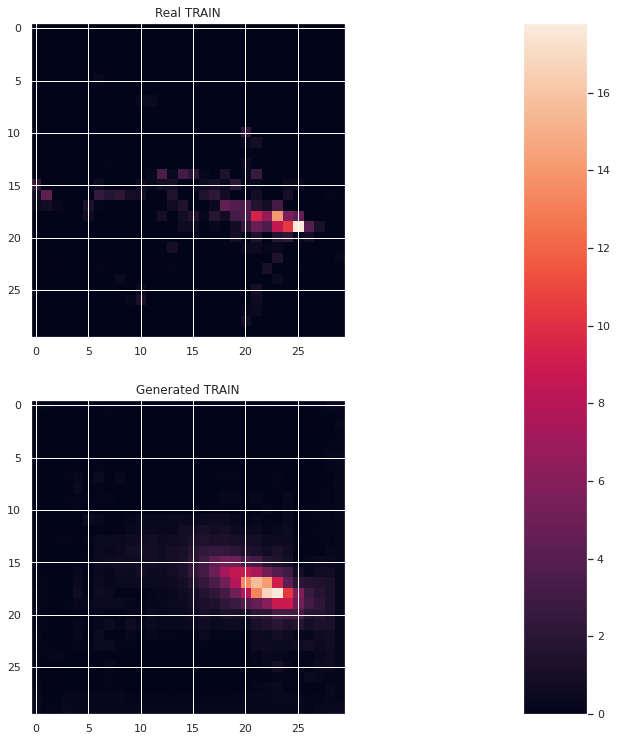

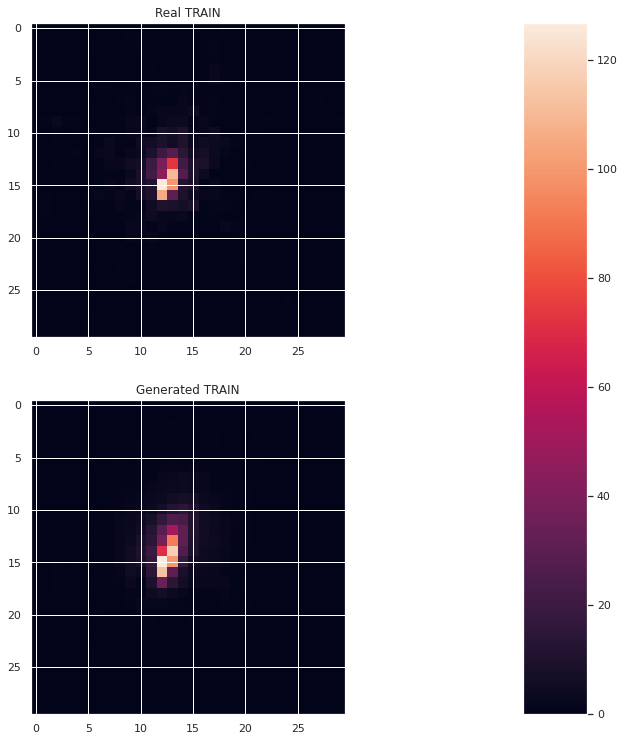

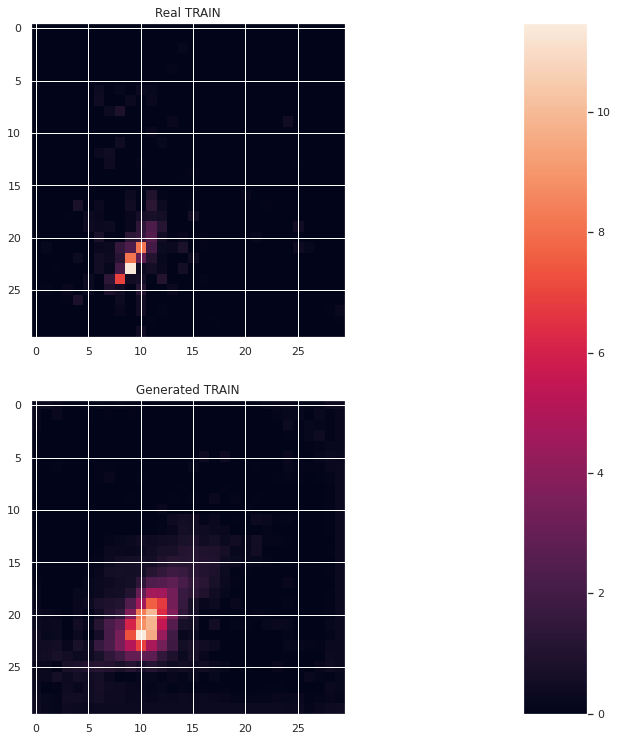

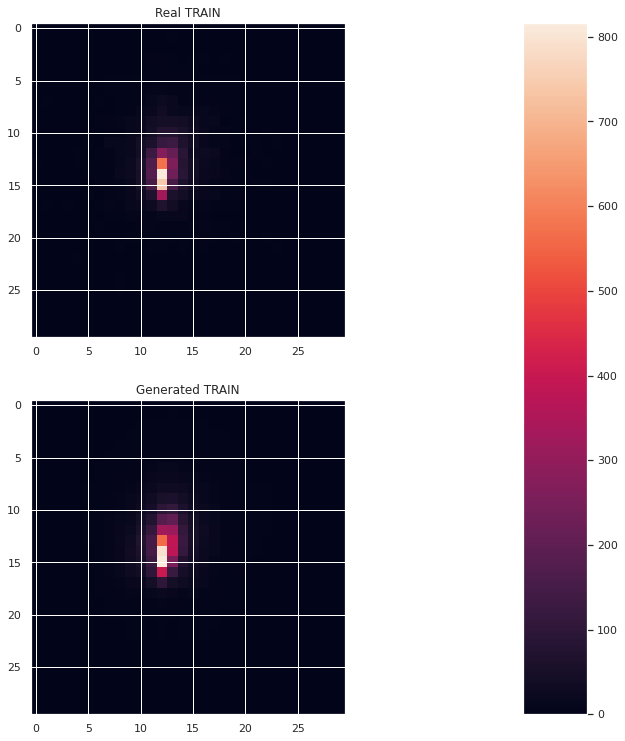

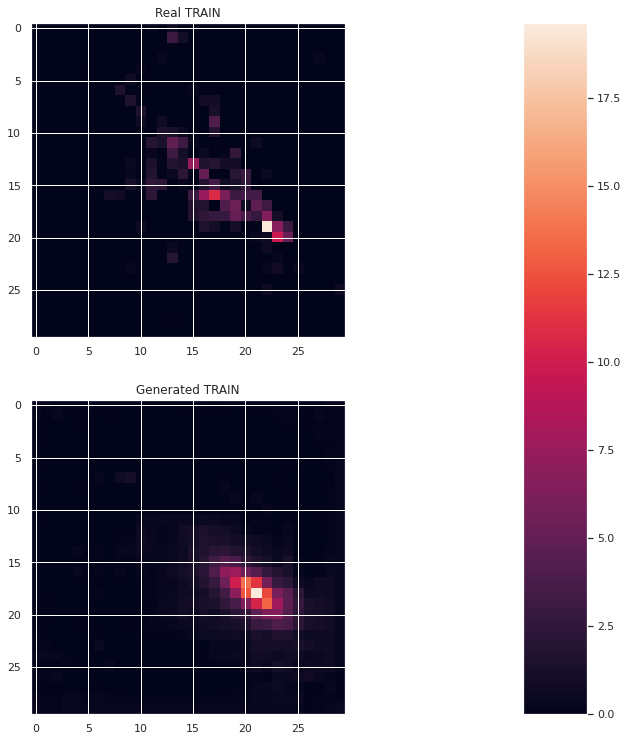

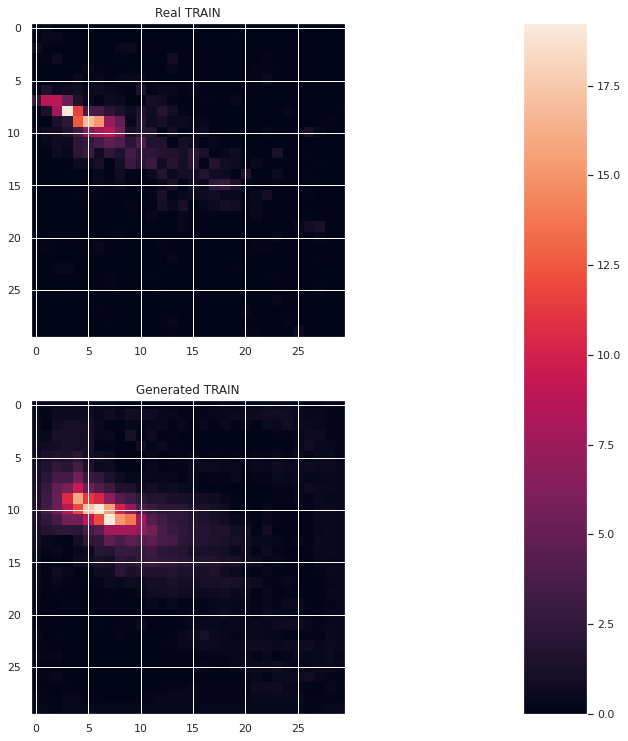

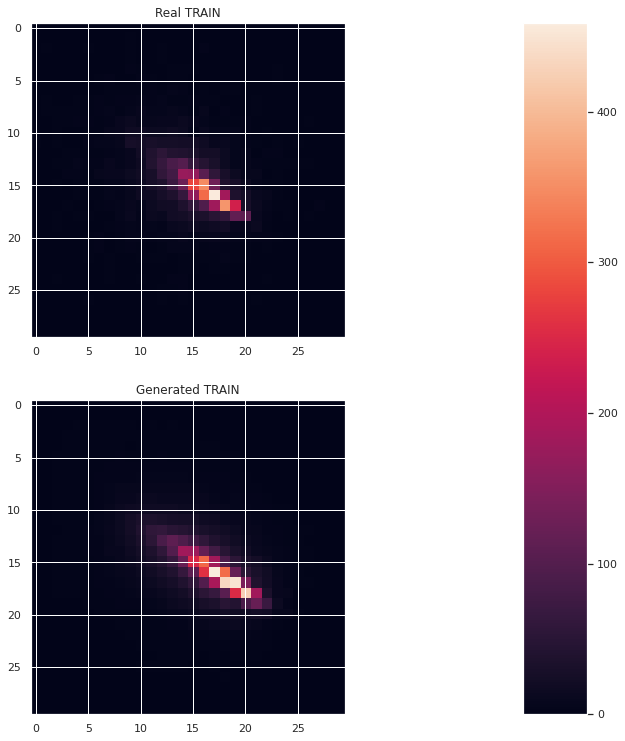

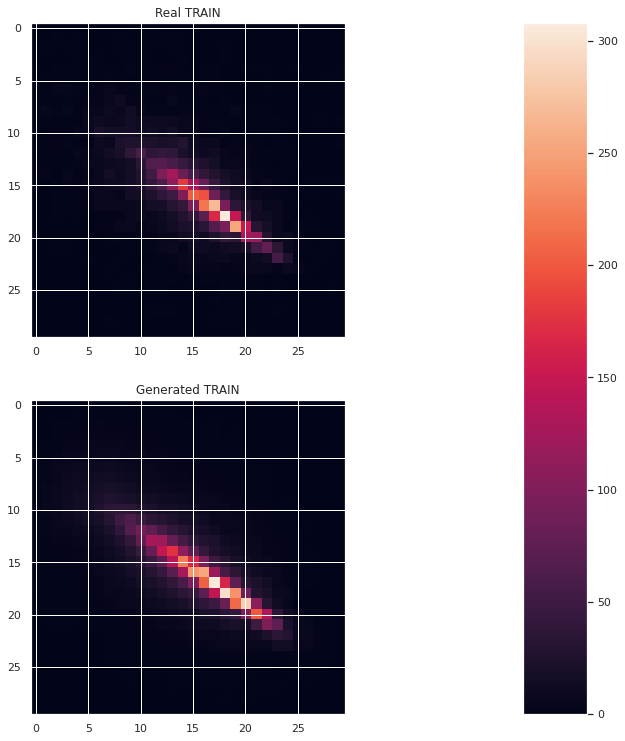

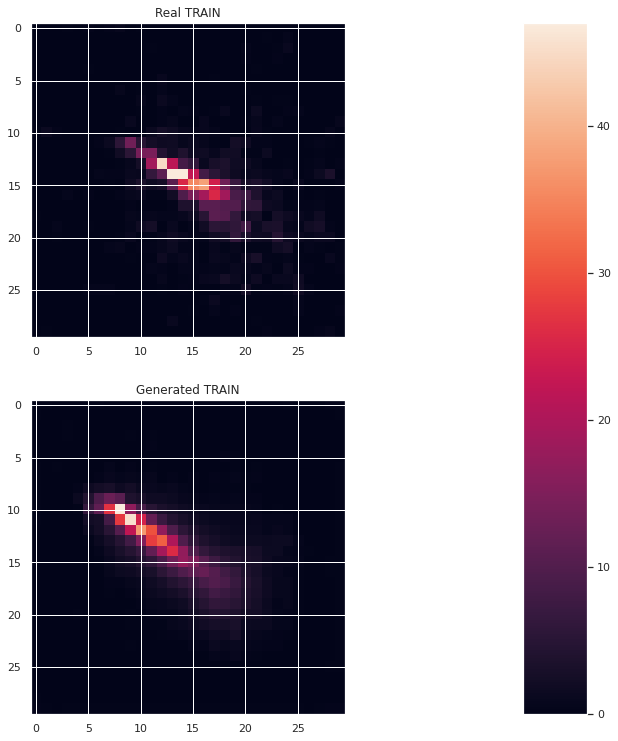

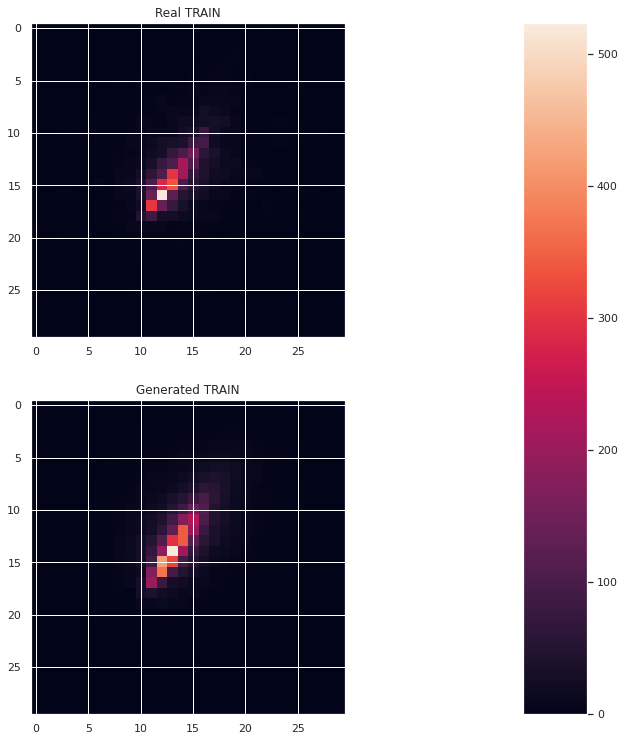

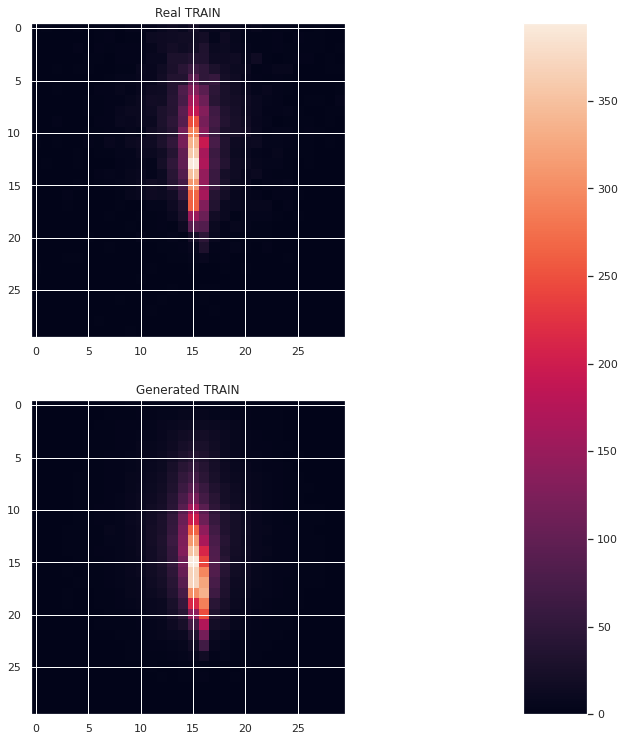

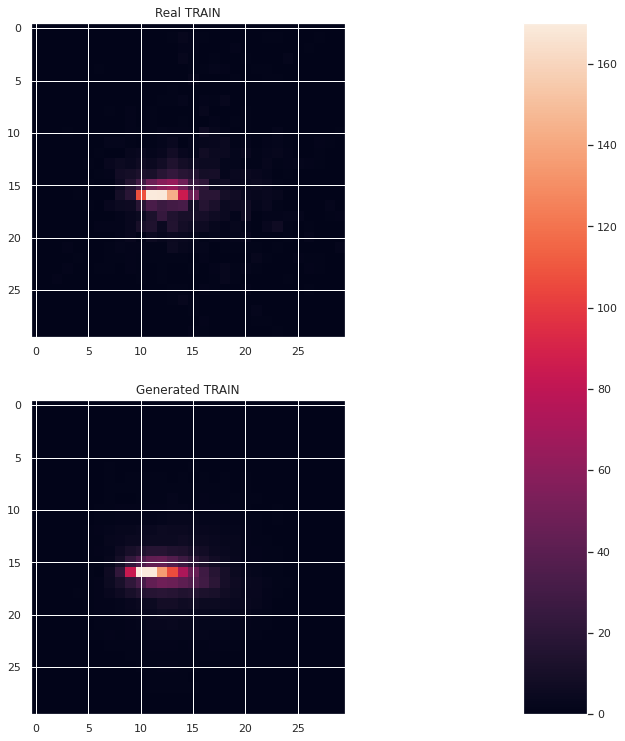

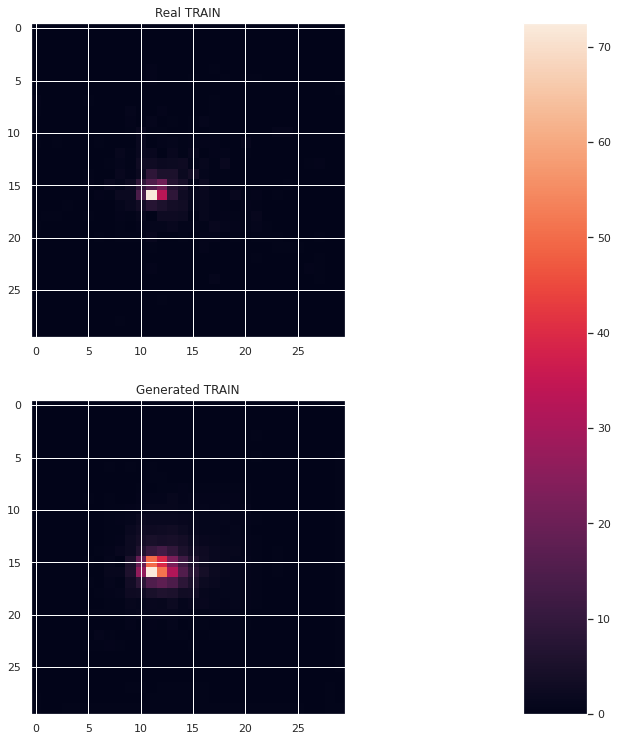

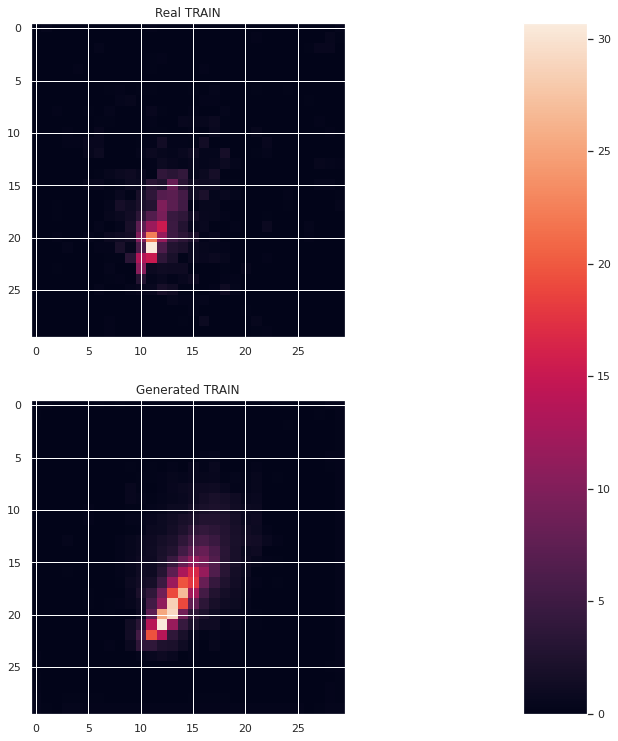

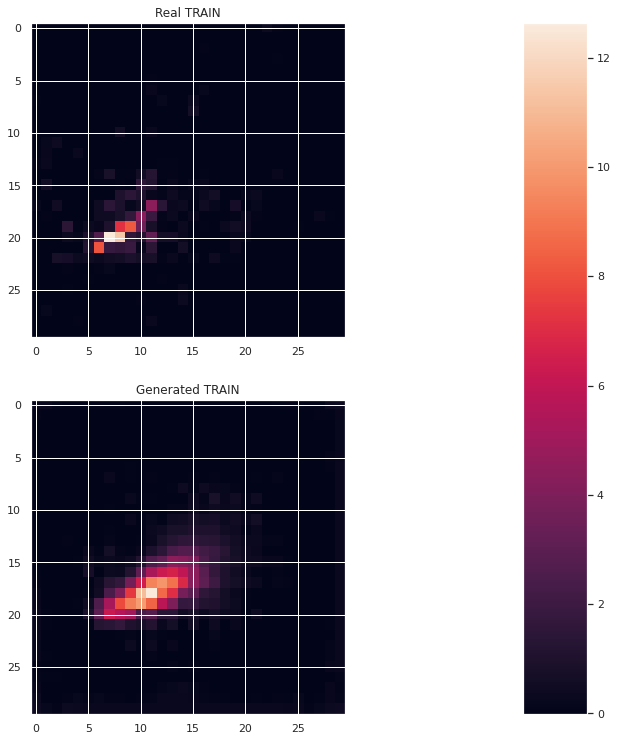

TRAIN ====> Epoch: 0  Average loss: 6.5964 RMSE: 6.476441790073072 KL: 0.11994974999878537


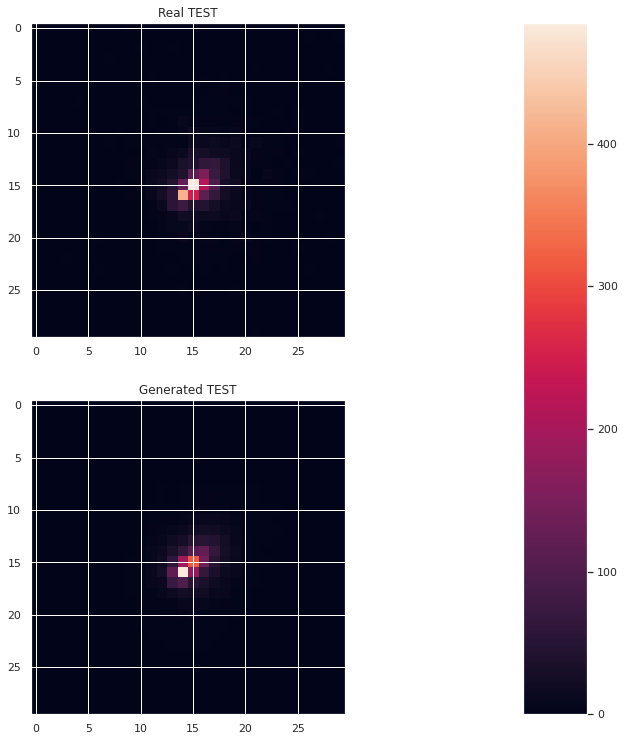

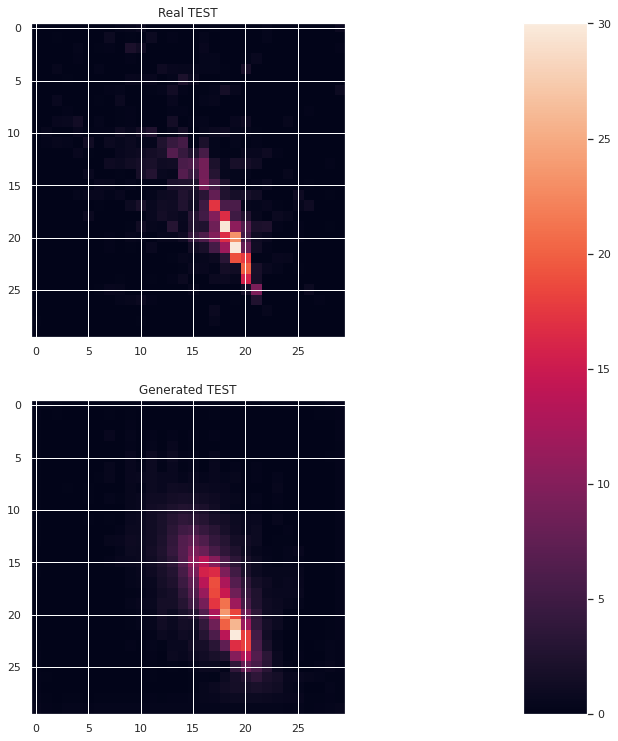

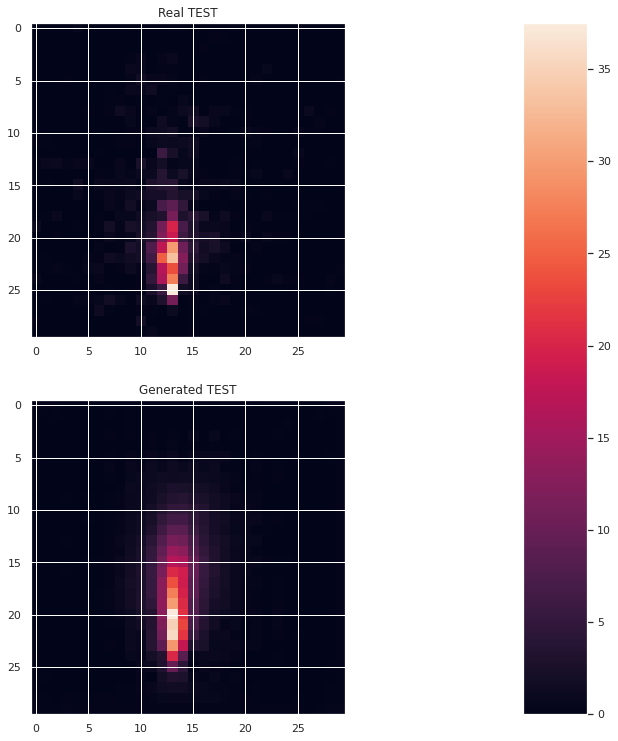

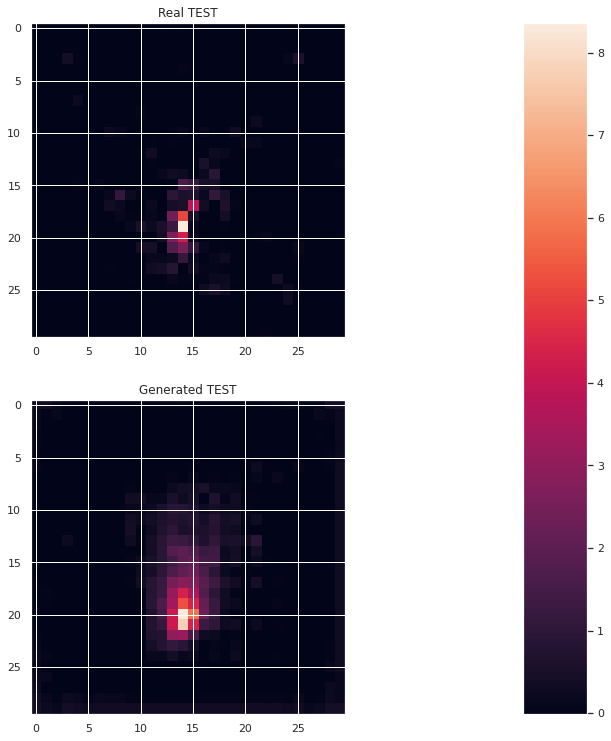

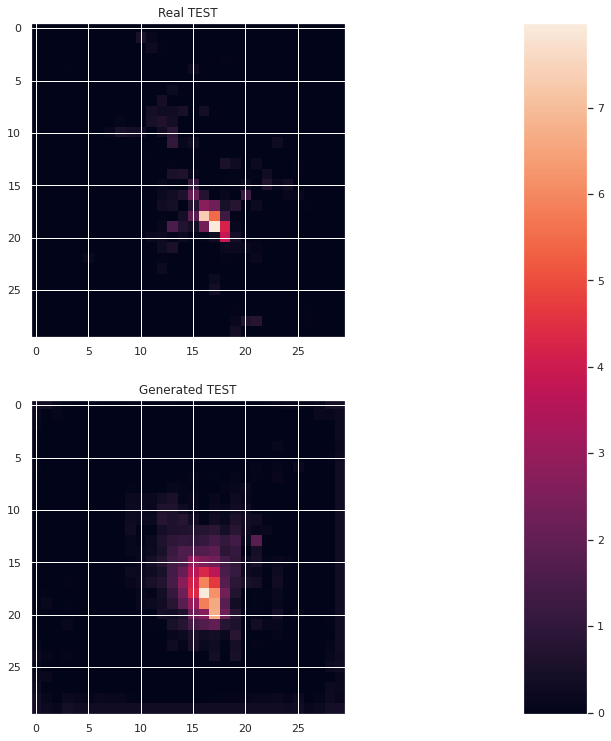

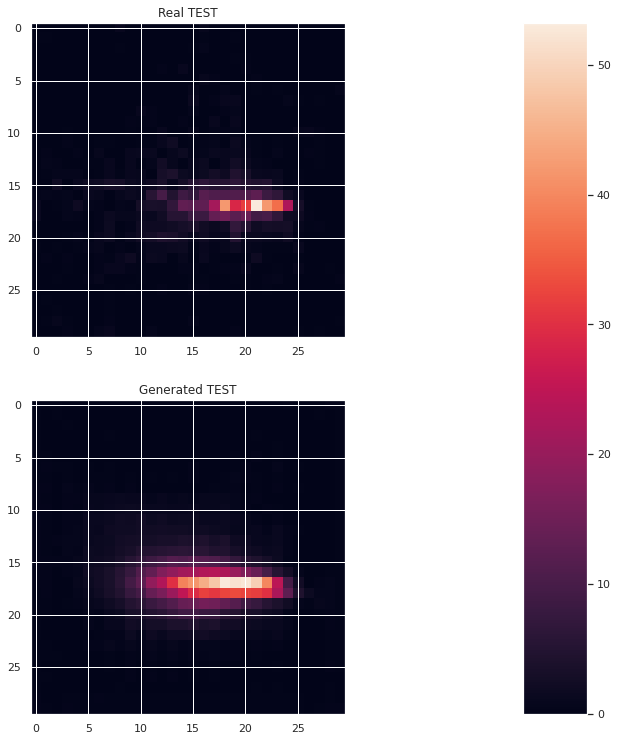

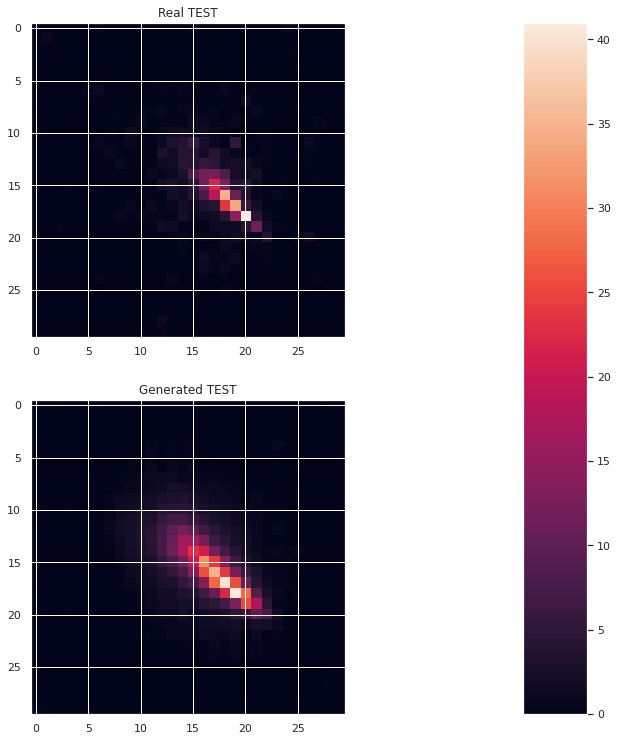

TEST ====> Epoch: 0 Average loss: 6.9885 RMSE: 6.864835199004975 KL: 0.12365072525555815


In [0]:
for epoch in range(1): #7
  train(epoch)
  test(epoch)

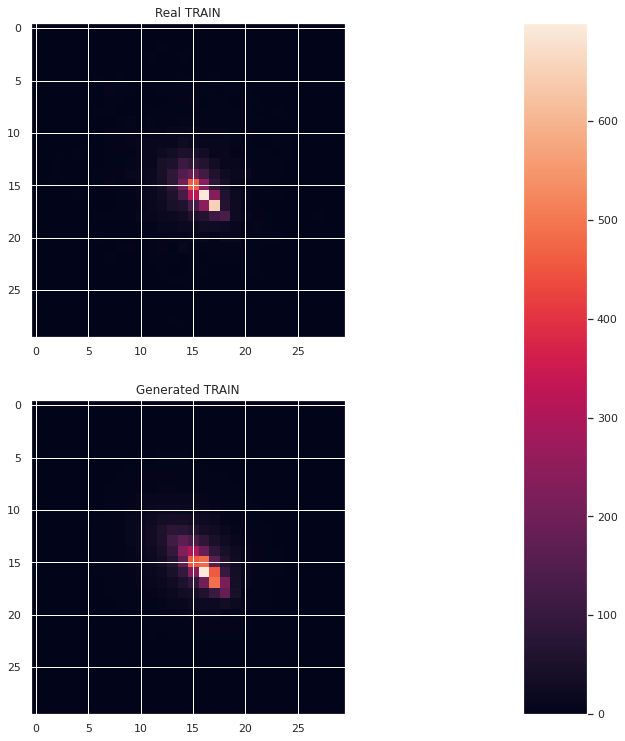

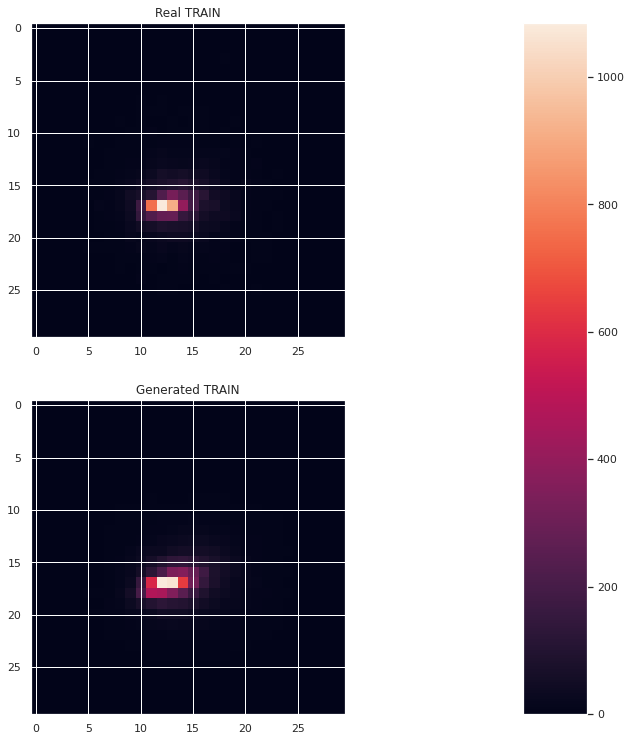

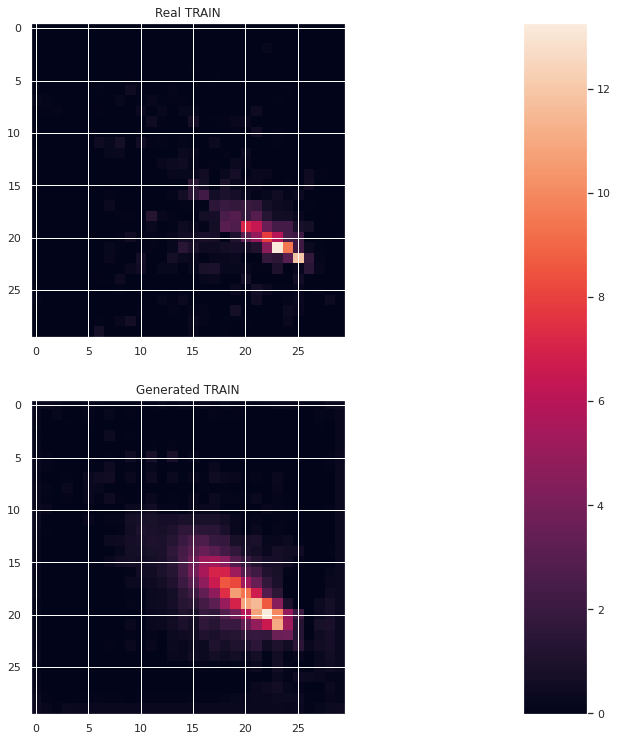

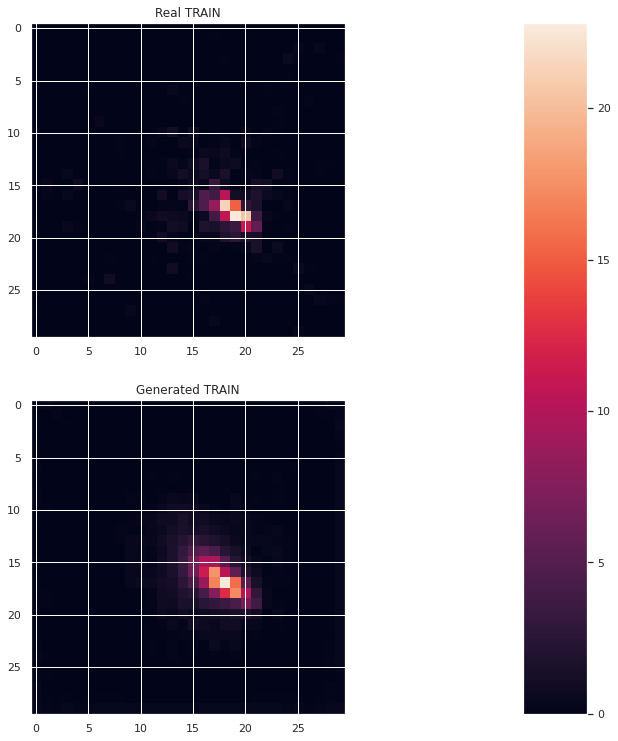

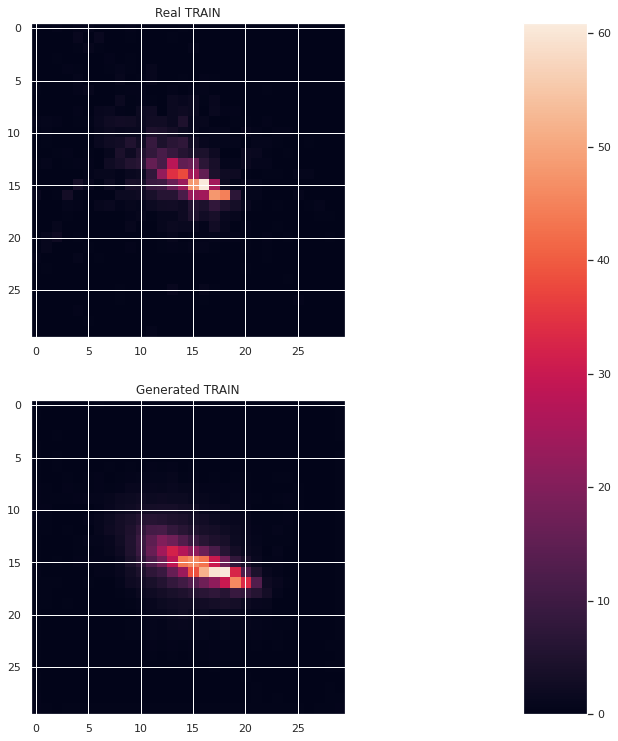

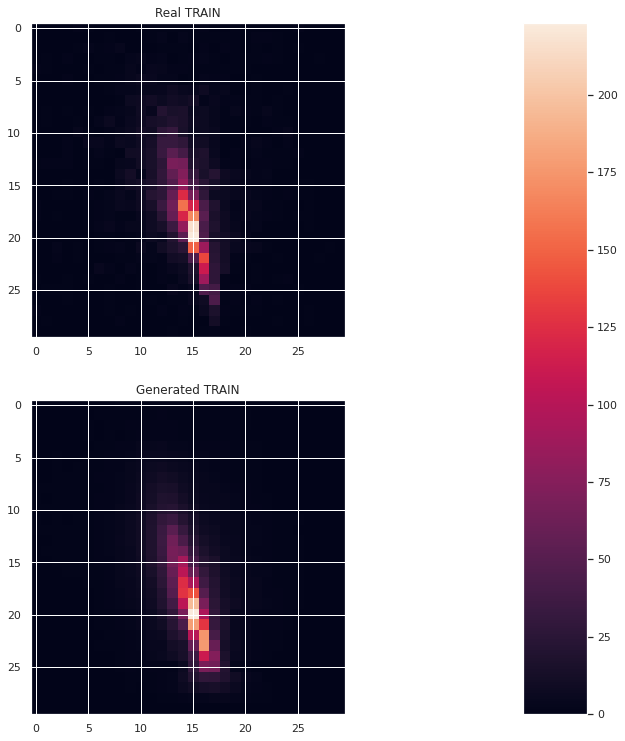

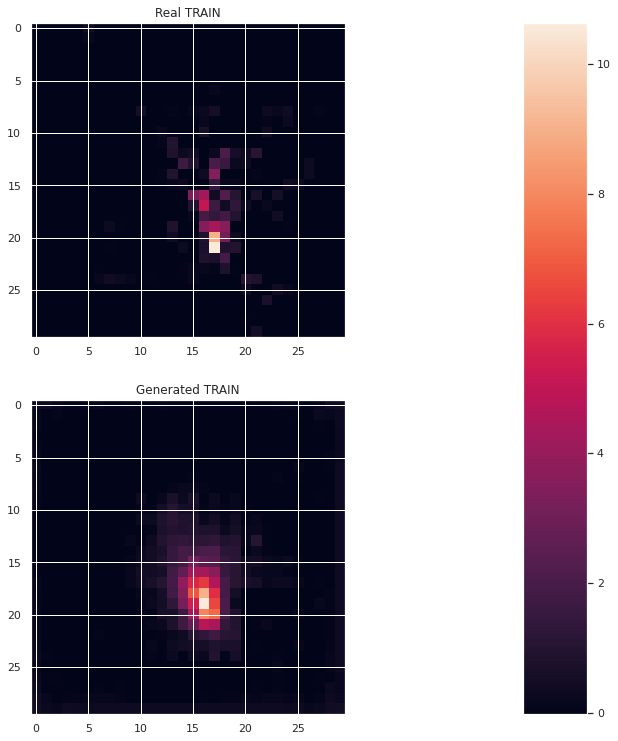

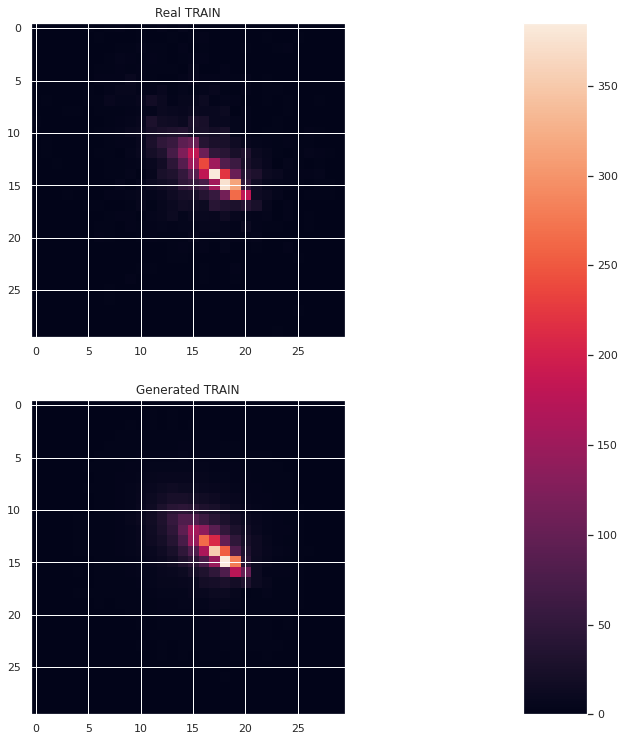

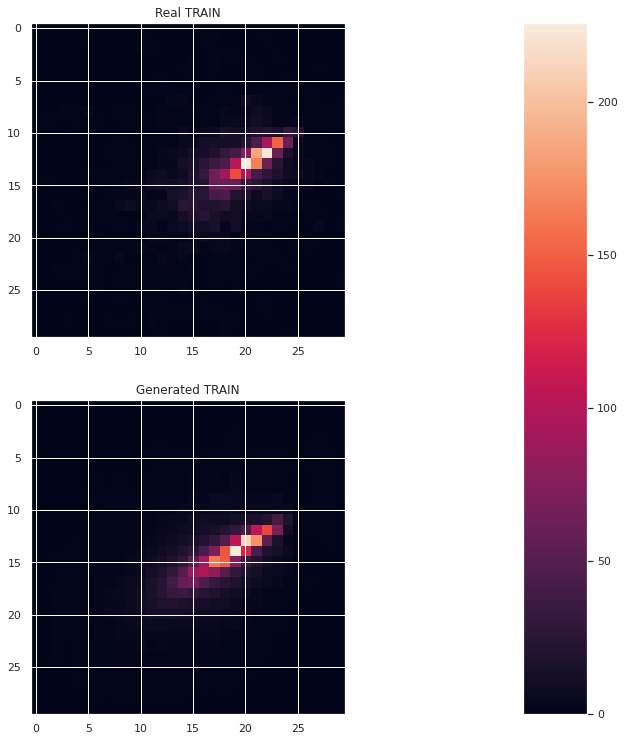

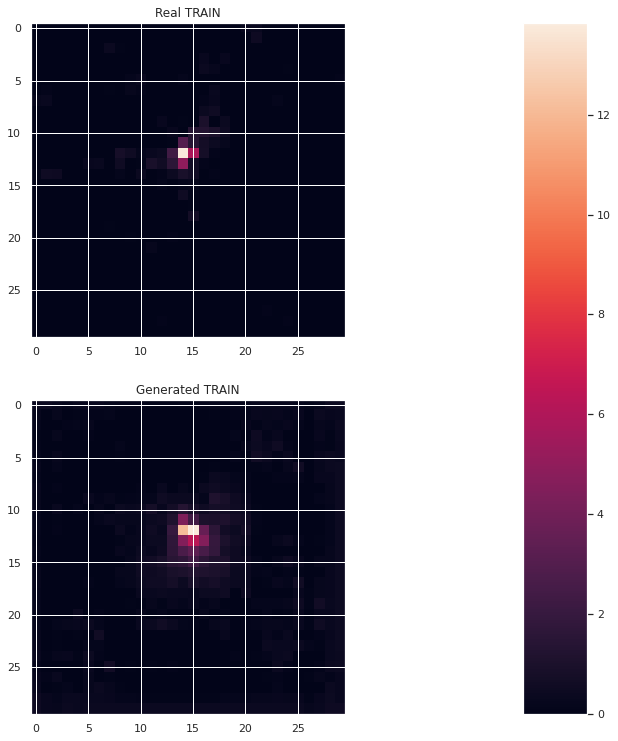

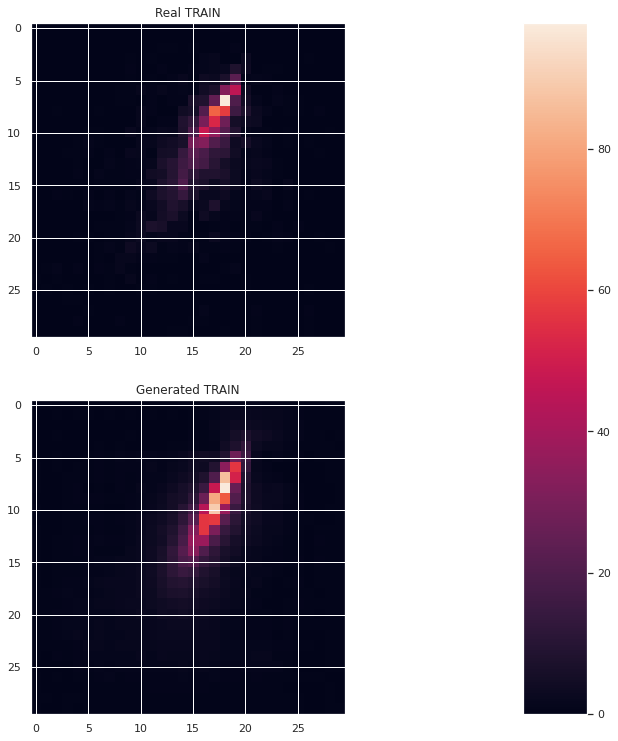

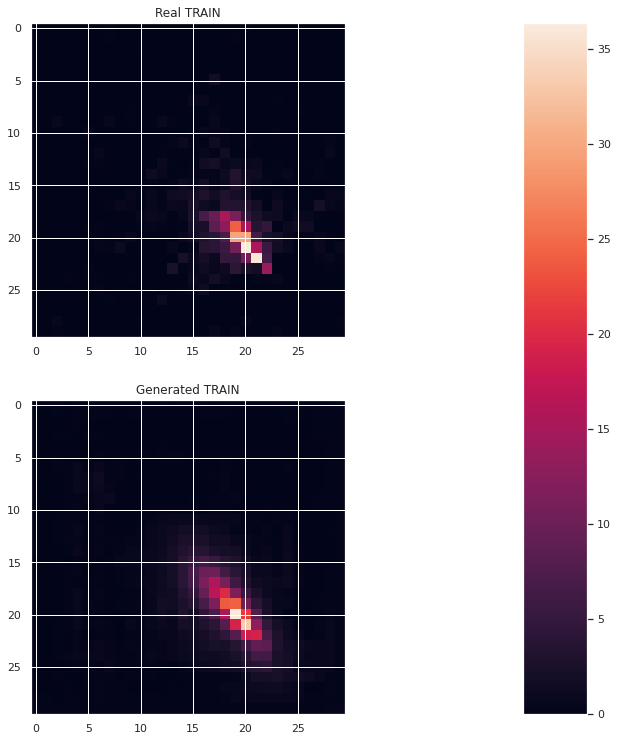

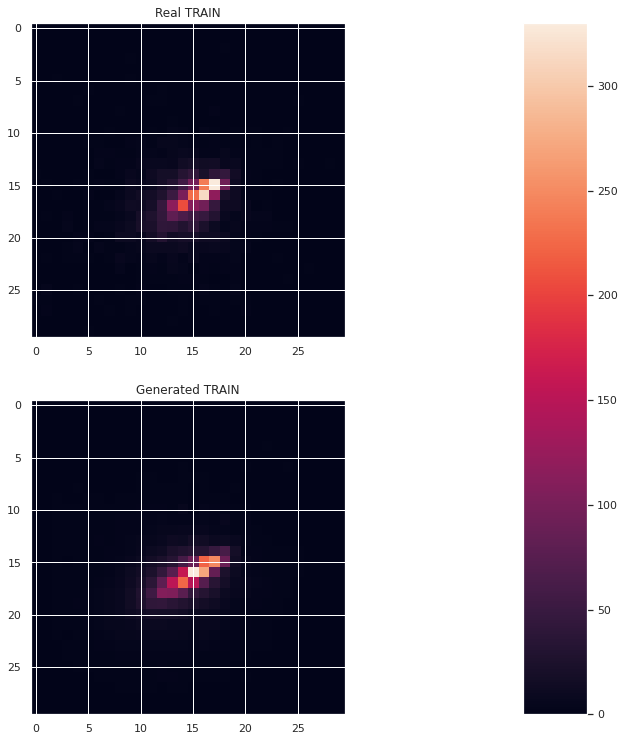

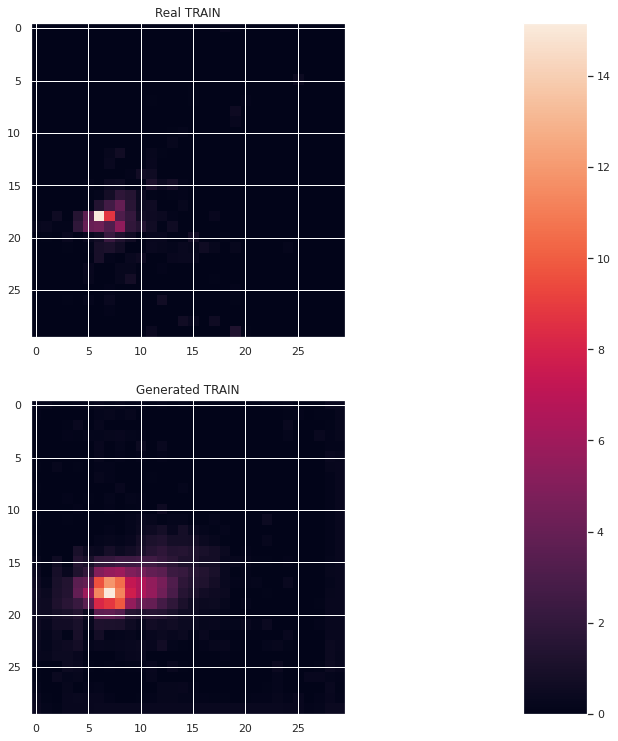

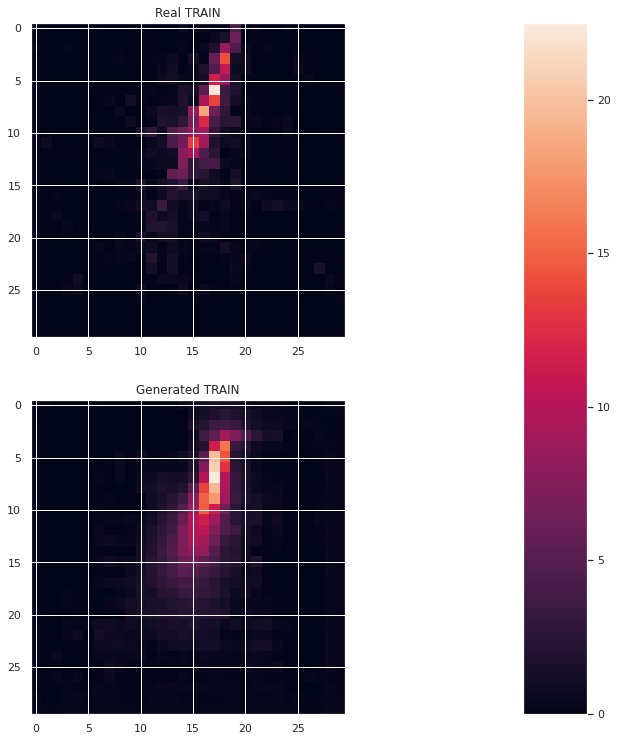

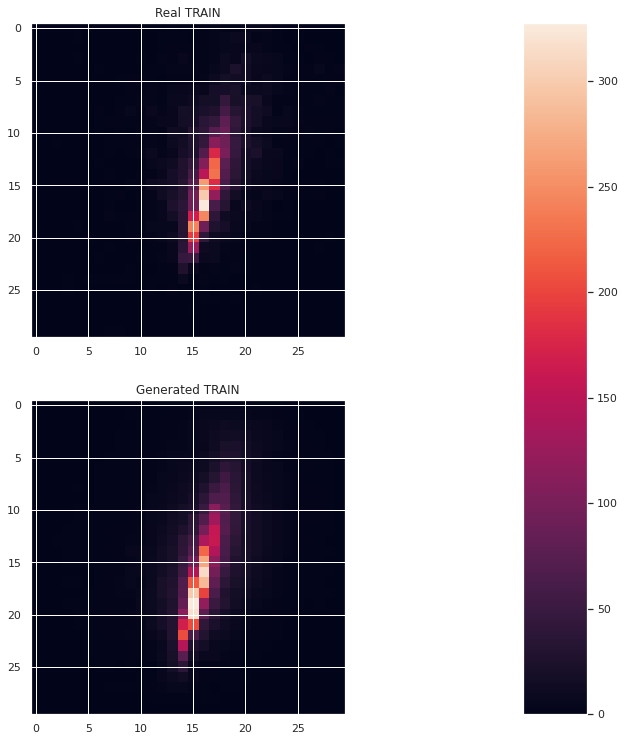

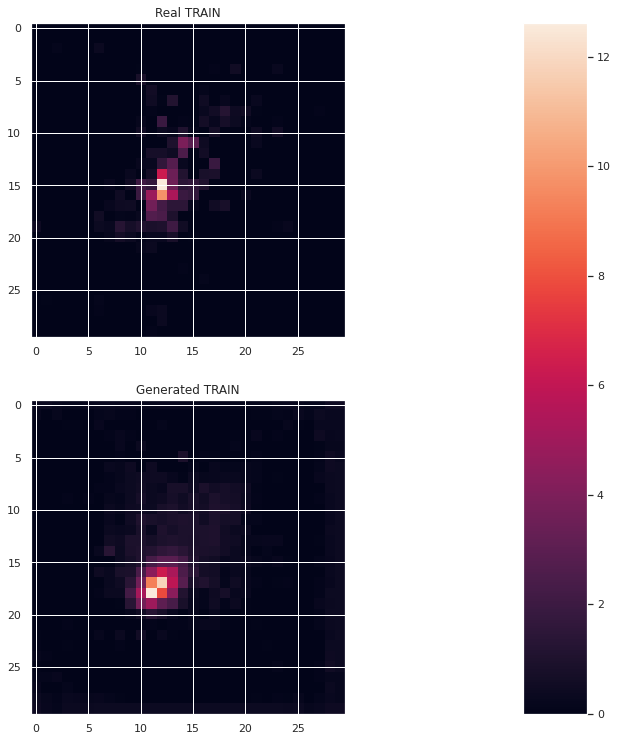

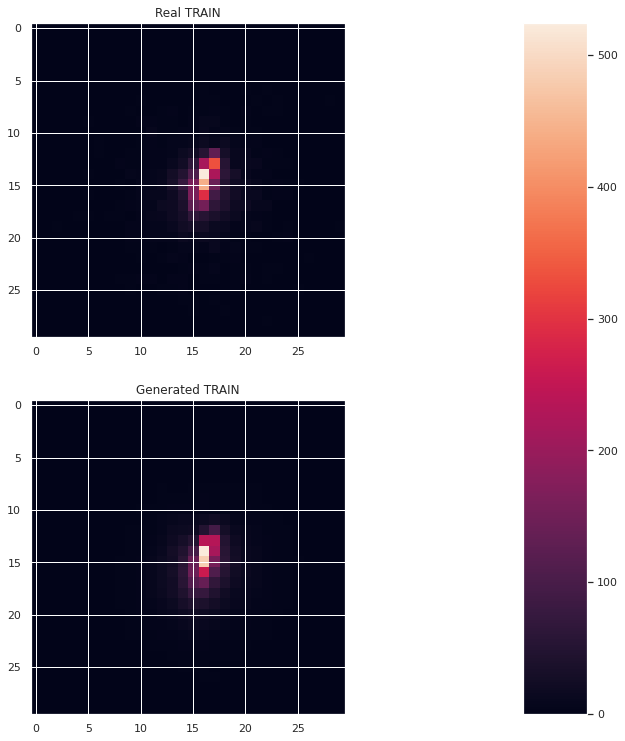

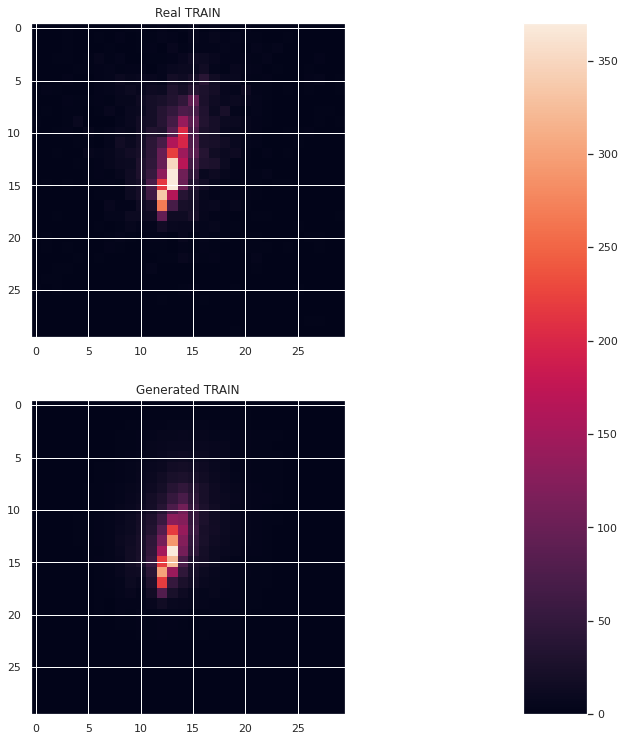

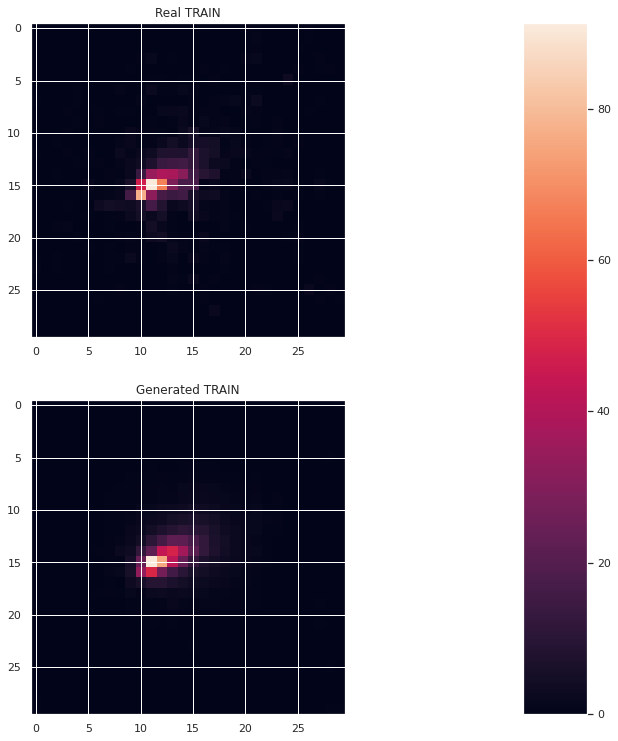

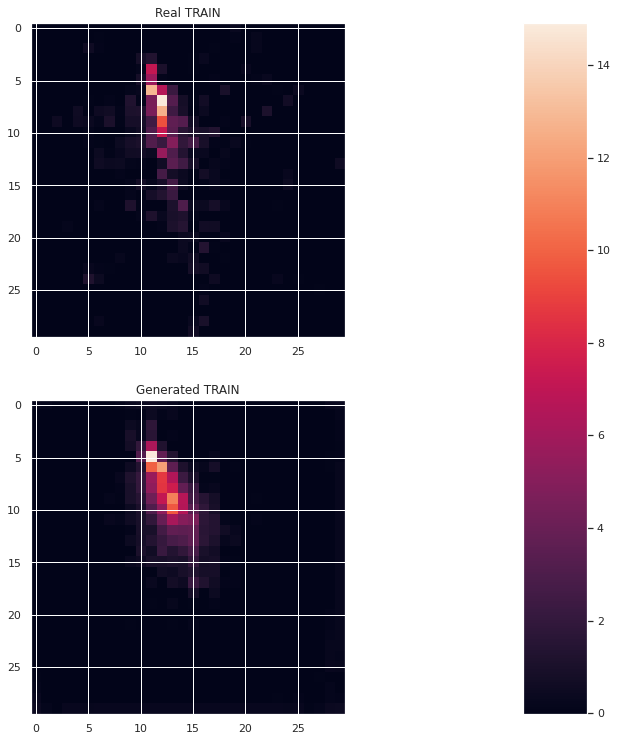

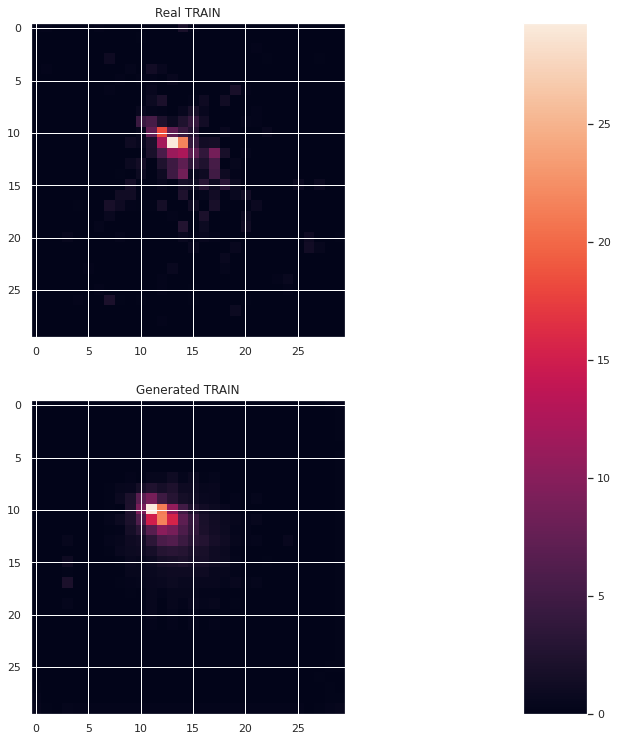

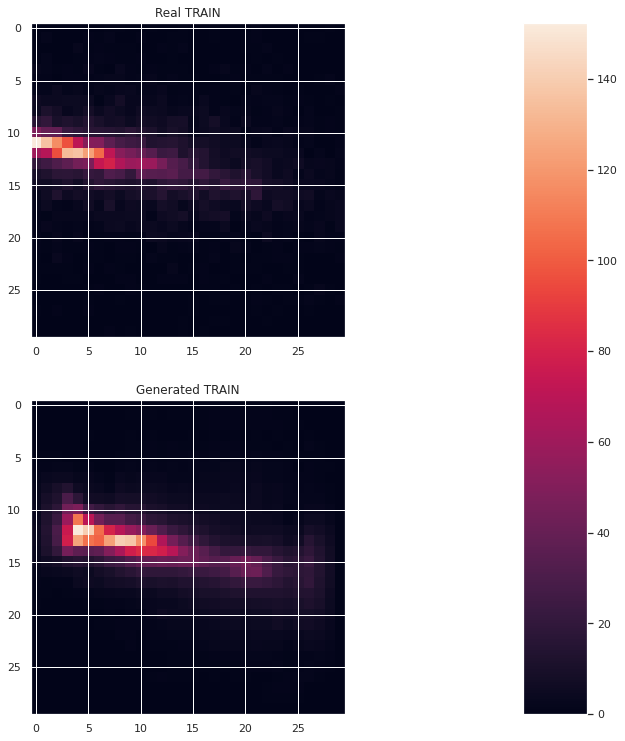

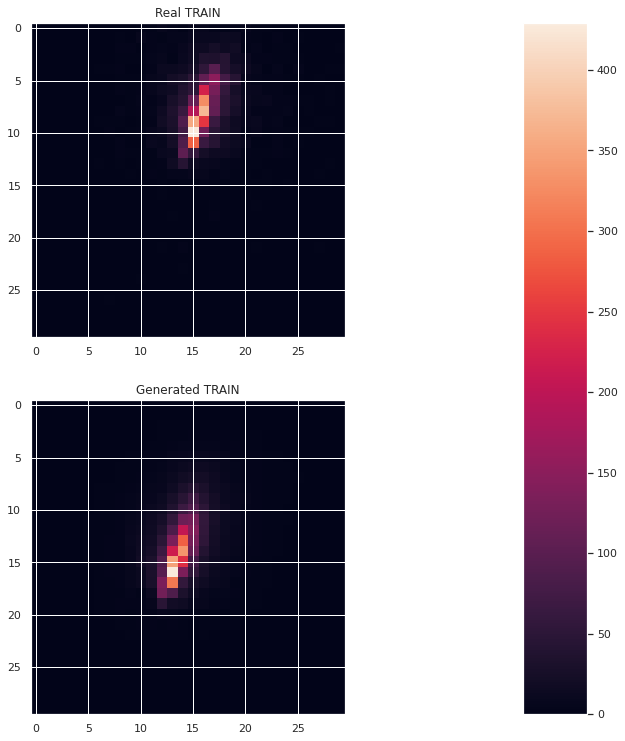

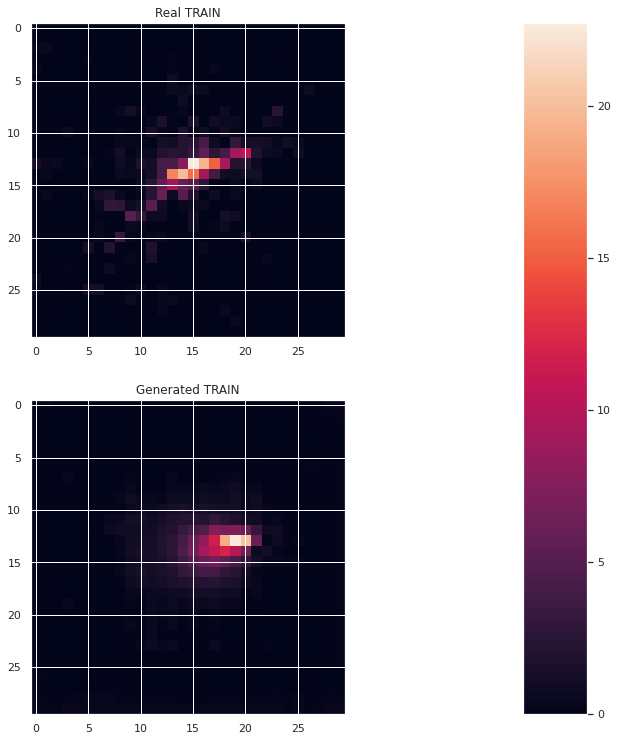

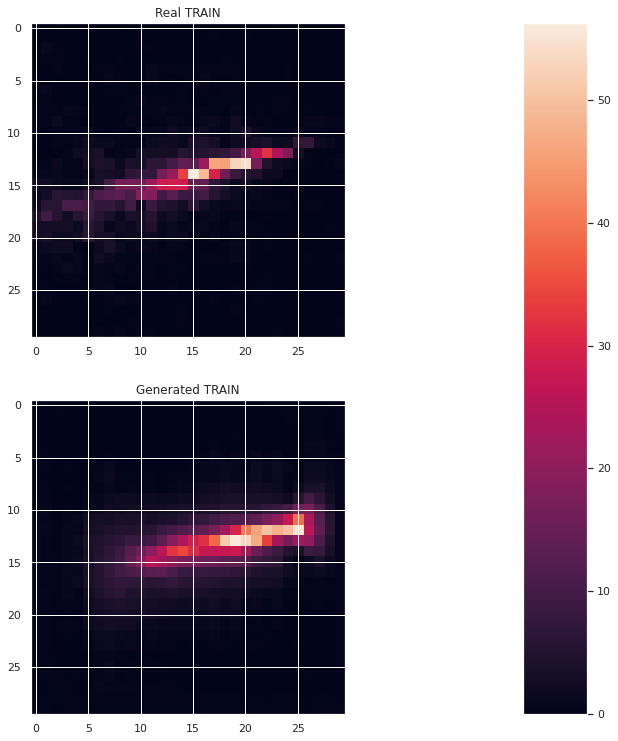

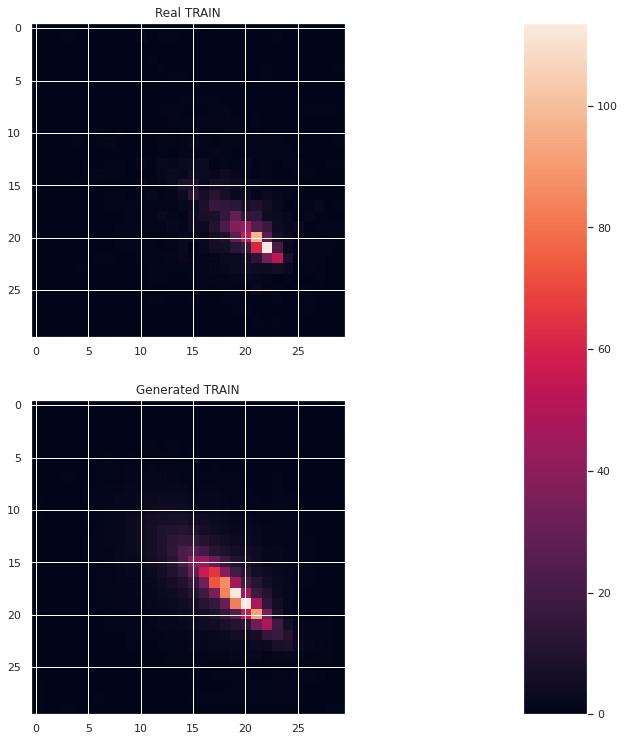

TRAIN ====> Epoch: 0  Average loss: 6.5007 RMSE: 6.3826183778373755 KL: 0.11809092127861669


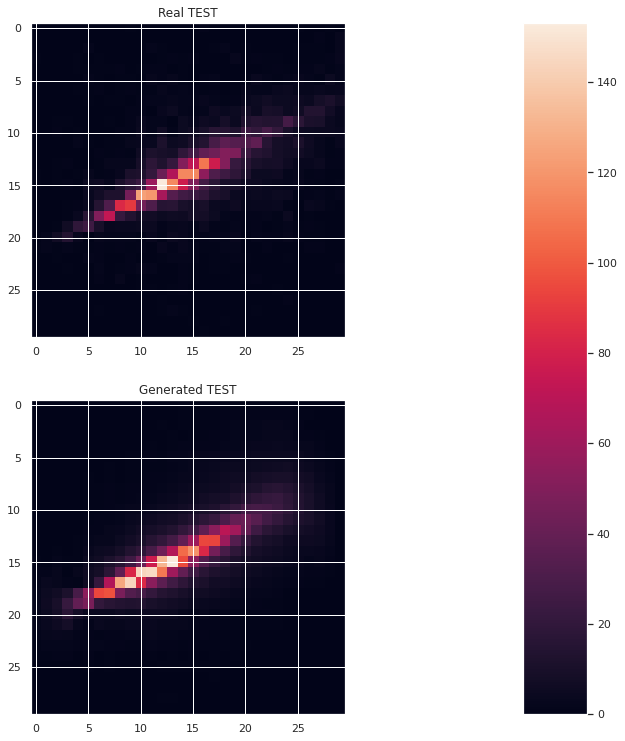

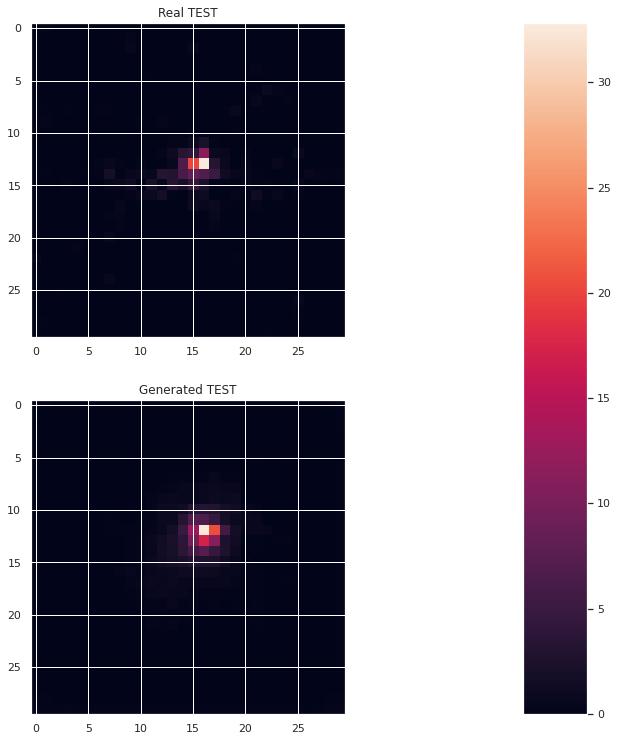

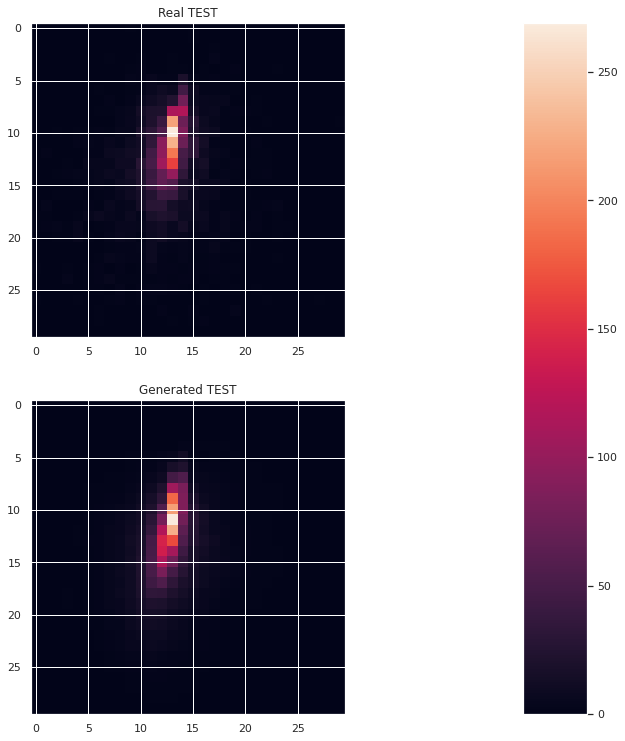

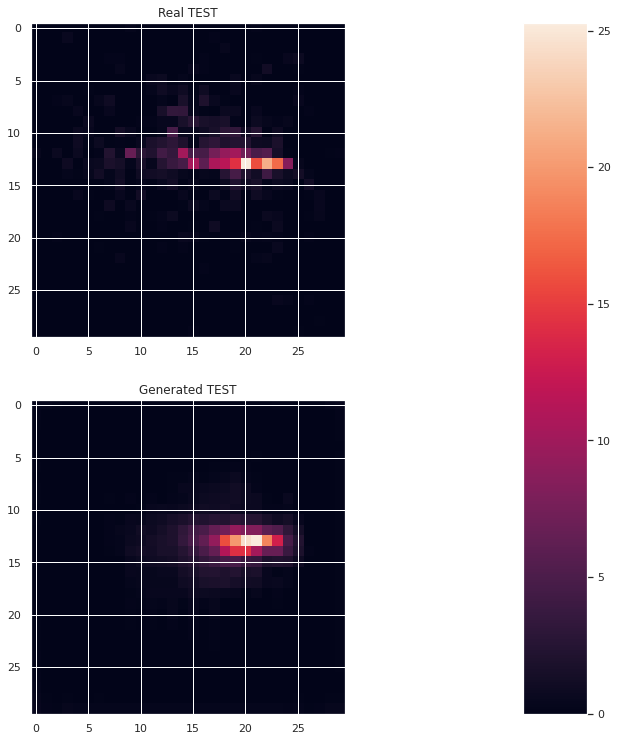

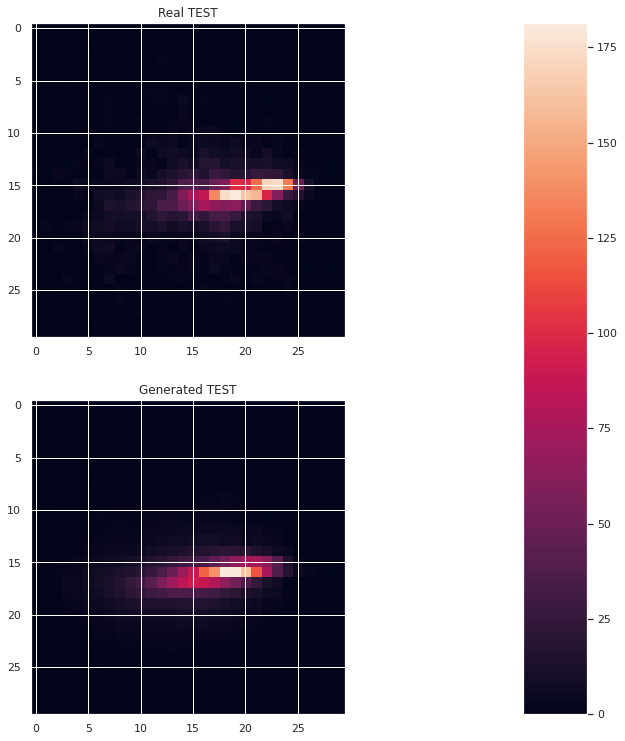

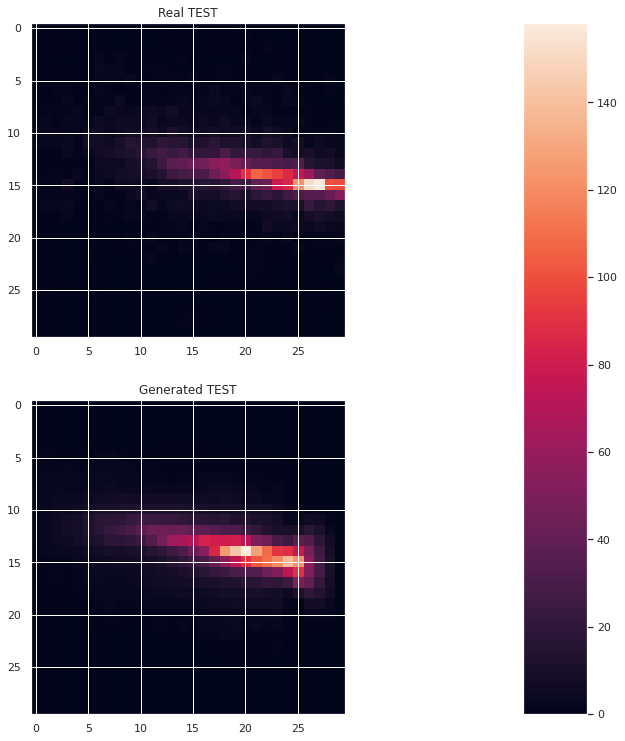

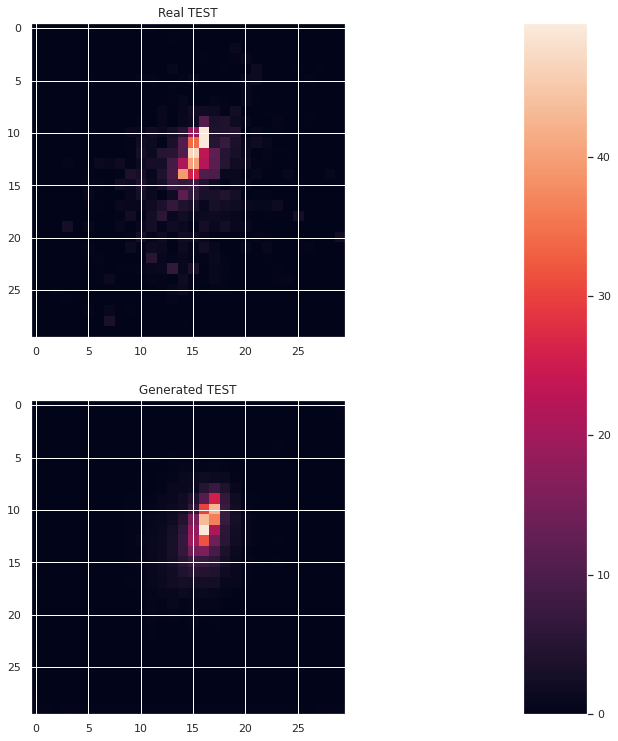

TEST ====> Epoch: 0 Average loss: 6.8282 RMSE: 6.707590659981343 KL: 0.12062481704636


In [0]:
for epoch in range(1): #8
  train(epoch)
  test(epoch)

In [0]:
!/opt/bin/nvidia-smi
!ps -aux|grep python

Sun Mar 29 22:05:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    25W /  75W |    557MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!kill 1224

In [0]:
torch.save(model.state_dict(), '/gdrive/My Drive/vae8.pt')

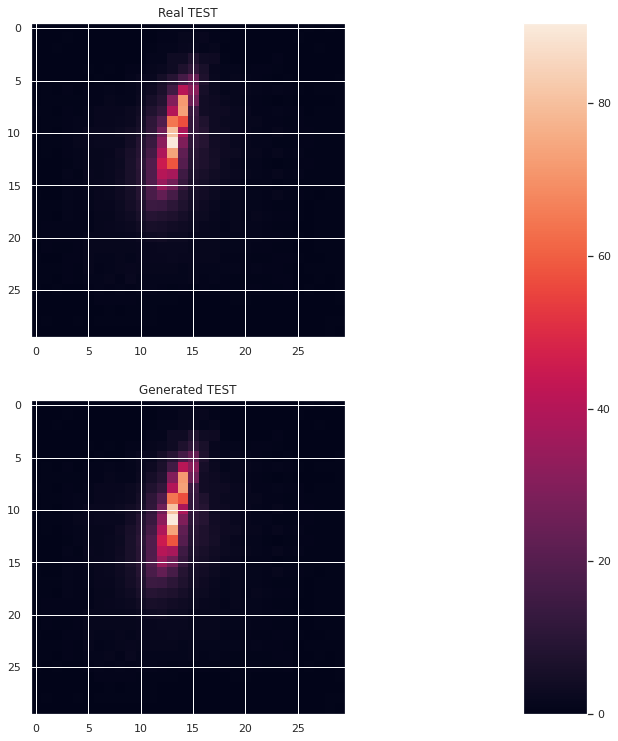

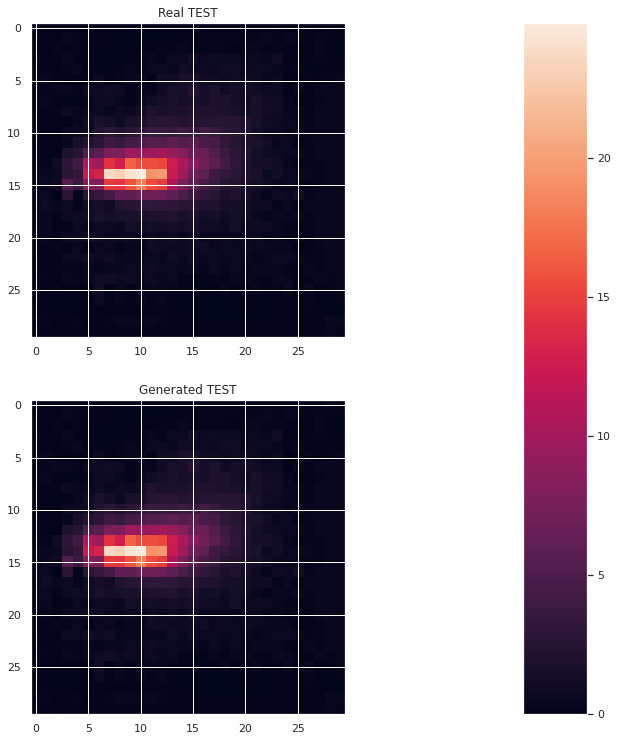

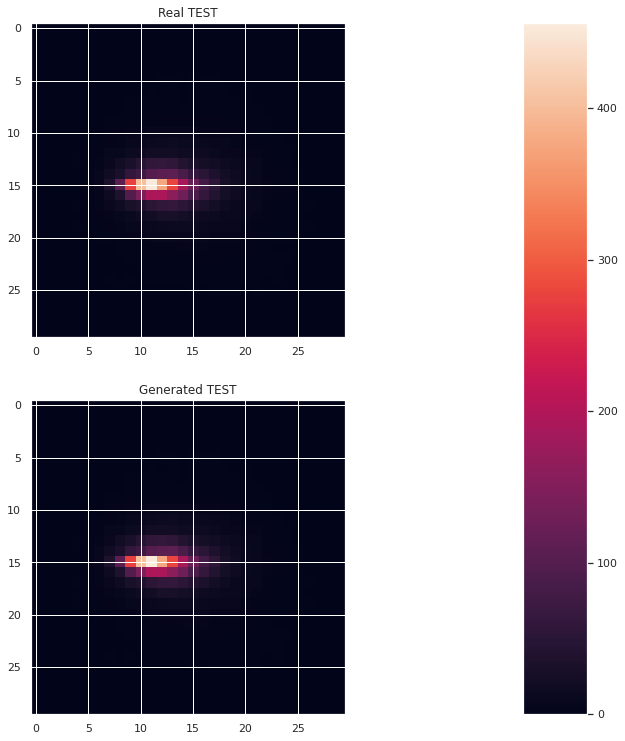

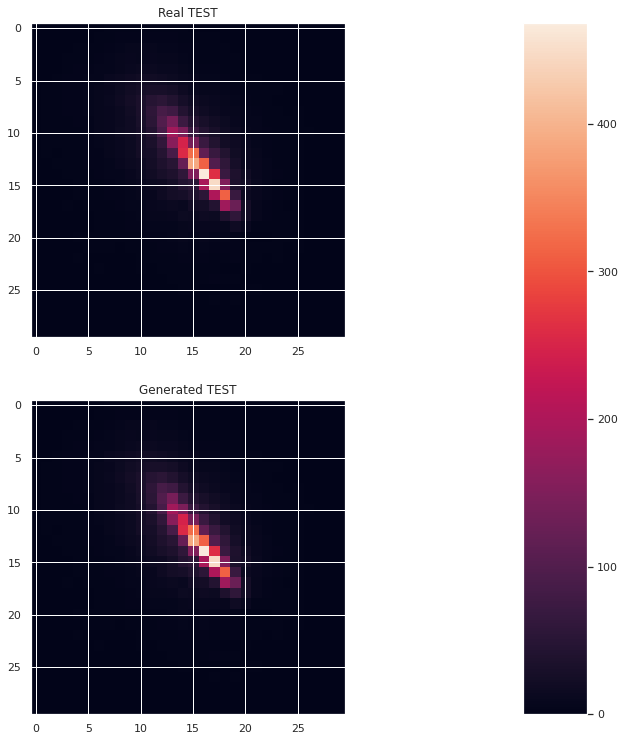

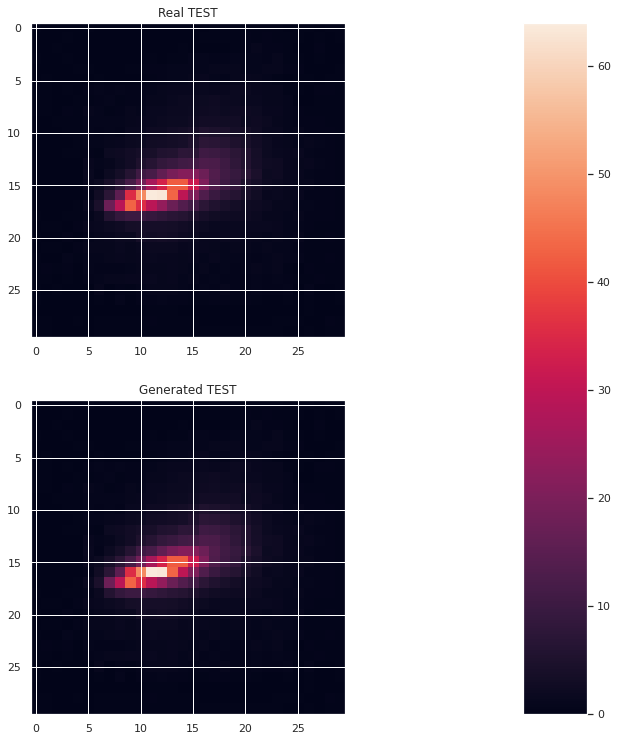

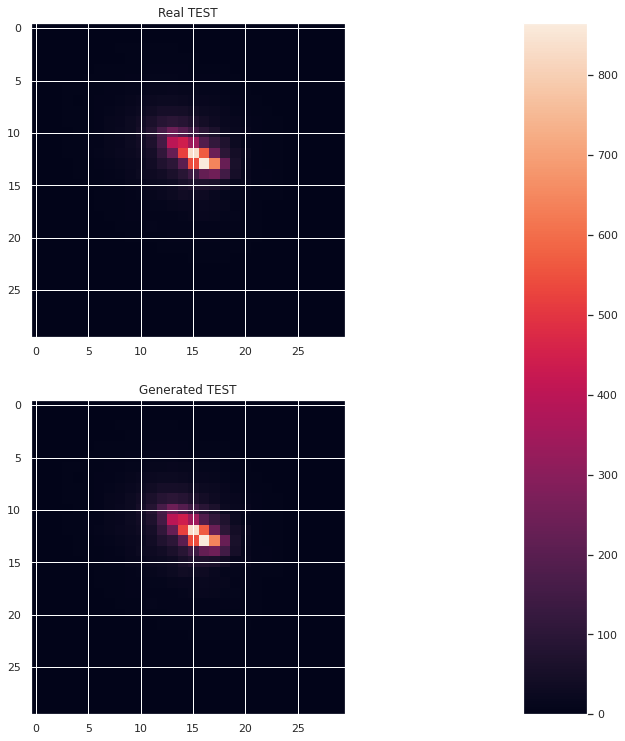

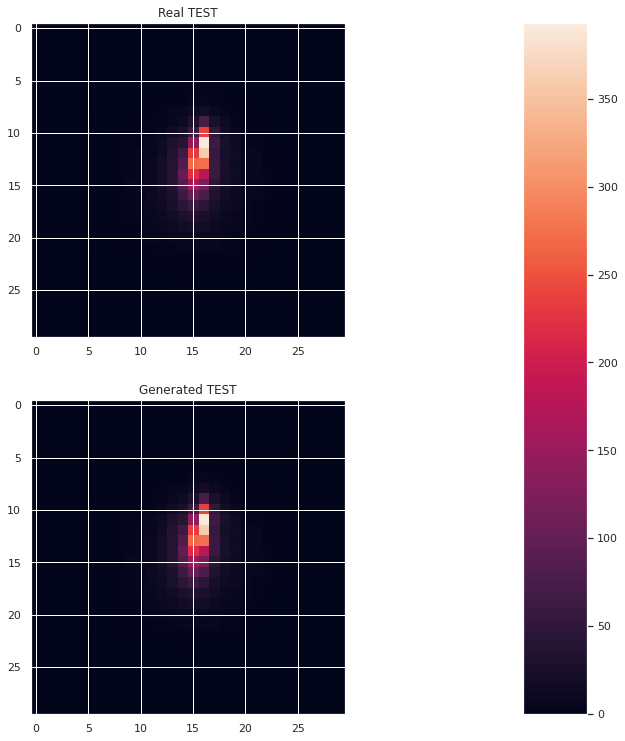

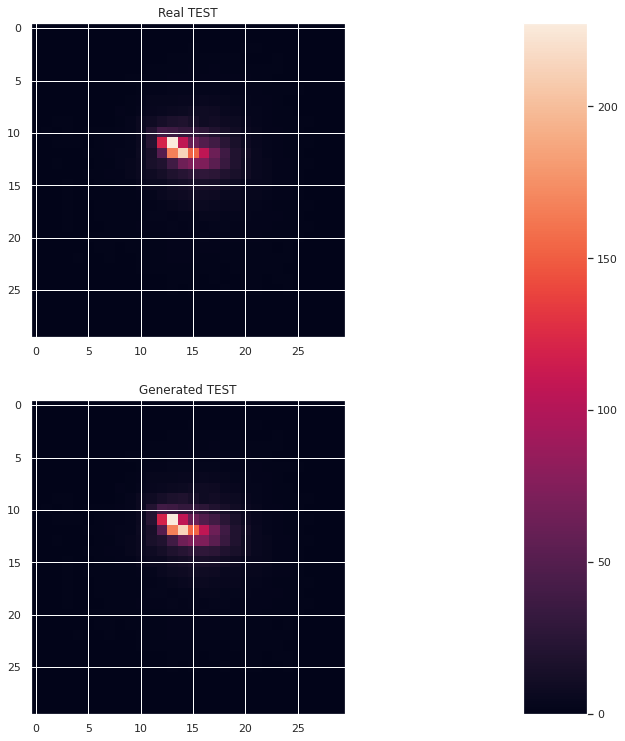

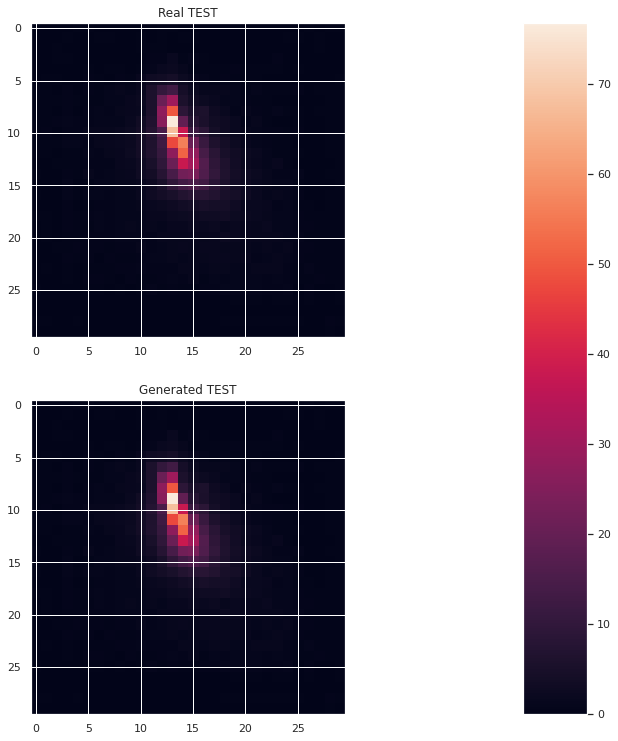

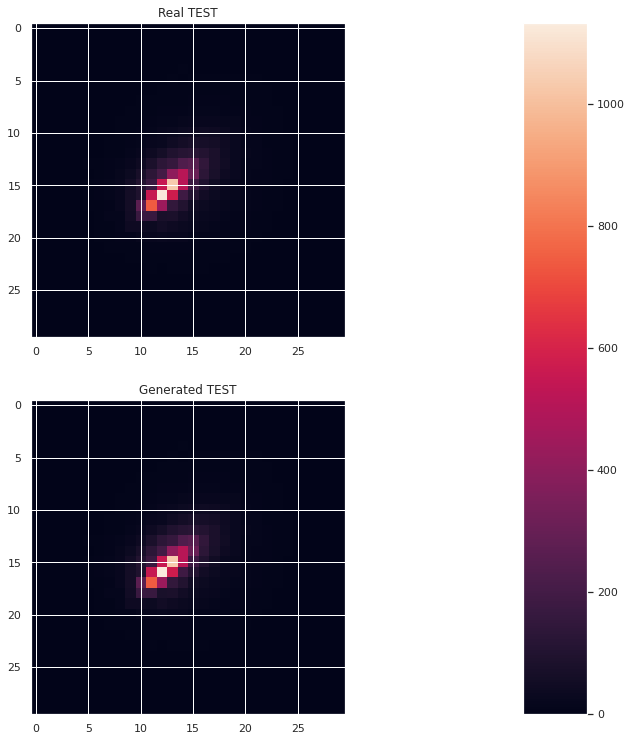

In [0]:
for i in range(10):
  recon = model.decode(torch.tensor(np.random.normal(0,1,size=30)).float().reshape([1, 30]).to(device), a[i*5 + 10].reshape([1, 5]).to(device)) 
  plt.figure(figsize=(12, 12))
  plt.title('Test')
  ax = plt.subplot(211)
  ax.set_title("Real TEST")
  plt.imshow(recon.detach().cpu().numpy().reshape(30, 30))
  ax = plt.subplot(212)
  ax.set_title("Generated TEST")
  plt.imshow(recon.detach().cpu().numpy().reshape(30, 30))
  plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
  cax = plt.axes([0.85, 0.1, 0.075, 0.8])
  plt.colorbar(cax=cax)
  plt.show()